# Humans actively sample evidence to support prior beliefs

This notebook produces all the results and plots presented in Kaanders et al. (2022).

## Overview

<a href='#Figure1B'>1. Figure 1B</a><br>
[2. Figure 1C](#Figure1C)<br>
[3. T-test Accuracy Study 1](#tACCStudy1)<br>
[4. T-test Figure 1C](#tFigure1C)<br>
[5. Figure 2A](#Figure2A)<br>
[6. Figure 2B](#Figure2B)<br>
[7. Figure 2C](#Figure2C)<br>
[8. Figure 2-figure supplement 1](#Figure2sup1)<br>
[9. Figure 3B](#Figure3B)<br>
[10. Figure 3C](#Figure3C)<br>
[11. T-test Accuracy Study 2](#tACCStudy2)<br>
[12. T-test Figure 3C](#tFigure3C)<br>
[13. Figure 3-figure supplement 1](#Figure3sup1)<br>
[14. Figure 4A](#Figure4A)<br>
[15. Figure 4B](#Figure4B)<br>
[16. Figure 4C](#Figure4C)<br>
[17. Figure 4D](#Figure4D)<br>
[18. Figure 4-figure supplement 1](#Figure4sup1)<br>
[19. Figure 4-figure supplement 2](#Figure4sup2)<br>
[20. Figure 4-figure supplement 3](#Figure4sup3)<br>
[21. Figure 4-figure supplement 4](#Figure4sup4)<br>
[22. Figure 4-figure supplement 5](#Figure4sup5)<br>
[23. Figure 4-figure supplement 6](#Figure4sup6)<br>
[24. Figure 4-figure supplement 7](#Figure4sup7)<br>
[25. Figure 4-figure supplement 9](#Figure4sup9)<br>
[26. Figure 4-figure supplement 10](#Figure4sup10)<br>
[27. Figure 4-figure supplement 11](#Figure4sup11)<br>
[28. Figure 4-figure supplement 12](#Figure4sup12)<br>
[29. Saccades](#Saccades)<br>
[30. Appendix 5](#ModelComp)<br>
[31. Functions used](#Functions)<br>

### Load packages

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from pandas.core.frame import DataFrame as DF
from copy import copy as copy
import operator as operator

import sys
sys.path.insert(0, '.../code')

# linking to files in notebooks
from IPython.display import FileLink, FileLinks, Image

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

import patsy
from patsy import dmatrix, demo_data, ContrastMatrix, Poly

# Show graphs in Notebook
%matplotlib inline

%pylab inline
figsize(15, 15);

import sklearn
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score


Populating the interactive namespace from numpy and matplotlib


/Users/paulak/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import rpy2.rinterface
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
library(lme4)
library(nlme)
library(optimx)
library(RCurl)
library(pbkrtest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘nlme’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmList


R[write to console]: 
Attaching package: ‘optimx’


R[write to console]: The following object is masked from ‘package:nlme’:

    coef<-


R[write to console]: Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar



In [4]:
# hide warning messages
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

### Load data & data preparation

#### Study 1

In [5]:
# load data study 1
Data1=pd.read_csv('../data/exp1_main_data.csv')

In [6]:
subjects1=Data1['Participant'].unique() # making an array with the participant numbers

In [9]:
Data1.columns

Index(['Participant', 'Trial', 'Correct1', 'CorrectKey', 'Response1', 'RT1',
       'DotDifference', 'DotNumberRight', 'DotNumberLeft', 'Conf1', 'Conf1_RT',
       'CipResponse', 'CipRT', 'Correct2', 'Response2', 'RT2', 'Conf2',
       'Conf2_RT', 'ZConf1', 'ZConf2', 'Switch', 'ZSwitch', 'ZDifficult',
       'Block', 'NonAbsDiff', 'ZNonAbsDiff', 'LeftTime', 'RightTime',
       'ChosenTime', 'UnchosenTime', 'Change', 'Type', 'DeltaSampling',
       'ZDeltaSampling', 'ConfChange'],
      dtype='object')

#### Study 2

In [7]:
# load data study 2
Data2Free=pd.read_csv('../data/exp2_data_free.csv')
Data2Fixed = pd.read_csv('../data/exp2_data_fixed.csv')

In [8]:
subjects2=Data2Free['participant'].unique() # making an array with the participant numbers

In [9]:
Data2Fixed['ChosenTime'] = [Data2Fixed['Left_Gazetime_New'].iloc[row]/1000 if Data2Fixed['Response1'].iloc[row]=='left' else Data2Fixed['Right_Gazetime_New'].iloc[row]/1000 for row in range(len(Data2Fixed))]
Data2Fixed['UnchosenTime'] = [Data2Fixed['Left_Gazetime_New'].iloc[row]/1000 if Data2Fixed['Response1'].iloc[row]=='right' else Data2Fixed['Right_Gazetime_New'].iloc[row]/1000 for row in range(len(Data2Fixed))]


In [10]:
Data2=pd.concat([Data2Free,Data2Fixed])

<a id=Figure1B></a>

### Figure 1B

In [118]:
# make new dummy variable encoding whether or not a left response was made for both choices
Data1['Left1'] = [1 if x == 'left' else 0 for x in Data1['Response1']]
Data1['Left2'] = [1 if x == 'left' else 0 for x in Data1['Response2']]

/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value enc

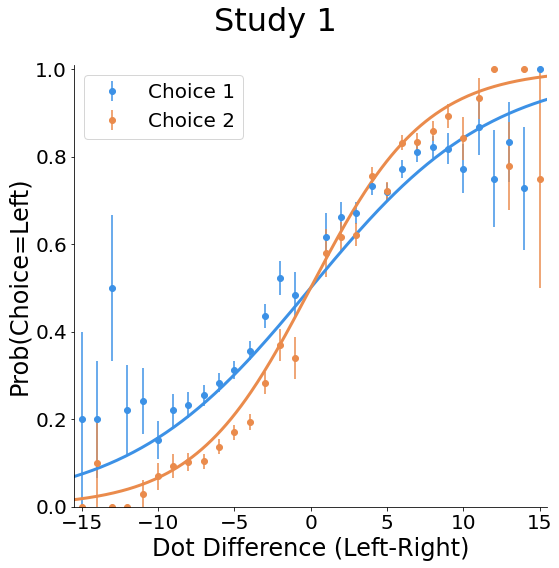

In [17]:
fig=figure(figsize=(8,8))
fig.suptitle('Study 1', fontsize = 32)
logistic_regression(subjects1, Data1)

<a id=Figure1C></a>

### Figure 1C

In [18]:
# make new dataframe for figure 1C
DF1=pd.DataFrame(data=[])
DF1['subject']=subjects1
DF1['ChosenTime']= [float(mean(Data1[Data1['Participant']==x]['ChosenTime']))/4 for x in DF1['subject']] # divide by total sampling time (4s)
DF1['UnchosenTime']=[float(mean(Data1[Data1['Participant']==x]['UnchosenTime']))/4 for x in DF1['subject']] # divide by total sampling time (4s)


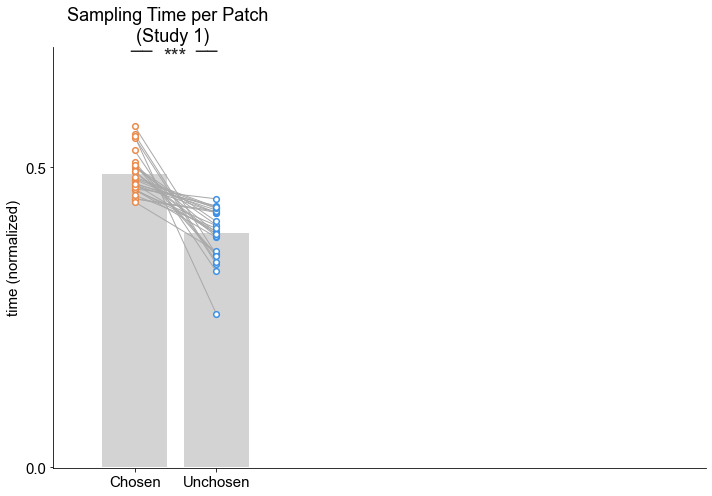

In [19]:
# make figure 1B
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(DF1['ChosenTime']), mean(DF1['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects1: # create points per participant and lines between them
    ax.scatter(0, DF1[DF1['subject']==subject]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF1[DF1['subject']==subject]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    x = [0, 1]
    y = [DF1[DF1['subject']==subject]['ChosenTime'].iloc[0], DF1[DF1['subject']==subject]['UnchosenTime'].iloc[0]]
    ax.plot(x, y, color='#A9A9A9', lw=1)
#     ax.plot(1, DF1[DF1['subject']==subject]['UnchosenTime'], color='#A9A9A9', lw=1)
# set axes limits
ax.set_xlim([-1,7]) 
ax.set_ylim([-0.001,0.7])

# add some text for labels, title and axes ticks
ax.set_ylabel("time (normalized)", fontsize=15)
ax.set_title("Sampling Time per Patch \n (Study 1)", fontsize=18)
ttl = ax.title
ttl.set_position([0.18, 1.01])
ax.set_xticks((np.arange(2)))
yticks = np.arange(0.0, 0.7, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen"), fontsize=15)
grid(False)
sns.set_style('white', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

ax.annotate('***', xy=(0.35,0.675), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,0.70), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,0.70), xycoords='data', fontsize=20)

sns.despine(right=True, top=True)
plt.tight_layout()

<a id=tACCStudy1></a>

### T-test Accuracy Study 1

In [20]:
DF1['Correct1']=[float(mean(Data1[Data1['Participant']==x]['Correct1'])) for x in DF1['subject']]
DF1['Correct2']=[float(mean(Data1[Data1['Participant']==x]['Correct2'])) for x in DF1['subject']]

In [21]:
sp.stats.ttest_rel(DF1['Correct1'],DF1['Correct2'])

Ttest_relResult(statistic=-8.741529860693433, pvalue=2.3407824744886355e-09)

<a id=tFigure1C></a>

### T-test Figure 1C

In [22]:
sp.stats.ttest_rel(DF1['ChosenTime'],DF1['UnchosenTime'])

Ttest_relResult(statistic=7.277405280948748, pvalue=7.923831501778047e-08)

<a id=Figure2A></a>

### Figure 2A

In [11]:
Data1['SamplingDiff']=Data1['ChosenTime']-Data1['UnchosenTime']

In [16]:
Data1["ZDSampTChosen"] = z_score1(Data1,'Participant',"SamplingDiff")

In [17]:
## bin confidence ratings
bins=np.linspace(-2,2,9)
Data1['Conf_bin']=pd.cut(Data1['ZConf1'],bins,labels=np.linspace(-1.75,1.75,8))

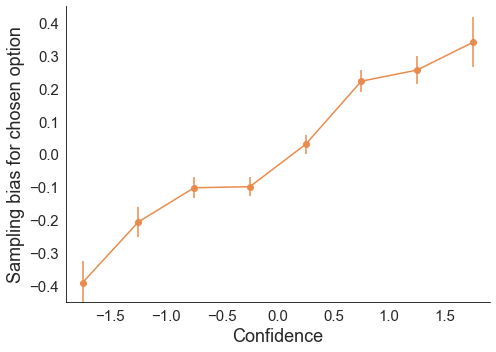

In [47]:
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
    #run the classifier
clf = sklearn.linear_model.LinearRegression()
logit1 = []
fig = figure(figsize=(7,5))
# fig.suptitle('Change of Mind and Sampling Bias', fontsize = 18)
plot = fig.add_subplot(1,1,1)
X_test = np.linspace(0,1,300)

mean_prob_choice = []
errors = []
bins = np.linspace(-1.75,1.75,8)
for y in bins:
    mean_prob_choice.append(mean(Data1[Data1['Conf_bin']==y]['ZBias']))
    errors.append(stats.sem(Data1[Data1['Conf_bin']==y]['ZBias']))
plot.errorbar(bins, mean_prob_choice, yerr=errors, fmt='-o', color='#EA8B4C')

plot.set_xlabel('Confidence', size=18)
plot.set_ylabel('Sampling bias for chosen option', size=18)
plot.set_xlim(-1.9, 1.9)
plot.set_ylim(-0.45, 0.45)
plot.tick_params(axis='both', which='major', labelsize=15)

#sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
plt.subplots_adjust(top=0.9, left=0.1)
plt.tight_layout()



<a id=Figure2B></a>

### Figure 2B

In [11]:
%%R
require("optimx")   ## for optim optimizers
require("nloptr")
nlminbw   <- lme4:::nlminbwrap

R[write to console]: Loading required package: nloptr



In [19]:
# create choice variable 0=right, 1=left
Data1['Choice']=[1 if x =='left' else 0 for x in Data1['Response1']]

In [20]:
Data1['Conf_bin']=Data1['Conf_bin'].astype('float')

In [74]:
# load data in R
# import new dataframe into R
r_df = pandas2ri.py2rpy(Data1)
%R -i r_df

In [19]:
# fit hierarchical regression model predicting sampling bias as a function of choice, dot difference and confidence rating
%R sampling_model1 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | Participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
%R print(summary(sampling_model1))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14159.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3463 -0.6178 -0.0116  0.6362  4.6527 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 Participant (Intercept)   0.0189544 0.13767                         
             Choice        0.0603223 0.24561  -0.96                  
             NonAbsDiff    0.0002879 0.01697  -0.22  0.18            
             ZConf1        0.0129680 0.11388   0.25 -0.40 -0.49      
             Choice:ZConf1 0.0207155 0.14393  -0.43  0.61  0.50 -0.89
 Residual                  0.7153908 0.84581                         
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
               Estim

In [20]:
%%R
# correct p-values (needed for hierarchical linear regressions)
df.KR <- get_ddf_Lb(sampling_model1, fixef(sampling_model1))
df.KR

[1] 26.95889


In [35]:
%%R
coefs <- data.frame(coef(summary(sampling_model1)))
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))
coefs

                 Estimate  Std..Error   t.value         p.KR
(Intercept)   -0.26801253 0.031592043 -8.483545 1.649555e-07
Choice         0.51152233 0.053052252  9.641859 2.679567e-08
NonAbsDiff     0.05190484 0.003984211 13.027632 2.903335e-10
ZConf1        -0.07975345 0.027700875 -2.879095 1.042777e-02
Choice:ZConf1  0.19047765 0.036230828  5.257336 6.457043e-05


In [64]:
# get subject-level coefficients from regression
%R coefs <- coef(sampling_model1)$Participant;
%R -o coefs

In [65]:
## add subject column
coefs['subject']=subjects1

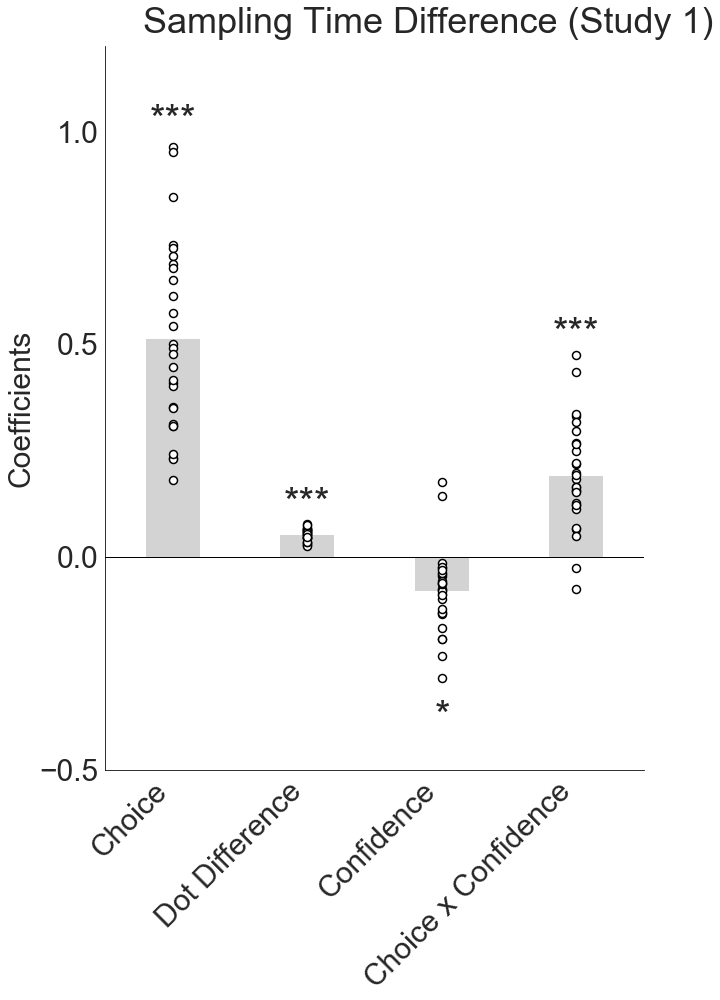

In [69]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2, 3]
y_mean = [mean(coefs['Choice']), mean(coefs['NonAbsDiff']), mean(coefs['ZConf1']), mean(coefs['Choice:ZConf1'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects1: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['Choice'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['NonAbsDiff'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(3, coefs[coefs['subject']==subject]['Choice:ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_xlim([-0.5,3.5])
ax.set_ylim([-0.5,1.2])

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Sampling Time Difference (Study 1)", fontsize=36)
ttl = ax.title
ttl.set_position([0.6, 1.01])
ax.set_xticks((np.arange(4)))
yticks = np.arange(-0.5, 1.2, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(("Choice", "Dot Difference", "Confidence", "Choice x Confidence"), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('***', xy=(0,1), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(1,0.1), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('*', xy=(2.005,-0.4), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(3,0.5), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()
plt.savefig('Fig2B.pdf')

<a id=Figure2C></a>

<a id=Figure2C></a>

### Figure 2C

In [21]:
## define sampling bias as chosen-unchosen time
Data1['SamplingBias']=Data1['ChosenTime']-Data1['UnchosenTime']

In [22]:
# create new index for z-scoring
new_index=range(len(Data1))
Data1['index']=new_index
Data1['participant']=Data1['Participant'] # create copy of participant column
Data1 = Data1.set_index(['Participant', 'index'])

In [23]:
## z-score sampling bias
Data1.head()
Data1['ZBias'] = (Data1['SamplingBias']-Data1.groupby(level='Participant')['SamplingBias'].mean())/Data1.groupby(level = 'Participant')['SamplingBias'].std()
# Are the mean Z-scores all close to 0?
Data1.groupby(level=0)['ZBias'].mean()


Participant
1    -6.772360e-17
2     2.420286e-16
3    -3.619327e-16
4    -2.664535e-17
5     1.110223e-18
6     1.060263e-16
7    -1.432188e-16
8     3.139156e-16
9     2.686740e-16
10   -3.552714e-17
11    6.439294e-17
12   -8.326673e-17
13    3.663736e-17
14   -9.436896e-17
16    2.817191e-16
17   -6.800116e-17
18    8.104628e-17
19    2.914335e-17
20   -3.871903e-17
21   -2.645106e-16
22    6.428191e-16
23    1.282308e-16
24    1.193490e-17
25   -2.109077e-16
26   -3.405609e-16
27   -2.386980e-16
29    1.765255e-16
30    5.939693e-17
Name: ZBias, dtype: float64

In [24]:
# square dot difference (fewer convergence issues)
Data1['DDsqrt']=sqrt(Data1['DotDifference'])

In [73]:
# load data into R
r_df = pandas2ri.py2ri(Data1)
%R -i r_df
%R r_df['Change']=r_df['Change'][,1]

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Conf_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


array([1, 1, 0, ..., 0, 0, 1], dtype=int32)

In [74]:
# fit logistic regression model predicting change of mind as a function of dot difference, sampling bias and confidence
%R changemodel1 = glmer(Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
%R print(summary(changemodel1))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 |  
    participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4668.0   4760.8  -2320.0   4640.0     5586 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9698 -0.4983 -0.2696 -0.0795 10.4281 

Random effects:
 Groups      Name        Variance Std.Dev. Corr             
 participant (Intercept) 0.311488 0.5581                    
             DDsqrt      0.001005 0.0317   -1.00            
             ZBias       0.284694 0.5336    0.02 -0.02      
             ZConf1      0.046305 0.2152    0.45 -0.45 -0.16
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.17566    0.20793  -5.654 1.57e-08 ***
DDsqrt      -0.2396

In [99]:
# get subject-level coefficients from regression
%R coefs <- coef(changemodel1)$participant;
%R -o coefs

In [100]:
## add subject column
coefs['subject']=subjects1

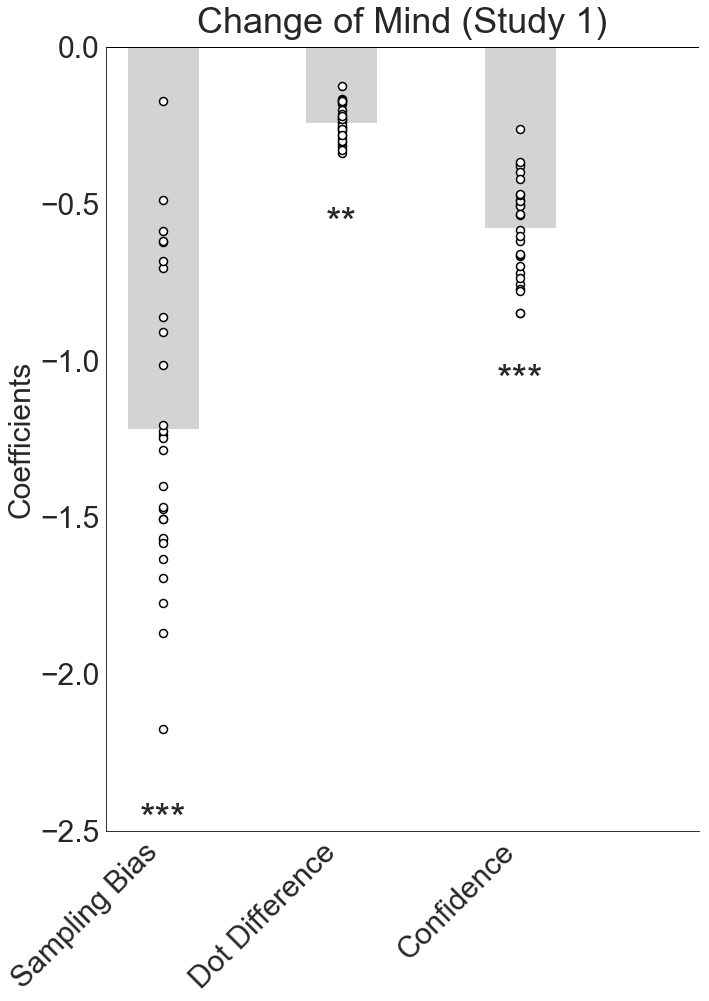

In [103]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2]
y_mean = [mean(coefs['ZBias']), mean(coefs['DDsqrt']), mean(coefs['ZConf1'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects1: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['ZBias'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['DDsqrt'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Change of Mind (Study 1)", fontsize=36)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(4)))
yticks = np.arange(-2.5, 0.5, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(('Sampling Bias', 'Dot Difference', 'Confidence'), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('***', xy=(0,-2.5), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('**', xy=(1,-0.6), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(2,-1.1), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()


<a id=Figure2sup1></a>

### Figure 2-figure supplement 1

In [40]:
from pymer4.models import Lmer

/Users/paulak/anaconda3/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/Users/paulak/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2054: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


In [76]:
Data1.columns

Index(['Participant', 'Trial', 'Correct1', 'CorrectKey', 'Response1', 'RT1',
       'DotDifference', 'DotNumberRight', 'DotNumberLeft', 'Conf1', 'Conf1_RT',
       'CipResponse', 'CipRT', 'Correct2', 'Response2', 'RT2', 'Conf2',
       'Conf2_RT', 'ZConf1', 'ZConf2', 'Switch', 'ZSwitch', 'ZDifficult',
       'Block', 'NonAbsDiff', 'ZNonAbsDiff', 'LeftTime', 'RightTime',
       'ChosenTime', 'UnchosenTime', 'Change', 'Type', 'DeltaSampling',
       'ZDeltaSampling', 'ConfChange', 'Left1', 'Left2', 'Conf_bin',
       'SamplingDiff', 'ZBias', 'Choice', 'Conf1_bin'],
      dtype='object')

In [77]:
Data2Free.columns

Index(['participant', 'Trial', 'Block', 'RT1', 'RT2', 'Conf1', 'Conf2',
       'Correct1', 'Correct2', 'Conf1_RT', 'Conf2_RT', 'DotNumberLeft',
       'DotNumberRight', 'DotDifference', 'Switch', 'Left_Presentation_Time',
       'Right_Presentation_Time', 'LeftTime', 'RightTime', 'NonAbsDiff',
       'Response1', 'Response2', 'ZConf1', 'ZConf2', 'Zdifficult',
       'ZNonAbsDiff', 'SamplingLength', 'Session', 'Type', 'ZSwitch',
       'DeltaSampling', 'ZDeltaSampling', 'ChosenTime', 'UnchosenTime',
       'Chosen_Presentation_Time', 'Unchosen_Presentation_Time', 'ConfChange',
       'Left_IA_First_Dwell_Time', 'Right_IA_First_Dwell_Time',
       'LeftTime_First', 'RightTime_First', 'Internal_Saccades'],
      dtype='object')

In [26]:
Data2Free['SamplingDiff']=Data2Free['ChosenTime']-Data2Free['UnchosenTime']

In [27]:
Data2Free["ZDSampTChosen"] = z_score1(Data2Free,'participant',"SamplingDiff")

In [28]:
Data2Free['ZDifficult']=Data2Free['Zdifficult']

Data1['ChgMind']=[0 if (x =='Correct, no change' or x =='Incorrect, no change')  else 1 for x in Data1['Type']]
Data2Free['ChgMind']=[0 if (x =='Correct, no change' or x =='Incorrect, no change')  else 1 for x in Data2Free['Type']]


In [29]:
Data2Free['Participant']=Data2Free['participant']

In [89]:
# define regression model
regFormula1 = "ZConf2 ~   ZDSampTChosen + ZDifficult + ChgMind + ZDSampTChosen:ChgMind +(ZDSampTChosen + ZDifficult + ChgMind + ZDSampTChosen:ChgMind |Participant) "

model1 = Lmer(regFormula1, data=Data1)
model2 = Lmer(regFormula1, data=Data2Free)

In [95]:
# run models
model1.fit()
model2.fit()

boundary (singular) fit: see ?isSingular 

Formula: ZConf2~ZDSampTChosen+ZDifficult+ChgMind+ZDSampTChosen:ChgMind+(ZDSampTChosen+ZDifficult+ChgMind+ZDSampTChosen:ChgMind|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 5600	 Groups: {'Participant': 28.0}

Log-likelihood: -7461.199 	 AIC: 14922.398

Random effects:

                              Name    Var    Std
Participant            (Intercept)  0.005  0.071
Participant          ZDSampTChosen  0.023  0.152
Participant             ZDifficult  0.003  0.059
Participant                ChgMind  0.077  0.277
Participant  ZDSampTChosen:ChgMind  0.073  0.270
Residual                            0.820  0.905

                       IV1                    IV2   Corr
Participant    (Intercept)          ZDSampTChosen -1.000
Participant    (Intercept)             ZDifficult -0.140
Participant    (Intercept)                ChgMind -0.527
Participant    (Intercept)  ZDSampTChosen:ChgMind  0.479
Participant  ZDSampTChos

Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  \
(Intercept)               0.112   0.064    0.160  0.025  29.218   4.531   
ZDSampTChosen             0.174   0.115    0.234  0.030  17.029   5.785   
ZDifficult                0.126   0.043    0.209  0.042  16.833   2.966   
ChgMind                  -0.572  -0.754   -0.390  0.093  16.177  -6.159   
ZDSampTChosen:ChgMind    -0.210  -0.314   -0.106  0.053  24.546  -3.963   

                       P-val  Sig  
(Intercept)            0.000  ***  
ZDSampTChosen          0.000  ***  
ZDifficult             0.009   **  
ChgMind                0.000  ***  
ZDSampTChosen:ChgMind  0.001  ***

In [96]:
table_data1 = model1.coefs.T
table_data2 = model2.coefs.T

par_table_data1 = model1.fixef
par_table_data2 = model2.fixef

In [102]:
table_data1

(Intercept) ZDSampTChosen   ZDifficult      ChgMind  \
Estimate   0.0382952      0.304421      0.11659     -0.68136   
2.5_ci   -0.00033164      0.240918    0.0840649    -0.809612   
97.5_ci    0.0769219      0.367924     0.149116    -0.553108   
SE         0.0197079     0.0324001     0.016595    0.0654359   
DF           31.7994       26.0013      27.1388      23.6674   
T-stat       1.94314       9.39568      7.02564     -10.4126   
P-val      0.0608969    7.6341e-10  1.44993e-07  2.58859e-10   
Sig                .           ***          ***          ***   

         ZDSampTChosen:ChgMind  
Estimate             -0.640304  
2.5_ci               -0.763257  
97.5_ci              -0.517352  
SE                   0.0627321  
DF                     24.4633  
T-stat                 -10.207  
P-val              2.67752e-10  
Sig                        ***

In [103]:
table_data2

(Intercept) ZDSampTChosen  ZDifficult      ChgMind  \
Estimate     0.111927      0.174425    0.125896    -0.571597   
2.5_ci      0.0635095      0.115332   0.0427073    -0.753505   
97.5_ci      0.160345      0.233519    0.209084    -0.389688   
SE          0.0247034     0.0301503   0.0424439    0.0928122   
DF            29.2176       17.0288      16.833      16.1771   
T-stat        4.53085        5.7852     2.96617     -6.15864   
P-val     9.18876e-05   2.18165e-05  0.00872607  1.30926e-05   
Sig               ***           ***          **          ***   

         ZDSampTChosen:ChgMind  
Estimate             -0.210208  
2.5_ci               -0.314169  
97.5_ci              -0.106247  
SE                   0.0530422  
DF                     24.5463  
T-stat                -3.96303  
P-val              0.000559549  
Sig                        ***

([<matplotlib.axis.XTick at 0x7fa41e248610>,
 [Text(1.25, 0, '(Inter)'),
  Text(2.25, 0, 'Sampling Bias Chosen'),
  Text(3.25, 0, '|ΔDots|'),
  Text(4.25, 0, 'ChangeMind'),
  Text(5.25, 0, 'SampBiasX \n ChangeMind')])

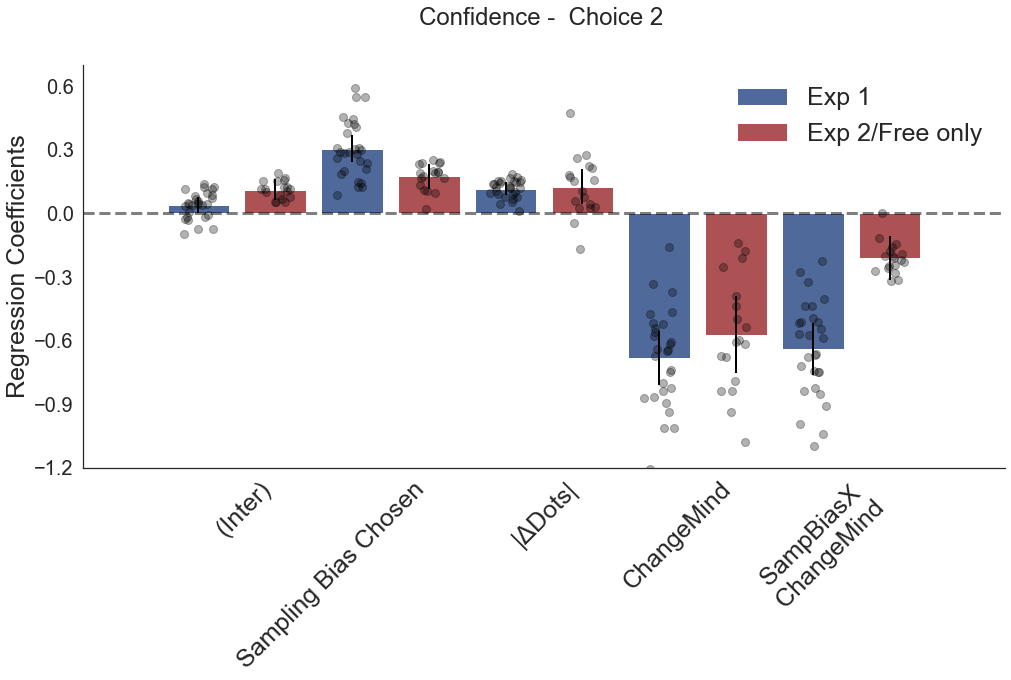

In [101]:
Coefpresplot_bar2(table_data1, par_table_data1,table_data2, par_table_data2, barcol1='#4F6A9A',barcol2='#AC5255', 
                  title='Confidence -  Choice 2 ', size='big',ymultiple=0.3, ticklabsize=20,labels= ['Exp 1','Exp 2/Free only'])

plt.xticks([1.25,2.25,3.25,4.25,5.25],['(Inter)','Sampling Bias Chosen','|ΔDots|','ChangeMind','SampBiasX \n ChangeMind'], rotation=45)



<a id=Figure3B></a>

### Figure 3B

In [32]:
# make new dummy variable encoding whether or not a left response was made for both choices
Data2['Left1'] = [1 if x == 'left' else 0 for x in Data2['Response1']]
Data2['Left2'] = [1 if x == 'left' else 0 for x in Data2['Response2']]

/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:1

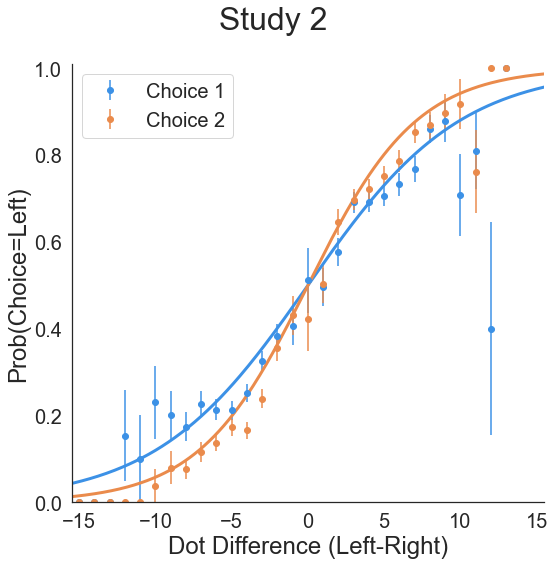

In [105]:
fig=figure(figsize=(8,8))
fig.suptitle('Study 2', fontsize = 32)
logistic_regression(subjects2, Data2)
plt.savefig('Fig3B.pdf')

<a id=Figure3C></a>

### Figure 3C

In [33]:
# calculate proportion of sampling time spent on chosen and unchosen options
Data2Free['ChosenPercTime'] = Data2Free['ChosenTime']/Data2Free['SamplingLength']
Data2Free['UnchosenPercTime'] = Data2Free['UnchosenTime']/Data2Free['SamplingLength']

In [34]:
# make new dataframe for figure 1C
DF2=pd.DataFrame(data=[])
DF2['subject']=subjects2
DF2['ChosenTime']= [float(mean(Data2Free[Data2Free['participant']==x]['ChosenPercTime'])) for x in DF2['subject']]
DF2['UnchosenTime']=[float(mean(Data2Free[Data2Free['participant']==x]['UnchosenPercTime'])) for x in DF2['subject']]



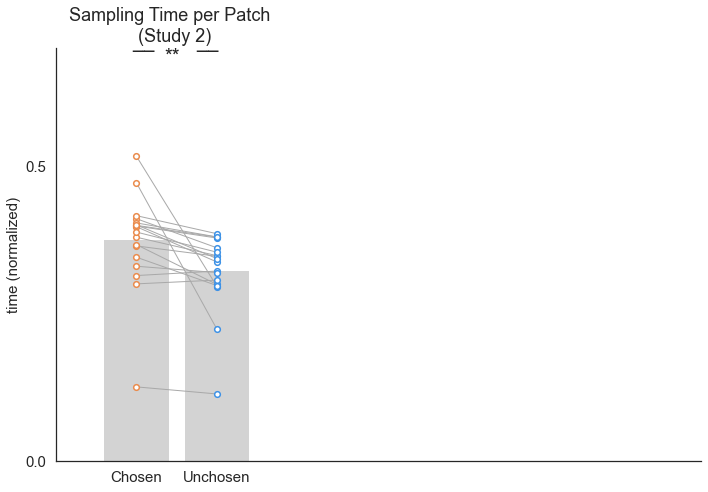

In [108]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(DF2['ChosenTime']), mean(DF2['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[DF2['subject']==subject]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[DF2['subject']==subject]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    x = [0, 1]
    y = [DF2[DF2['subject']==subject]['ChosenTime'].iloc[0], DF2[DF2['subject']==subject]['UnchosenTime'].iloc[0]]
    ax.plot(x, y, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,7])
ax.set_ylim([-0.001,0.7])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time (normalized)", fontsize=15)
ax.set_title("Sampling Time per Patch \n (Study 2)", fontsize=18)
ttl = ax.title
ttl.set_position([0.18, 1.01])
ax.set_xticks((np.arange(2)))
yticks = np.arange(0, 0.7, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen"), fontsize=15)
#ax.set_axis_bgcolor('white')

#sns.set_style('white', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

ax.annotate('**', xy=(0.35,0.675), xycoords='data', fontsize=20)
            #xy=(0, 1), xycoords='data',
            #xytext=(-50, 30), textcoords='offset points',
            #arrowprops=dict(arrowstyle="->"))
            
ax.annotate('__', xy=(-0.05,0.70), xycoords='data', fontsize=20)
            #xy=(0, 1), xycoords='data',
            #xytext=(-50, 30), textcoords='offset points',
            #arrowprops=dict(arrowstyle="->"))
            
ax.annotate('__', xy=(0.745,0.70), xycoords='data', fontsize=20)
            #xy=(0, 1), xycoords='data',
            #xytext=(-50, 30), textcoords='offset points',
            #arrowprops=dict(arrowstyle="->"))

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()


<a id=tACCStudy2></a>

### T-test Accuracy Study 2

In [109]:
DF2['Correct1']=[float(mean(Data2[Data2['participant']==x]['Correct1'])) for x in DF2['subject']]
DF2['Correct2']=[float(mean(Data2[Data2['participant']==x]['Correct2'])) for x in DF2['subject']]

In [110]:
sp.stats.ttest_rel(DF2['Correct1'],DF2['Correct2'])

Ttest_relResult(statistic=-7.140839930733507, pvalue=1.6535371024436757e-06)

<a id=tFigure3C></a>

### T-test Figure 3C

In [111]:
sp.stats.ttest_rel(DF2['ChosenTime'],DF2['UnchosenTime'])

Ttest_relResult(statistic=3.1642762349979305, pvalue=0.0056665252371096144)

<a id=Figure3sup1></a>

### Figure 3-figure supplement 1

In [35]:
# grab raw data (as this incl. shortest sampling trials)
Data2Free_raw=pd.read_csv('../data/rawdata_exp2_free.csv')
Data2Fixed_raw=pd.read_csv('../data/rawdata_exp2_fixed.csv')

In [36]:
Data2_raw=pd.concat([Data2Free_raw,Data2Fixed_raw])

In [37]:
Data2_raw['length_fixed']=Data2_raw['LEFT_PRESENTATION_TIME']+Data2_raw['RIGHT_PRESENTATION_TIME']

In [38]:
Data2_raw['left_pres_longer']=[1 if Data2_raw['LEFT_PRESENTATION_TIME_REV'].iloc[row]>Data2_raw['RIGHT_PRESENTATION_TIME_REV'].iloc[row] else 0 for row in range(len(Data2_raw))]
Data2_raw['right_pres_longer']=[1 if Data2_raw['LEFT_PRESENTATION_TIME_REV'].iloc[row]<Data2_raw['RIGHT_PRESENTATION_TIME_REV'].iloc[row] else 0 for row in range(len(Data2_raw))]
Data2_raw['same_pres']=[1 if Data2_raw['LEFT_PRESENTATION_TIME_REV'].iloc[row]==Data2_raw['RIGHT_PRESENTATION_TIME_REV'].iloc[row] else 0 for row in range(len(Data2_raw))]



In [39]:
Data2_raw['chosenleft_longer']=[1 if ((Data2_raw['left_pres_longer'].iloc[row]==1) & (Data2_raw['PICKED_LEFT_1'].iloc[row]==1)) else 0 for row in range(len(Data2_raw))]
Data2_raw['chosenright_longer']=[1 if ((Data2_raw['right_pres_longer'].iloc[row]==1) & (Data2_raw['PICKED_LEFT_1'].iloc[row]==0)) else 0 for row in range(len(Data2_raw))]
Data2_raw['chosen_longer']=Data2_raw['chosenleft_longer']+Data2_raw['chosenright_longer']

Data2_raw['unchosenleft_longer']=[1 if ((Data2_raw['left_pres_longer'].iloc[row]==1) & (Data2_raw['PICKED_LEFT_1'].iloc[row]==0)) else 0 for row in range(len(Data2_raw))]
Data2_raw['unchosenright_longer']=[1 if ((Data2_raw['right_pres_longer'].iloc[row]==1) & (Data2_raw['PICKED_LEFT_1'].iloc[row]==1)) else 0 for row in range(len(Data2_raw))]
Data2_raw['unchosen_longer']=Data2_raw['unchosenleft_longer']+Data2_raw['unchosenright_longer']



In [40]:
Data2_free_short = Data2_raw[Data2_raw['sampling_time']==3000]
Data2_free_medium = Data2_raw[Data2_raw['sampling_time']==5000]
Data2_free_long = Data2_raw[Data2_raw['sampling_time']==7000]

Data2_fixed_short = Data2_raw[Data2_raw['length_fixed']==3000]
Data2_fixed_medium = Data2_raw[Data2_raw['length_fixed']==5000]
Data2_fixed_long = Data2_raw[Data2_raw['length_fixed']==7000]

#### 3000ms sampling time

In [121]:
# sampling time variable for chosen and unchosen patch
Data2_free_short['Chosen-Time'] = [Data2_free_short['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_short['PICKED_LEFT_1'].iloc[row]==True else Data2_free_short['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_short))]
Data2_free_short['Unchosen-Time'] = [Data2_free_short['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_short['PICKED_LEFT_1'].iloc[row]==False else Data2_free_short['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_short))]

Data2_fixed_short['Chosen-Time'] = [Data2_fixed_short['Left_Gazetime_New'].iloc[row] if Data2_fixed_short['PICKED_LEFT_1'].iloc[row]==True else Data2_fixed_short['Right_Gazetime_New'].iloc[row] for row in range(len(Data2_fixed_short))]
Data2_fixed_short['Unchosen-Time'] = [Data2_fixed_short['Left_Gazetime_New'].iloc[row] if Data2_fixed_short['PICKED_LEFT_1'].iloc[row]==False else Data2_fixed_short['Right_Gazetime_New'].iloc[row] for row in range(len(Data2_fixed_short))]




<ipython-input-121-506eece76e5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_free_short['Chosen-Time'] = [Data2_free_short['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_short['PICKED_LEFT_1'].iloc[row]==True else Data2_free_short['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_short))]
<ipython-input-121-506eece76e5d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_free_short['Unchosen-Time'] = [Data2_free_short['Left_IA_Second_Dwell_Time'].iloc[row] if Data2

In [122]:
# make new dataframe for figure
DF2=pd.DataFrame(data=[])
DF2['subject']=np.repeat(subjects2,4)
DF2['session']=np.tile(['Free','Fixed_Chosen_Longer', 'Fixed_Unchosen_Longer', 'Fixed_Same'],len(subjects2))
for row in range(len(DF2)):
    if DF2.loc[row,'session']=='Free':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_free_short[Data2_free_short['Participant']==DF2['subject'].iloc[row]]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_free_short[Data2_free_short['Participant']==DF2['subject'].iloc[row]]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Chosen_Longer':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_short[(Data2_fixed_short['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_short['chosen_longer']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_short[(Data2_fixed_short['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_short['chosen_longer']==1)]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Unchosen_Longer':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_short[(Data2_fixed_short['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_short['unchosen_longer']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_short[(Data2_fixed_short['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_short['unchosen_longer']==1)]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Same':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_short[(Data2_fixed_short['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_short['same_pres']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_short[(Data2_fixed_short['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_short['same_pres']==1)]['Unchosen-Time']))



In [123]:
# do t-test free sampling
sp.stats.ttest_rel(DF2[DF2['session']=='Free']['ChosenTime'],DF2[DF2['session']=='Free']['UnchosenTime'])


Ttest_relResult(statistic=2.928524646579678, pvalue=0.009377648461370625)

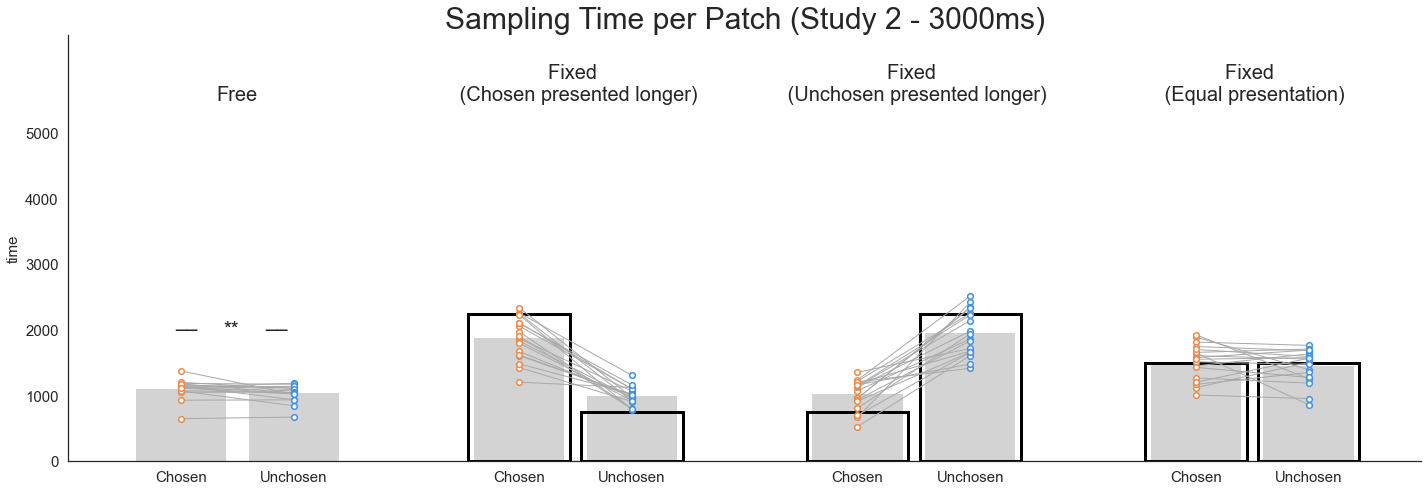

In [124]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 3, 4, 6, 7, 9, 10]
y_mean = [mean(DF2[DF2['session']=='Free']['ChosenTime']), mean(DF2[DF2['session']=='Free']['UnchosenTime']), 
         mean(DF2[DF2['session']=='Fixed_Chosen_Longer']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Chosen_Longer']['UnchosenTime']),
          mean(DF2[DF2['session']=='Fixed_Unchosen_Longer']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Unchosen_Longer']['UnchosenTime']),
          mean(DF2[DF2['session']=='Fixed_Same']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Same']['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(3, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(4, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(6, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(7, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(9, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(10, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    a = [0, 1]
    b = [DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['UnchosenTime'].iloc[0]]
    ax.plot(a, b, color='#A9A9A9', lw=1)
    c = [3, 4]
    d = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['UnchosenTime'].iloc[0]]
    ax.plot(c, d, color='#A9A9A9', lw=1)
    e = [6, 7]
    f = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['UnchosenTime'].iloc[0]]
    ax.plot(e, f, color='#A9A9A9', lw=1)
    g = [9, 10]
    h = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['UnchosenTime'].iloc[0]]
    ax.plot(g, h, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,11])
ax.set_ylim([-0.001,6500])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time", fontsize=15)
ax.set_title("Sampling Time per Patch (Study 2 - 3000ms)", fontsize=30, ha='center')
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(11)))
yticks = np.arange(0, 6000, 1000)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen", "", "Chosen", "Unchosen", "", "Chosen", "Unchosen", "", "Chosen", "Unchosen"), fontsize=15)

ax.annotate('Free', xy=(0.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Chosen presented longer)', xy=(3.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Unchosen presented longer)', xy=(6.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Equal presentation)', xy=(9.5, 5500), xycoords='data', fontsize=20,ha='center')



ax.annotate('**', xy=(0.38,1920), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,2050), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,2050), xycoords='data', fontsize=20)


ax.add_patch(Rectangle((2.55, 0), 0.9, 2250,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((3.55, 0), 0.9, 750,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((5.55, 0), 0.9, 750,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((6.55, 0), 0.9, 2250,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((8.55, 0), 0.9, 1500,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((9.55, 0), 0.9, 1500,
             edgecolor = 'black',
             fill=False,
             lw=3))

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
# savefig('sampling_study2_3000.pdf')




#### 5000ms sampling time

In [125]:
# sampling time variable for chosen and unchosen patch
Data2_free_medium['Chosen-Time'] = [Data2_free_medium['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_medium['PICKED_LEFT_1'].iloc[row]==True else Data2_free_medium['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_medium))]
Data2_free_medium['Unchosen-Time'] = [Data2_free_medium['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_medium['PICKED_LEFT_1'].iloc[row]==False else Data2_free_medium['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_medium))]

Data2_fixed_medium['Chosen-Time'] = [Data2_fixed_medium['Left_Gazetime_New'].iloc[row] if Data2_fixed_medium['PICKED_LEFT_1'].iloc[row]==True else Data2_fixed_medium['Right_Gazetime_New'].iloc[row] for row in range(len(Data2_fixed_medium))]
Data2_fixed_medium['Unchosen-Time'] = [Data2_fixed_medium['Left_Gazetime_New'].iloc[row] if Data2_fixed_medium['PICKED_LEFT_1'].iloc[row]==False else Data2_fixed_medium['Right_Gazetime_New'].iloc[row] for row in range(len(Data2_fixed_medium))]




<ipython-input-125-cc0be3b8239b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_free_medium['Chosen-Time'] = [Data2_free_medium['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_medium['PICKED_LEFT_1'].iloc[row]==True else Data2_free_medium['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_medium))]
<ipython-input-125-cc0be3b8239b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_free_medium['Unchosen-Time'] = [Data2_free_medium['Left_IA_Second_Dwell_Time'].iloc[row] i

In [126]:

# make new dataframe for figure
DF2=pd.DataFrame(data=[])
DF2['subject']=np.repeat(subjects2,4)
DF2['session']=np.tile(['Free','Fixed_Chosen_Longer', 'Fixed_Unchosen_Longer', 'Fixed_Same'],len(subjects2))
for row in range(len(DF2)):
    if DF2.loc[row,'session']=='Free':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_free_medium[Data2_free_medium['Participant']==DF2['subject'].iloc[row]]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_free_medium[Data2_free_medium['Participant']==DF2['subject'].iloc[row]]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Chosen_Longer':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_medium[(Data2_fixed_medium['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_medium['chosen_longer']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_medium[(Data2_fixed_medium['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_medium['chosen_longer']==1)]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Unchosen_Longer':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_medium[(Data2_fixed_medium['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_medium['unchosen_longer']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_medium[(Data2_fixed_medium['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_medium['unchosen_longer']==1)]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Same':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_medium[(Data2_fixed_medium['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_medium['same_pres']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_medium[(Data2_fixed_medium['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_medium['same_pres']==1)]['Unchosen-Time']))





In [127]:
# do t-test free sampling
sp.stats.ttest_rel(DF2[DF2['session']=='Free']['ChosenTime'],DF2[DF2['session']=='Free']['UnchosenTime'])

Ttest_relResult(statistic=3.496837482071988, pvalue=0.002762924310399708)

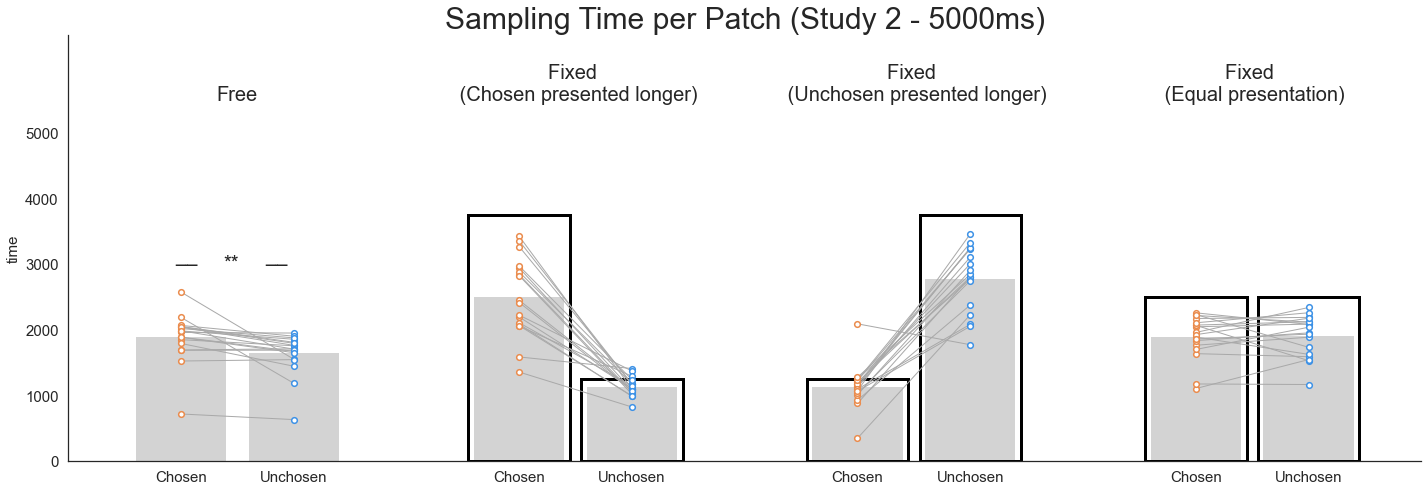

In [128]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 3, 4, 6, 7, 9, 10]
y_mean = [mean(DF2[DF2['session']=='Free']['ChosenTime']), mean(DF2[DF2['session']=='Free']['UnchosenTime']), 
         mean(DF2[DF2['session']=='Fixed_Chosen_Longer']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Chosen_Longer']['UnchosenTime']),
          mean(DF2[DF2['session']=='Fixed_Unchosen_Longer']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Unchosen_Longer']['UnchosenTime']),
          mean(DF2[DF2['session']=='Fixed_Same']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Same']['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(3, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(4, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(6, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(7, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(9, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(10, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    a = [0, 1]
    b = [DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['UnchosenTime'].iloc[0]]
    ax.plot(a, b, color='#A9A9A9', lw=1)
    c = [3, 4]
    d = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['UnchosenTime'].iloc[0]]
    ax.plot(c, d, color='#A9A9A9', lw=1)
    e = [6, 7]
    f = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['UnchosenTime'].iloc[0]]
    ax.plot(e, f, color='#A9A9A9', lw=1)
    g = [9, 10]
    h = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['UnchosenTime'].iloc[0]]
    ax.plot(g, h, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,11])
ax.set_ylim([-0.001,6500])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time", fontsize=15)
ax.set_title("Sampling Time per Patch (Study 2 - 5000ms)", fontsize=30, ha='center')
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(11)))
yticks = np.arange(0, 6000, 1000)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen", "", "Chosen", "Unchosen", "", "Chosen", "Unchosen", "", "Chosen", "Unchosen"), fontsize=15)

ax.annotate('Free', xy=(0.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Chosen presented longer)', xy=(3.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Unchosen presented longer)', xy=(6.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Equal presentation)', xy=(9.5, 5500), xycoords='data', fontsize=20,ha='center')



ax.annotate('**', xy=(0.38,2920), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,3050), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,3050), xycoords='data', fontsize=20)

ax.add_patch(Rectangle((2.55, 0), 0.9, 3750,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((3.55, 0), 0.9, 1250,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((5.55, 0), 0.9, 1250,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((6.55, 0), 0.9, 3750,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((8.55, 0), 0.9, 2500,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((9.55, 0), 0.9, 2500,
             edgecolor = 'black',
             fill=False,
             lw=3))

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
# savefig('sampling_study2_5000.pdf')





#### 7000ms sampling time

In [129]:
# sampling time variable for chosen and unchosen patch
Data2_free_long['Chosen-Time'] = [Data2_free_long['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_long['PICKED_LEFT_1'].iloc[row]==True else Data2_free_long['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_long))]
Data2_free_long['Unchosen-Time'] = [Data2_free_long['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_long['PICKED_LEFT_1'].iloc[row]==False else Data2_free_long['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_long))]

Data2_fixed_long['Chosen-Time'] = [Data2_fixed_long['Left_Gazetime_New'].iloc[row] if Data2_fixed_long['PICKED_LEFT_1'].iloc[row]==True else Data2_fixed_long['Right_Gazetime_New'].iloc[row] for row in range(len(Data2_fixed_long))]
Data2_fixed_long['Unchosen-Time'] = [Data2_fixed_long['Left_Gazetime_New'].iloc[row] if Data2_fixed_long['PICKED_LEFT_1'].iloc[row]==False else Data2_fixed_long['Right_Gazetime_New'].iloc[row] for row in range(len(Data2_fixed_long))]




<ipython-input-129-2fb4ec448c9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_free_long['Chosen-Time'] = [Data2_free_long['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_long['PICKED_LEFT_1'].iloc[row]==True else Data2_free_long['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_free_long))]
<ipython-input-129-2fb4ec448c9a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_free_long['Unchosen-Time'] = [Data2_free_long['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_free_l

In [130]:

# make new dataframe for figure
DF2=pd.DataFrame(data=[])
DF2['subject']=np.repeat(subjects2,4)
DF2['session']=np.tile(['Free','Fixed_Chosen_Longer', 'Fixed_Unchosen_Longer', 'Fixed_Same'],len(subjects2))
for row in range(len(DF2)):
    if DF2.loc[row,'session']=='Free':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_free_long[Data2_free_long['Participant']==DF2['subject'].iloc[row]]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_free_long[Data2_free_long['Participant']==DF2['subject'].iloc[row]]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Chosen_Longer':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_long[(Data2_fixed_long['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_long['chosen_longer']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_long[(Data2_fixed_long['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_long['chosen_longer']==1)]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Unchosen_Longer':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_long[(Data2_fixed_long['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_long['unchosen_longer']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_long[(Data2_fixed_long['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_long['unchosen_longer']==1)]['Unchosen-Time']))
    elif DF2.loc[row,'session']=='Fixed_Same':
        DF2.loc[row,'ChosenTime']=float(mean(Data2_fixed_long[(Data2_fixed_long['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_long['same_pres']==1)]['Chosen-Time']))
        DF2.loc[row,'UnchosenTime']=float(mean(Data2_fixed_long[(Data2_fixed_long['Participant']==DF2['subject'].iloc[row]) & (Data2_fixed_long['same_pres']==1)]['Unchosen-Time']))







In [131]:
# do t-test free sampling
sp.stats.ttest_rel(DF2[DF2['session']=='Free']['ChosenTime'],DF2[DF2['session']=='Free']['UnchosenTime'])

Ttest_relResult(statistic=2.8606931560293667, pvalue=0.010826840008252138)

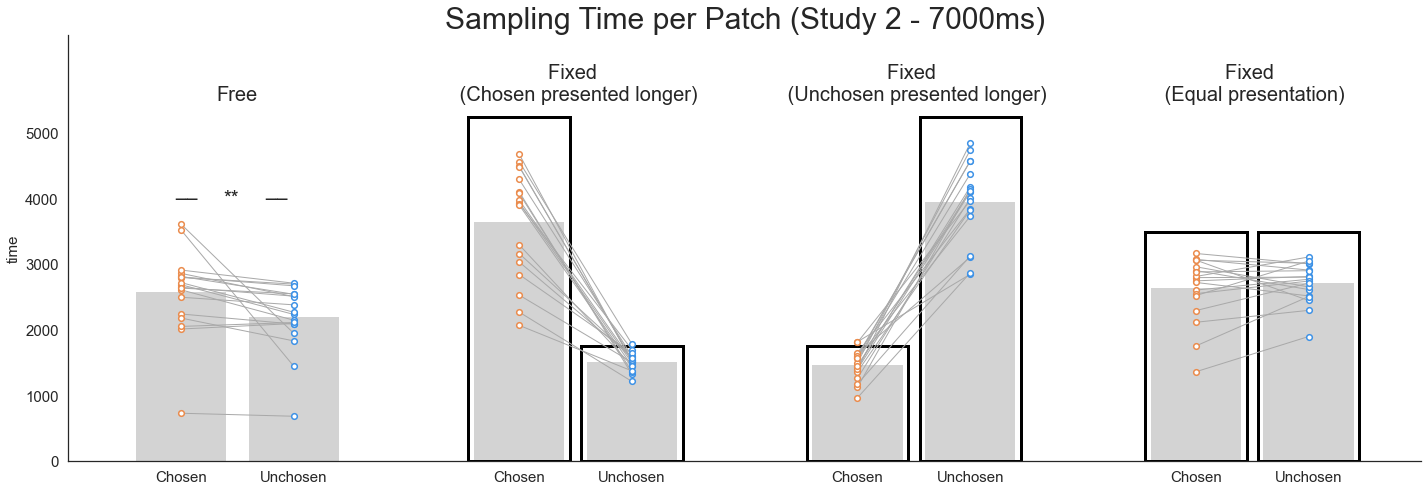

In [132]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 3, 4, 6, 7, 9, 10]
y_mean = [mean(DF2[DF2['session']=='Free']['ChosenTime']), mean(DF2[DF2['session']=='Free']['UnchosenTime']), 
         mean(DF2[DF2['session']=='Fixed_Chosen_Longer']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Chosen_Longer']['UnchosenTime']),
          mean(DF2[DF2['session']=='Fixed_Unchosen_Longer']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Unchosen_Longer']['UnchosenTime']),
          mean(DF2[DF2['session']=='Fixed_Same']['ChosenTime']), mean(DF2[DF2['session']=='Fixed_Same']['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(3, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(4, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(6, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(7, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    ax.scatter(9, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(10, DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    a = [0, 1]
    b = [DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Free')]['UnchosenTime'].iloc[0]]
    ax.plot(a, b, color='#A9A9A9', lw=1)
    c = [3, 4]
    d = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Chosen_Longer')]['UnchosenTime'].iloc[0]]
    ax.plot(c, d, color='#A9A9A9', lw=1)
    e = [6, 7]
    f = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Unchosen_Longer')]['UnchosenTime'].iloc[0]]
    ax.plot(e, f, color='#A9A9A9', lw=1)
    g = [9, 10]
    h = [DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['ChosenTime'].iloc[0], DF2[(DF2['subject']==subject) & (DF2['session']=='Fixed_Same')]['UnchosenTime'].iloc[0]]
    ax.plot(g, h, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,11])
ax.set_ylim([-0.001,6500])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time", fontsize=15)
ax.set_title("Sampling Time per Patch (Study 2 - 7000ms)", fontsize=30, ha='center')
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(11)))
yticks = np.arange(0, 6000, 1000)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen", "", "Chosen", "Unchosen", "", "Chosen", "Unchosen", "", "Chosen", "Unchosen"), fontsize=15)

ax.annotate('Free', xy=(0.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Chosen presented longer)', xy=(3.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Unchosen presented longer)', xy=(6.5, 5500), xycoords='data', fontsize=20,ha='center')
ax.annotate('Fixed \n (Equal presentation)', xy=(9.5, 5500), xycoords='data', fontsize=20,ha='center')

ax.add_patch(Rectangle((2.55, 0), 0.9, 5250,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((3.55, 0), 0.9, 1750,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((5.55, 0), 0.9, 1750,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((6.55, 0), 0.9, 5250,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((8.55, 0), 0.9, 3500,
             edgecolor = 'black',
             fill=False,
             lw=3))
ax.add_patch(Rectangle((9.55, 0), 0.9, 3500,
             edgecolor = 'black',
             fill=False,
             lw=3))

ax.annotate('**', xy=(0.38,3920), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,4050), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,4050), xycoords='data', fontsize=20)

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
# savefig('sampling_study2_7000.pdf')






<a id=Figure4A></a>

### Figure 4A

In [56]:
bins=np.linspace(-2,2,9)
Data2Free['Conf_bin']=pd.cut(Data2Free['ZConf1'],bins,labels=np.linspace(-1.75,1.75,8))

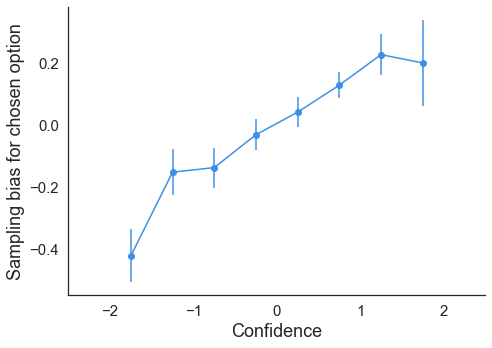

In [137]:
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
    #run the classifier
clf = sklearn.linear_model.LinearRegression()
logit1 = []
fig = figure(figsize=(7,5))
# fig.suptitle('Change of Mind and Sampling Bias', fontsize = 18)
plot = fig.add_subplot(1,1,1)
X_test = np.linspace(0,1,300)

# plot study 1
mean_prob_choice = []
errors = []
bins = np.linspace(-1.75,1.75,8)
for y in bins:
    mean_prob_choice.append(mean(Data2Free[Data2Free['Conf_bin']==y]['ZDSampTChosen']))
    errors.append(stats.sem(Data2Free[Data2Free['Conf_bin']==y]['ZDSampTChosen']))
plot.errorbar(bins, mean_prob_choice, yerr=errors, fmt='-o', color='#3C91E6')

plot.set_xlabel('Confidence', size=18)
plot.set_ylabel('Sampling bias for chosen option', size=18)
plot.set_xlim(-2.5, 2.5)
plot.tick_params(axis='both', which='major', labelsize=15)

#sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
# plot.legend(loc=2, prop={'size':18})
sns.despine(right=True, top=True)
plt.subplots_adjust(top=0.9, left=0.1)
plt.tight_layout()
plt.savefig('Fig4A.pdf')

<a id=Figure4B></a>

### Figure 4B

In [41]:
%%R
require("optimx")   ## for optim optimizers
require("nloptr")
nlminbw   <- lme4:::nlminbwrap

In [42]:
Data2Free['Choice']=[1 if x == 'left' else 0 for x in Data2Free['Response1']]

In [55]:
# load data in R
# import new dataframe into R
r_df = pandas2ri.py2ri(Data2Free)
%R -i r_df

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Conf_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


In [56]:
%%R
# fit hierarchical regression model predicting sampling bias as a function of choice, dot difference and confidence rating
sampling_model2 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer ='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model2))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6012.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4947 -0.5902 -0.0023  0.6129  4.2636 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 participant (Intercept)   4.415e-02 0.210112                        
             Choice        1.629e-01 0.403625 -1.00                  
             NonAbsDiff    2.982e-05 0.005461 -0.18  0.13            
             ZConf1        1.073e-02 0.103594  0.54 -0.59  0.73      
             Choice:ZConf1 1.360e-02 0.116604 -0.92  0.94 -0.22 -0.83
 Residual                  8.276e-01 0.909709                        
Number of obs: 2244, groups:  participant, 18

Fixed effects:
               Estima

In [57]:
%%R
# correct coefficients & p-value
df.KR <- get_ddf_Lb(sampling_model2, fixef(sampling_model2))
df.KR

[1] 16.96893


In [59]:
%%R
coefs <- data.frame(coef(summary(sampling_model2)))
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))
coefs

                 Estimate  Std..Error   t.value         p.KR
(Intercept)   -0.14998741 0.057098725 -2.626808 1.768996e-02
Choice         0.30326534 0.104568577  2.900157 9.973125e-03
NonAbsDiff     0.04387825 0.004763963  9.210453 5.177037e-08
ZConf1        -0.09015311 0.037076860 -2.431520 2.640851e-02
Choice:ZConf1  0.21342255 0.049751068  4.289809 4.976109e-04


In [60]:
# grab subject-level coefficients
%R coefs <- coef(sampling_model2)$participant
%R -o coefs

In [61]:
# index coefficient dataframe
coefs['subject']=subjects2

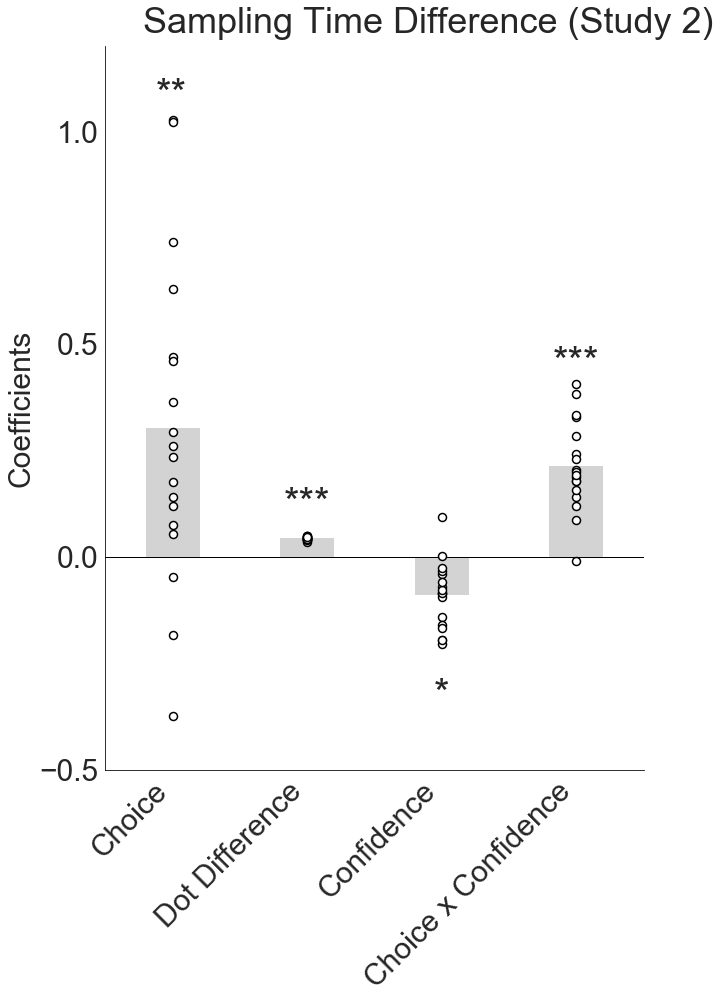

In [62]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2, 3]
y_mean = [mean(coefs['Choice']), mean(coefs['NonAbsDiff']), mean(coefs['ZConf1']), mean(coefs['Choice:ZConf1'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects2: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['Choice'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['NonAbsDiff'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(3, coefs[coefs['subject']==subject]['Choice:ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_xlim([-0.5,3.5])
ax.set_ylim([-0.5,1.2])

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Sampling Time Difference (Study 2)", fontsize=36)
ttl = ax.title
ttl.set_position([0.6, 1.01])
ax.set_xticks((np.arange(4)))
yticks = np.arange(-0.5, 1.2, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(("Choice", "Dot Difference", "Confidence", "Choice x Confidence"), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('**', xy=(-0.01,1.06), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(1,0.1), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('*', xy=(2,-0.35), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(3,0.43), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()
plt.savefig('Fig4B.pdf')

<a id=Figure4C></a>

### Figure 4C

In [43]:
## define sampling bias as chosen-unchosen time
Data2['SamplingBias']=Data2['ChosenTime']-Data2['UnchosenTime']

In [44]:
# re-index for z-scoring
Data2.reset_index(inplace=True)
Data2.index = range(1, len(Data2) + 1)
Data2['Participant']=Data2['participant']
Data2 = Data2.set_index(['Participant', 'index'])

In [45]:
# Z-score new bias variable 
Data2.head()
Data2['ZBias'] = (Data2['SamplingBias']-Data2.groupby(level='Participant')['SamplingBias'].mean())/Data2.groupby(level = 'Participant')['SamplingBias'].std()
# Are the mean Z-scores all close to 0?
Data2.groupby(level=0)['ZBias'].mean()

Participant
1    -3.612630e-17
2    -3.251051e-17
7     2.579771e-17
9    -1.762259e-16
10   -1.409807e-17
11    4.669986e-17
13    1.179612e-16
14    9.251859e-17
15   -1.762259e-18
17   -1.938485e-17
18   -7.324388e-17
19   -6.079793e-17
20   -5.415722e-18
21   -8.194503e-17
22    7.489600e-18
24   -1.440647e-16
25    1.277638e-17
26    1.163091e-16
Name: ZBias, dtype: float64

In [46]:
# square dot difference (fewer convergence issues)
Data2['DDsqrt']=sqrt(Data2['DotDifference'])

In [47]:
# create variable for free vs fixed viewing session (0=free; 1=fixed)
Data2['FixedSampling']=[1 if x == 'Fixed' else 0 for x in Data2['Session']]

In [48]:
# create variable for change of mind (0=no change; 1=change)
Data2['change']=0
Data2.loc[Data2['Response1']!=Data2['Response2'], 'change']=1

In [160]:
# load data into R
r_df = pandas2ri.py2rpy(Data2)
%R -i r_df

In [67]:
%%R
changemodel2 <- glmer(change ~ ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling*ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling*ZBias | participant), data=r_df, control = lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminbw", starttests = FALSE, kkt = FALSE)), family="binomial")
print(summary(changemodel2))

R[write to console]: Warning in glmer(change ~ ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling *  :
R[write to console]: 
 
R[write to console]:  please use glmerControl() instead of lmerControl()



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling *  
    ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling *  
    ZBias | participant)
   Data: r_df
Control: 
lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminbw",  
    starttests = FALSE, kkt = FALSE))

     AIC      BIC   logLik deviance df.resid 
  4078.6   4251.7  -2012.3   4024.6     4473 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5884 -0.5018 -0.3540 -0.1898  5.3805 

Random effects:
 Groups      Name                Variance Std.Dev. Corr                   
 participant (Intercept)         0.84128  0.9172                          
             ZBias               0.40372  0.6354    0.43                  
             DDsqrt              0.04286  0.2070   -0.98 -0.27            
             ZConf1            

In [68]:
# grab subject-level coefficients
%R coefs <- coef(changemodel2)$participant
%R -o coefs

In [69]:
# index coefficient dataframe
coefs['subject']=subjects2

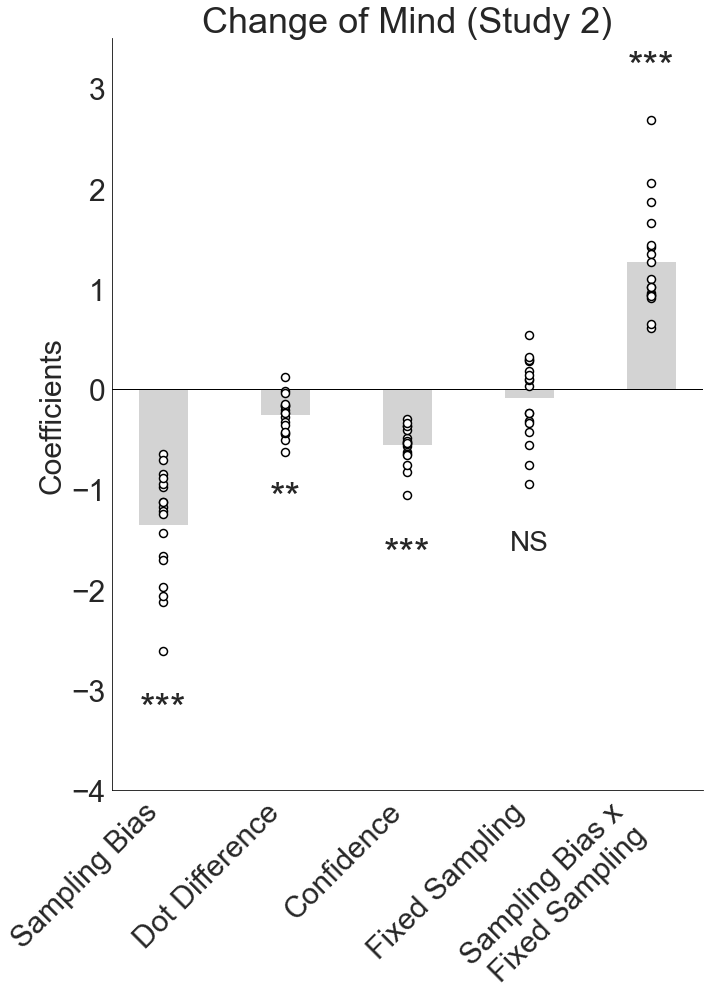

In [71]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2, 3, 4]
y_mean = [mean(coefs['ZBias']), mean(coefs['DDsqrt']), mean(coefs['ZConf1']), mean(coefs['FixedSampling']), mean(coefs['ZBias:FixedSampling'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects2: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['ZBias'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['DDsqrt'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(3, coefs[coefs['subject']==subject]['FixedSampling'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(4, coefs[coefs['subject']==subject]['ZBias:FixedSampling'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_ylim([-4,3.5])
    
# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Change of Mind (Study 2)", fontsize=36)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(5)))
yticks = np.arange(-4, 4, 1)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(('Sampling Bias', 'Dot Difference', 'Confidence', 'Fixed Sampling', 'Sampling Bias x\nFixed Sampling'), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('***', xy=(0,-3.3), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('**', xy=(1,-1.2), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(2,-1.75), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('NS', xy=(3,-1.6), xycoords='data', fontsize=28, ha='center')

ax.annotate('***', xy=(4,3.1), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()
plt.savefig('Fig4C.pdf')

<a id=Figure4D></a>

### Figure 4D

In [49]:
# create variables describing proportion of total sampling time spent on each patch
Data2Free['ChosenPercTime']=Data2Free['ChosenTime']/Data2Free['SamplingLength']
Data2Free['UnchosenPercTime']=Data2Free['UnchosenTime']/Data2Free['SamplingLength']
Data2Fixed['ChosenPercTime']=Data2Fixed['ChosenTime']/(Data2Fixed['Left_Gazetime_New']/1000+Data2Fixed['Right_Gazetime_New']/1000)
Data2Fixed['UnchosenPercTime']=Data2Fixed['UnchosenTime']/(Data2Fixed['Left_Gazetime_New']/1000+Data2Fixed['Right_Gazetime_New']/1000)



In [50]:
bins = np.linspace(0.175,0.625,10)
Data2Free['new_bias_bin']=pd.cut(Data2Free['ChosenPercTime'], bins, labels=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6])
Data2Fixed['new_bias_bin']=pd.cut(Data2Fixed['ChosenPercTime'], bins, labels=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6])


In [51]:
# create variable for change of mind (0=no change; 1=change)
Data2Free['change']=0
Data2Free.loc[Data2Free['Response1']!=Data2Free['Response2'], 'change']=1
Data2Fixed['change']=0
Data2Fixed.loc[Data2Fixed['Response1']!=Data2Fixed['Response2'], 'change']=1

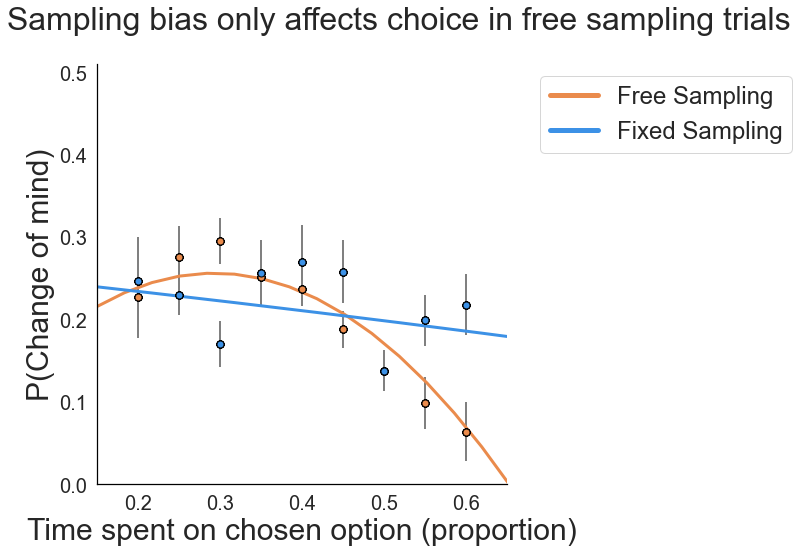

In [83]:
sns.set(font_scale=2)
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
fig=figure(figsize=(12,8))
fig.suptitle('Sampling bias only affects choice in free sampling trials', fontsize = 32)
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
#run the classifier
clf = sklearn.linear_model.LogisticRegression(C=1e5)
logit1 = []
logit2 = []
plot = fig.add_subplot(1,1,1)
#plot the data
#plt.clf()
colors=['#540D6E', '#46B1C9', '#F5EE9E', '#EAF9D9', '#B5E2FA', '#A5B452', '#CCC7B9', '#DB324D']

mean_prob_free=[]
var_prob_free=[]
mean_prob_fixed=[]
var_prob_fixed=[]
rankdiffs=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
rankdiffs2=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
for y in rankdiffs:
    mean_prob_free.append(mean(Data2Free[Data2Free['new_bias_bin']==y]['change']))
    var_prob_free.append(sp.stats.sem(Data2Free[Data2Free['new_bias_bin']==y]['change']))
for y in rankdiffs2:
    mean_prob_fixed.append(mean(Data2Fixed[Data2Fixed['new_bias_bin']==y]['change']))
    var_prob_fixed.append(sp.stats.sem(Data2Fixed[Data2Fixed['new_bias_bin']==y]['change']))

X_test = np.linspace(-5,5,300)

coefs_free = np.polyfit(Data2Free['ChosenPercTime'].values,  Data2Free['change'].values.flatten(), 2)
coefs_fixed = np.polyfit(Data2Fixed['ChosenPercTime'].values,  Data2Fixed['change'].values.flatten(), 2)

plot.plot(X_test, np.polyval(coefs_free, X_test), linewidth=3, color='#EA8B4C')
plot.plot(X_test, np.polyval(coefs_fixed, X_test), linewidth=3, color='#3C91E6')

for y in rankdiffs:
    plot.errorbar(rankdiffs, mean_prob_free, yerr=var_prob_free, fmt = 'o', marker='o',markerfacecolor='#EA8B4C', markeredgecolor = 'black', ms = 7, ecolor='gray')
    plot.errorbar(rankdiffs2, mean_prob_fixed, yerr=var_prob_fixed, fmt = 'o', marker='o',markerfacecolor='#3C91E6', markeredgecolor = 'black', ms = 7, ecolor='gray')

plot.set_ylabel('P(Change of mind)', size=30)
plot.set_xlabel('Time spent on chosen option (proportion)', size=30)
plot.tick_params(axis='both', which='major', labelsize=20)

plot.set_ylim(0, 0.51)
plot.set_xlim(0.15, 0.65)
plot.grid(True)
grid(False)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#EA8B4C', lw=5),
                Line2D([0], [0], color='#3C91E6', lw=5)]

plot.legend(custom_lines, ['Free Sampling', 'Fixed Sampling'], prop={'size': 24}, bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine(right=True, top=True)
plt.tight_layout()
plt.subplots_adjust(top=0.88, left=0.15)
plt.savefig('Fig4D.pdf')


<a id=Figure4sup1></a>

### Figure 4-figure supplement 1

In [52]:
Data2Free['TotalSamplingTime']=Data2Free['LeftTime']+Data2Free['RightTime']

In [53]:
Data2Free['ZTotal']=z_score1(Data2Free,'Participant','TotalSamplingTime')

In [54]:
Data2Free['ZRT']=z_score1(Data2Free,'Participant',"RT1")

In [57]:
Data2Free['Conf_bin']=Data2Free['Conf_bin'].astype('float')

In [144]:
regFormula1 = "ZTotal ~   ZDifficult + ZConf1 + (ZDifficult + ZConf1 |Participant) "
#regFormula2 = "ZConf2 ~ - 1 +  Choice1 + Zdifficult + ZRT2 + ZTotDot + (Choice1 + Zdifficult + ZRT2 + ZTotDot|participant)"

model1 = Lmer(regFormula1, data=Data2Free[Data2Free['SamplingLength']==5])
model2 = Lmer(regFormula1, data=Data2Free[Data2Free['SamplingLength']==7])
model3 = Lmer(regFormula1, data=Data2Free)

In [145]:
model3.fit()

boundary (singular) fit: see ?isSingular 

Formula: ZTotal~ZDifficult+ZConf1+(ZDifficult+ZConf1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 2244	 Groups: {'Participant': 18.0}

Log-likelihood: -3178.804 	 AIC: 6357.608

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.000  0.000
Participant   ZDifficult  0.001  0.023
Participant       ZConf1  0.003  0.057
Residual                  0.986  0.993

                     IV1         IV2 Corr
Participant  (Intercept)  ZDifficult     
Participant  (Intercept)      ZConf1     
Participant   ZDifficult      ZConf1    1

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)    -0.000  -0.041    0.041  0.021  2230.290  -0.007  0.994     
ZDifficult     -0.035  -0.078    0.008  0.022   111.757  -1.579  0.117     
ZConf1         -0.103  -0.153   -0.052  0.026    22.988  -4.010  0.001  ***

In [146]:
table_data3 = model3.coefs.T

par_table_data3 = model3.fixef

In [147]:
table_data3

(Intercept)  ZDifficult       ZConf1
Estimate -0.000145096  -0.0349964    -0.102669
2.5_ci     -0.0412402  -0.0784497    -0.152849
97.5_ci     0.0409501  0.00845696   -0.0524883
SE          0.0209673   0.0221705    0.0256027
DF            2230.29     111.757       22.988
T-stat    -0.00692013    -1.57851     -4.01007
P-val        0.994479    0.117274  0.000549097
Sig                                        ***

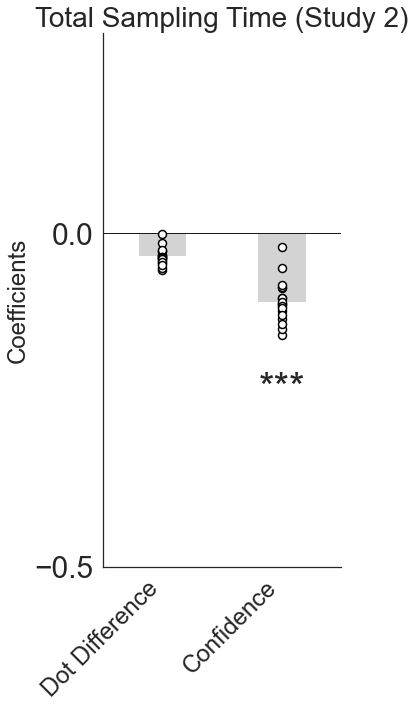

In [148]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(5, 10)
ind = np.arange(1)

x_mean = [0, 1]
y_mean = [table_data3['ZDifficult']['Estimate'], table_data3['ZConf1']['Estimate']]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in range(len(subjects2)): # create scatter
    ax.scatter(0, par_table_data3['ZDifficult'][subject], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, par_table_data3['ZConf1'][subject], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_xlim([-0.5,1.5])
ax.set_ylim([-0.3,0.3])

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=24)
ax.set_title("Total Sampling Time (Study 2)", fontsize=28)
# ttl = ax.title
# ttl.set_position([0, 1.01])
ax.set_xticks((np.arange(2)))
yticks = np.arange(-0.5, 0.5, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(("Dot Difference", "Confidence"), rotation=45, ha='right', fontsize=24)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')
            
ax.annotate('***', xy=(1,-0.25), xycoords='data', fontsize=40, ha='center')
            
            
plt.tight_layout()
# plt.savefig('TotalTime_reg.pdf',bbox_inches='tight')



<a id=Figure4sup2>

### Figure 4-figure supplement 2

In [79]:
Data2Fixed['Chosen_Presentation_Time'] = [Data2Fixed['LEFT_PRESENTATION_TIME_REV'].iloc[row]/1000 if Data2Fixed['Response1'].iloc[row]=='left' else Data2Fixed['RIGHT_PRESENTATION_TIME_REV'].iloc[row]/1000 for row in range(len(Data2Fixed))]
Data2Fixed['Unchosen_Presentation_Time'] = [Data2Fixed['LEFT_PRESENTATION_TIME_REV'].iloc[row]/1000 if Data2Fixed['Response1'].iloc[row]=='right' else Data2Fixed['RIGHT_PRESENTATION_TIME_REV'].iloc[row]/1000 for row in range(len(Data2Fixed))]



In [80]:
# get variables describing presentation time for chosen and unchosen patches as proportion of total time in fixed sampling condition
Data2Fixed['ChosenPercPersTime']=Data2Fixed['Chosen_Presentation_Time']/(Data2Fixed['LEFT_PRESENTATION_TIME_REV']/1000+Data2Fixed['RIGHT_PRESENTATION_TIME_REV']/1000)
Data2Fixed['UnchosenPercPersTime']=Data2Fixed['Unchosen_Presentation_Time']/(Data2Fixed['LEFT_PRESENTATION_TIME_REV']/1000+Data2Fixed['RIGHT_PRESENTATION_TIME_REV']/1000)


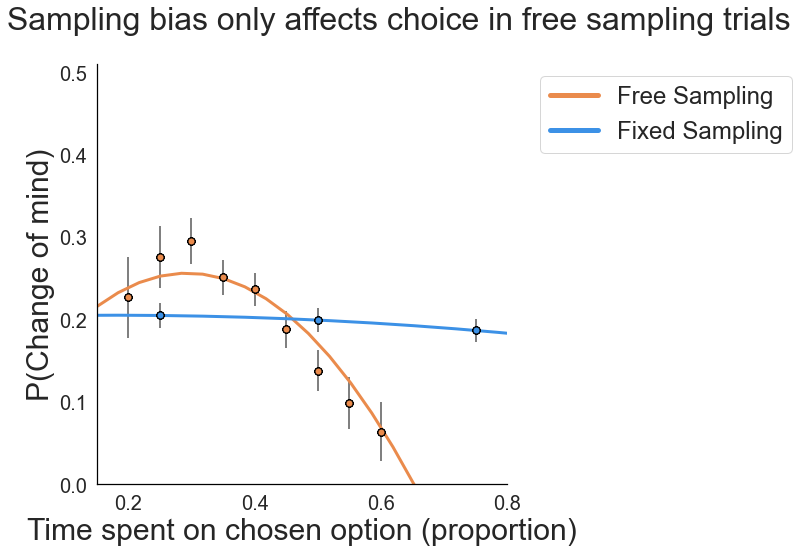

In [84]:
sns.set(font_scale=2)
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
fig=figure(figsize=(12,8))
fig.suptitle('Sampling bias only affects choice in free sampling trials', fontsize = 32)
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
#run the classifier
clf = sklearn.linear_model.LogisticRegression(C=1e5)
logit1 = []
logit2 = []
plot = fig.add_subplot(1,1,1)
#plot the data
#plt.clf()
colors=['#540D6E', '#46B1C9', '#F5EE9E', '#EAF9D9', '#B5E2FA', '#A5B452', '#CCC7B9', '#DB324D']

mean_prob_free=[]
var_prob_free=[]
mean_prob_fixed=[]
var_prob_fixed=[]
rankdiffs=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
rankdiffs2=[0.25, 0.5, 0.75]
for y in rankdiffs:
    mean_prob_free.append(mean(Data2Free[Data2Free['new_bias_bin']==y]['change']))
    var_prob_free.append(sp.stats.sem(Data2Free[Data2Free['new_bias_bin']==y]['change']))
for y in rankdiffs2:
    mean_prob_fixed.append(mean(Data2Fixed[Data2Fixed['ChosenPercPersTime']==y]['change']))
    var_prob_fixed.append(sp.stats.sem(Data2Fixed[Data2Fixed['ChosenPercPersTime']==y]['change']))

X_test = np.linspace(-5,5,300)

coefs_free = np.polyfit(Data2Free['ChosenPercTime'].values,  Data2Free['change'].values.flatten(), 2)
coefs_fixed = np.polyfit(Data2Fixed['ChosenPercPersTime'].values,  Data2Fixed['change'].values.flatten(), 2)

plot.plot(X_test, np.polyval(coefs_free, X_test), linewidth=3, color='#EA8B4C')
plot.plot(X_test, np.polyval(coefs_fixed, X_test), linewidth=3, color='#3C91E6')

for y in rankdiffs:
    plot.errorbar(rankdiffs, mean_prob_free, yerr=var_prob_free, fmt = 'o', marker='o',markerfacecolor='#EA8B4C', markeredgecolor = 'black', ms = 7, ecolor='gray')
    plot.errorbar(rankdiffs2, mean_prob_fixed, yerr=var_prob_fixed, fmt = 'o', marker='o',markerfacecolor='#3C91E6', markeredgecolor = 'black', ms = 7, ecolor='gray')

plot.set_ylabel('P(Change of mind)', size=30)
plot.set_xlabel('Time spent on chosen option (proportion)', size=30)
plot.tick_params(axis='both', which='major', labelsize=20)

plot.set_ylim(0, 0.51)
plot.set_xlim(0.15, 0.8)
plot.grid(True)
grid(False)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#EA8B4C', lw=5),
                Line2D([0], [0], color='#3C91E6', lw=5)]

plot.legend(custom_lines, ['Free Sampling', 'Fixed Sampling'], prop={'size': 24}, bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine(right=True, top=True)
plt.tight_layout()
plt.subplots_adjust(top=0.88, left=0.15)
plt.savefig('Fig4_s2.pdf')

<a id=Figure4sup3></a>

### Figure 4-figure supplement 3

In [59]:
Data1['Choice1']=[1 if x =='left' else 0 for x in Data1['Response1']]
Data2Free['Choice1']=[1 if x =='left' else 0 for x in Data2Free['Response1']]

In [19]:
Data1['TotDot'] =  Data1['DotNumberRight'] + Data1['DotNumberLeft']
Data2Free['TotDot'] =  Data2Free['DotNumberRight'] + Data2Free['DotNumberLeft']

In [20]:
Data1["ZTotDot"] = z_score1(Data1,'Participant',"TotDot")
Data2Free["ZTotDot"] = z_score1(Data2Free,'participant',"TotDot")

In [64]:
Data2Free['new_bias_bin']=Data2Free['new_bias_bin'].astype('float')

In [182]:
regFormula1 = "ZDeltaSampling ~  Choice1 + ZNonAbsDiff + ZTotDot  +  Choice1*ZTotDot +  ( Choice1 + ZNonAbsDiff + ZTotDot  +  Choice1*ZTotDot|Participant) "
#regFormula2 = "ZConf2 ~ - 1 +  Choice1 + Zdifficult + ZRT2 + ZTotDot + (Choice1 + Zdifficult + ZRT2 + ZTotDot|participant)"

model1 = Lmer(regFormula1, data=Data1)
model2 = Lmer(regFormula1, data=Data2Free)

In [183]:
model1.fit()
model2.fit()

boundary (singular) fit: see ?isSingular 

Formula: ZDeltaSampling~Choice1+ZNonAbsDiff+ZTotDot+Choice1*ZTotDot+(Choice1+ZNonAbsDiff+ZTotDot+Choice1*ZTotDot|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 5600	 Groups: {'Participant': 28.0}

Log-likelihood: -7122.311 	 AIC: 14244.622

Random effects:

                        Name    Var    Std
Participant      (Intercept)  0.018  0.133
Participant          Choice1  0.056  0.236
Participant      ZNonAbsDiff  0.016  0.128
Participant          ZTotDot  0.001  0.027
Participant  Choice1:ZTotDot  0.003  0.051
Residual                      0.729  0.854

                     IV1              IV2   Corr
Participant  (Intercept)          Choice1 -1.000
Participant  (Intercept)      ZNonAbsDiff  0.005
Participant  (Intercept)          ZTotDot -0.073
Participant  (Intercept)  Choice1:ZTotDot  0.248
Participant      Choice1      ZNonAbsDiff -0.005
Participant      Choice1          ZTotDot  0.073
Participant      Choic

Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)        -0.135  -0.241   -0.029  0.054   17.259  -2.492  0.023    *
Choice1             0.274   0.079    0.469  0.100   16.862   2.752  0.014    *
ZNonAbsDiff         0.251   0.202    0.301  0.025   19.255   9.870  0.000  ***
ZTotDot            -0.018  -0.074    0.039  0.029   37.165  -0.607  0.547     
Choice1:ZTotDot    -0.046  -0.124    0.032  0.040  102.429  -1.152  0.252

In [184]:
table_data1 = model1.coefs.T
table_data2 = model2.coefs.T

par_table_data1 = model1.fixef
par_table_data2 = model2.fixef

In [185]:
table_data1

(Intercept)      Choice1  ZNonAbsDiff     ZTotDot Choice1:ZTotDot
Estimate    -0.258495     0.479286     0.328562   0.0393529      -0.0438754
2.5_ci      -0.319135     0.378525     0.274937  0.00513774      -0.0925893
97.5_ci     -0.197854     0.580047     0.382187   0.0735681      0.00483844
SE          0.0309396    0.0514096    0.0273603   0.0174571       0.0248545
DF            27.4928       26.939      27.0161     136.793         48.4005
T-stat       -8.35483      9.32289      12.0087     2.25427        -1.76529
P-val     5.00954e-09  6.38688e-10  2.42043e-12   0.0257687       0.0838229
Sig               ***          ***          ***           *               .

In [186]:
table_data2

(Intercept)    Choice1  ZNonAbsDiff    ZTotDot Choice1:ZTotDot
Estimate   -0.134818    0.27418     0.251462 -0.0175258      -0.0457725
2.5_ci     -0.240848  0.0788925     0.201526 -0.0740719       -0.123619
97.5_ci   -0.0287882   0.469468     0.301398  0.0390202       0.0320738
SE         0.0540978  0.0996386    0.0254782  0.0288506       0.0397182
DF            17.259    16.8624      19.2553    37.1647         102.429
T-stat      -2.49211    2.75175      9.86971   -0.60747        -1.15243
P-val      0.0231463  0.0136912  5.70961e-09   0.547233        0.251826
Sig                *          *          ***

([<matplotlib.axis.XTick at 0x7fa41dd894c0>,
 [Text(1.25, 0, '(Inter)'),
  Text(2.25, 0, 'Choice'),
  Text(3.25, 0, 'ΔDots'),
  Text(4.25, 0, 'ΣDots'),
  Text(5.25, 0, 'Choice x\nΣDots')])

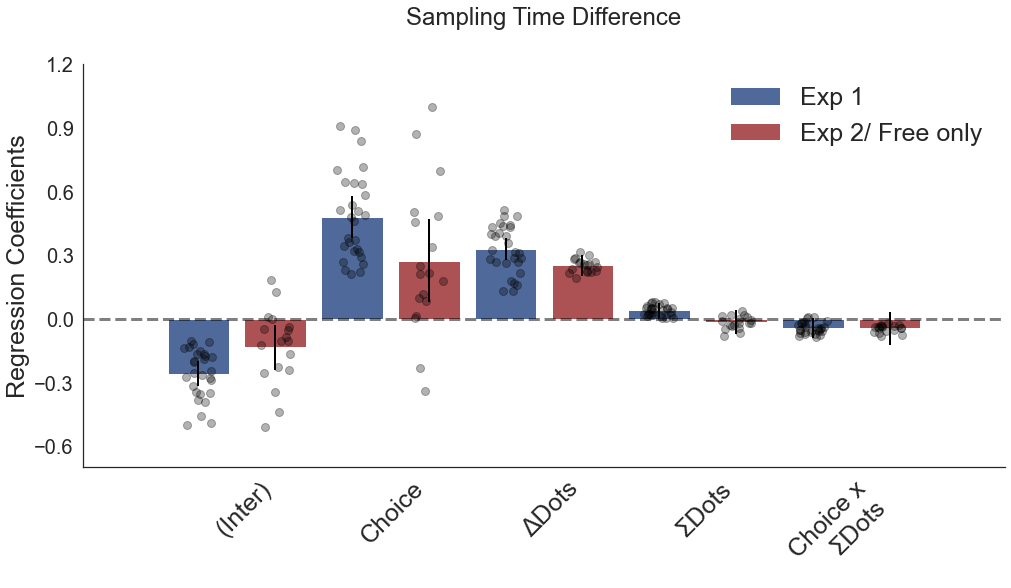

In [187]:
Coefpresplot_bar2(table_data1, par_table_data1,table_data2, par_table_data2, barcol1='#4F6A9A',barcol2='#AC5255', 
                  title='Sampling Time Difference', size='big',ymultiple=0.3, ticklabsize=20,labels= ['Exp 1','Exp 2/ Free only'])

plt.xticks([1.25,2.25,3.25, 4.25,5.25],['(Inter)','Choice','ΔDots','ΣDots','Choice x\nΣDots'], rotation=45)

<a id='Figure4sup4'></a>

### Figure 4-figure supplement 4

In [22]:
# make new dummy variable encoding the amount of dots of the chosen alternatives
Data1['ChosenDot1'] = Data1['DotNumberRight']*(Data1['Response1'] == 'right') + Data1['DotNumberLeft']*(Data1['Response1'] == 'left')
Data1['UnchoDot1'] = Data1['DotNumberLeft']*(Data1['Response1'] == 'right') + Data1['DotNumberRight']*(Data1['Response1'] == 'left')

Data2Free['ChosenDot1'] = Data2Free['DotNumberRight']*(Data2Free['Response1'] == 'right') + Data2Free['DotNumberLeft']*(Data2Free['Response1'] == 'left')
Data2Free['UnchoDot1'] = Data2Free['DotNumberLeft']*(Data2Free['Response1'] == 'right') + Data2Free['DotNumberRight']*(Data2Free['Response1'] == 'left')

Data1["ZChosenDot1"] = z_score1(Data1,'Participant',"ChosenDot1")
Data1["ZUnchoDot1"] = z_score1(Data1,'Participant',"UnchoDot1")

Data2Free["ZChosenDot1"] = z_score1(Data2Free,'Participant',"ChosenDot1")
Data2Free["ZUnchoDot1"] = z_score1(Data2Free,'Participant',"UnchoDot1")


In [189]:
regFormula1 = "ZDeltaSampling ~  Choice1 + ZNonAbsDiff + ZChosenDot1  +  Choice1*ZChosenDot1 +  ( Choice1 + ZNonAbsDiff + ZChosenDot1  +  Choice1*ZChosenDot1|Participant) "
#regFormula2 = "ZConf2 ~ - 1 +  Choice1 + Zdifficult + ZRT2 + ZTotDot + (Choice1 + Zdifficult + ZRT2 + ZTotDot|participant)"

model1 = Lmer(regFormula1, data=Data1)
model2 = Lmer(regFormula1, data=Data2Free)

In [190]:
model1.fit()
model2.fit()

boundary (singular) fit: see ?isSingular 

Formula: ZDeltaSampling~Choice1+ZNonAbsDiff+ZChosenDot1+Choice1*ZChosenDot1+(Choice1+ZNonAbsDiff+ZChosenDot1+Choice1*ZChosenDot1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 5600	 Groups: {'Participant': 28.0}

Log-likelihood: -7119.689 	 AIC: 14239.378

Random effects:

                            Name    Var    Std
Participant          (Intercept)  0.019  0.136
Participant              Choice1  0.055  0.234
Participant          ZNonAbsDiff  0.016  0.128
Participant          ZChosenDot1  0.002  0.041
Participant  Choice1:ZChosenDot1  0.004  0.060
Residual                          0.727  0.853

                     IV1                  IV2   Corr
Participant  (Intercept)              Choice1 -1.000
Participant  (Intercept)          ZNonAbsDiff -0.043
Participant  (Intercept)          ZChosenDot1 -0.625
Participant  (Intercept)  Choice1:ZChosenDot1  0.232
Participant      Choice1          ZNonAbsDiff  0.043
Par

Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  \
(Intercept)            -0.124  -0.231   -0.017  0.055   17.566  -2.267  0.036   
Choice1                 0.252   0.056    0.449  0.100   16.981   2.514  0.022   
ZNonAbsDiff             0.276   0.216    0.336  0.030  105.880   9.056  0.000   
ZChosenDot1             0.010  -0.056    0.075  0.033   48.899   0.287  0.775   
Choice1:ZChosenDot1    -0.065  -0.170    0.039  0.053   60.579  -1.223  0.226   

                     Sig  
(Intercept)            *  
Choice1                *  
ZNonAbsDiff          ***  
ZChosenDot1               
Choice1:ZChosenDot1

In [191]:
table_data1 = model1.coefs.T
table_data2 = model2.coefs.T

par_table_data1 = model1.fixef
par_table_data2 = model2.fixef

In [192]:
table_data1

(Intercept)      Choice1  ZNonAbsDiff ZChosenDot1 Choice1:ZChosenDot1
Estimate   -0.252217     0.463798     0.348318   0.0426384          -0.0586249
2.5_ci     -0.314501     0.361717     0.290456  0.00175693           -0.121745
97.5_ci    -0.189933      0.56588     0.406179   0.0835199          0.00449557
SE         0.0317781    0.0520835    0.0295218   0.0208583           0.0322049
DF            27.389      27.2034      27.4019      72.125             71.6697
T-stat      -7.93681       8.9049      11.7987      2.0442            -1.82037
P-val     1.4148e-08  1.50521e-09  2.98392e-12   0.0445859           0.0728775
Sig              ***          ***          ***           *                   .

In [193]:
table_data2

(Intercept)    Choice1  ZNonAbsDiff ZChosenDot1 Choice1:ZChosenDot1
Estimate    -0.12362   0.252268     0.276093  0.00955182          -0.0652793
2.5_ci     -0.230516  0.0555685     0.216337  -0.0556519           -0.169936
97.5_ci   -0.0167241   0.448967     0.335849   0.0747555           0.0393778
SE         0.0545398   0.100359    0.0304884   0.0332678           0.0533975
DF           17.5657    16.9811       105.88     48.8988             60.5788
T-stat       -2.2666    2.51366      9.05567    0.287119            -1.22252
P-val      0.0363002  0.0223272  7.53804e-15    0.775234            0.226248
Sig                *          *          ***

([<matplotlib.axis.XTick at 0x7fa422cd9eb0>,
 [Text(1.25, 0, '(Inter)'),
  Text(2.25, 0, 'Choice'),
  Text(3.25, 0, 'ΔDots'),
  Text(4.25, 0, 'ChosenDots'),
  Text(5.25, 0, 'Choice x\nChosenDots')])

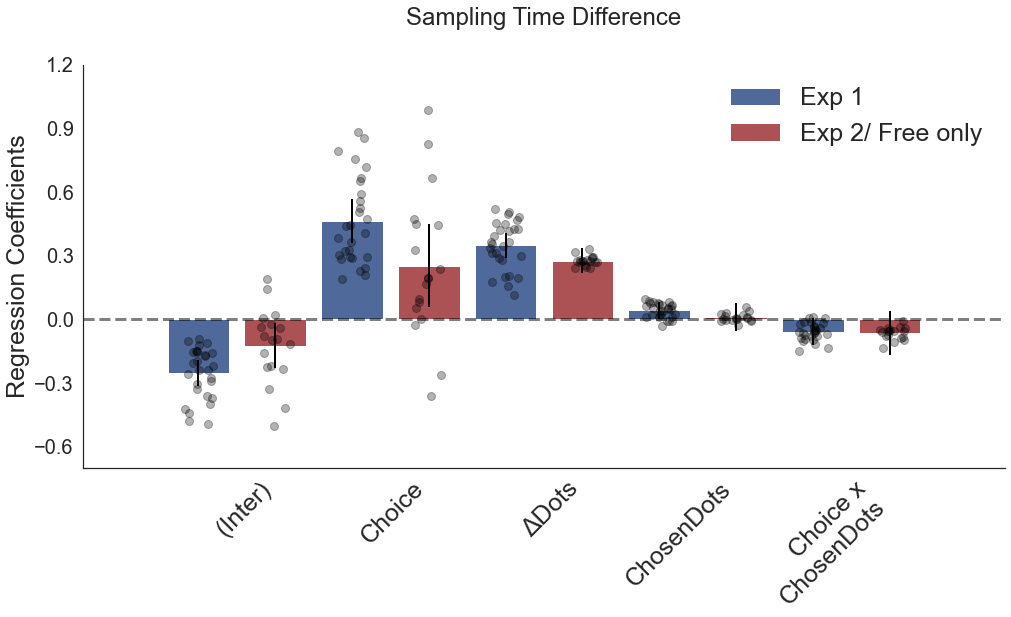

In [194]:
Coefpresplot_bar2(table_data1, par_table_data1,table_data2, par_table_data2, barcol1='#4F6A9A',barcol2='#AC5255', 
                  title='Sampling Time Difference', size='big',ymultiple=0.3, ticklabsize=20,labels= ['Exp 1','Exp 2/ Free only'])

plt.xticks([1.25,2.25,3.25, 4.25,5.25],['(Inter)','Choice','ΔDots','ChosenDots','Choice x\nChosenDots'], rotation=45)

<a id='Figure4sup5'></a>

### Figure 4-figure supplement 5

In [23]:
%R -i Data1
%R -i Data2Free

In [24]:
%%R
Corr1_hmodel <-  glmer(Correct1 ~ ZDifficult + ZTotDot + (ZDifficult + ZTotDot | Participant), data=Data1, family='binomial', control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

#Extract parameters
fix_Corr1_hmodel <- fixef(Corr1_hmodel)
fix_se_Corr1_hmodel <- sqrt(diag(vcov(Corr1_hmodel)))
names_Corr1_hmodel <- names(fix_Corr1_hmodel)

# Extract mixed effect paramters
mix_Corr1_model <- coef(Corr1_hmodel)

summary(Corr1_hmodel)


R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Correct1 ~ ZDifficult + ZTotDot + (ZDifficult + ZTotDot | Participant)
   Data: Data1
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  6561.6   6621.3  -3271.8   6543.6     5591 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5722 -1.1753  0.5421  0.6677  1.1495 

Random effects:
 Groups      Name        Variance  Std.Dev.  Corr       
 Participant (Intercept) 0.000e+00 0.000e+00            
             ZDifficult  1.275e-17 3.571e-09   NaN      
             ZTotDot     2.190e-13 4.680e-07   NaN -0.17
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.92820    0.03051  30.424   <2e-16 ***
ZDifficult   0.44382    0.03134  14.161   <2e-16 ***
ZTotDot     -0.07725    0.03199  -2.415   

In [25]:
%R -o fix_Corr1_hmodel -o fix_se_Corr1_hmodel -o names_Corr1_hmodel -o mix_Corr1_model

#Generate table with parameters to plot
Corr1_hmodel_table = regtable(fix_Corr1_hmodel, fix_se_Corr1_hmodel, names_Corr1_hmodel)
Corr1_hmodel_table.columns = ['Inter', '|ΔDots|', "ΣDots"]
#Corr1_hmodel_table.columns = ['(Intercept)', 'ZDifficult', "ZTotDot"]

# Extract table containing mixed effects for the model
mix_Corr1_model = mix_Corr1_model[0]

In [26]:
%%R
Corr2_hmodel =  glmer(Correct1 ~    ZDifficult+ ZTotDot+ 
                               (ZDifficult+ ZTotDot | Participant), data=Data2Free, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

#Extract parameters
fix_Corr2_hmodel <- fixef(Corr2_hmodel)
fix_se_Corr2_hmodel <- sqrt(diag(vcov(Corr2_hmodel)))
names_Corr2_hmodel <- names(fix_Corr2_hmodel)

# Extract mixed effect paramters
mix_Corr2_model <- coef(Corr2_hmodel)

summary(Corr2_hmodel)

R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Correct1 ~ ZDifficult + ZTotDot + (ZDifficult + ZTotDot | Participant)
   Data: Data2Free
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  2623.1   2674.6  -1302.6   2605.1     2235 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7937 -1.1322  0.5291  0.6586  1.1732 

Random effects:
 Groups      Name        Variance  Std.Dev.  Corr     
 Participant (Intercept) 0.000e+00 0.000e+00          
             ZDifficult  4.591e-15 6.775e-08  NaN     
             ZTotDot     1.386e-13 3.723e-07  NaN 0.84
Number of obs: 2244, groups:  Participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 0.940569   0.048565  19.367   <2e-16 ***
ZDifficult  0.494312   0.050240   9.839   <2e-16 ***
ZTotDot     0.004441   0.051226   0.087    0.9

In [27]:
%R -o fix_Corr2_hmodel -o fix_se_Corr2_hmodel -o names_Corr2_hmodel -o mix_Corr2_model

#Generate table with parameters to plot
Corr2_hmodel_table = regtable(fix_Corr2_hmodel, fix_se_Corr2_hmodel, names_Corr2_hmodel)
Corr2_hmodel_table.columns = ['Inter', '|ΔDots|', "ΣDots"]
#Corr2_hmodel_table.columns = ['(Intercept)', 'ZDifficult', "ZTotDot"]

# Extract table containing mixed effects for the model
mix_Corr2_model = mix_Corr2_model[0]

In [84]:
Corr2_hmodel_table

Inter   |ΔDots|     ΣDots
coefficient  0.940569  0.494312  0.004441
se           0.048565  0.050240  0.051226
CImin        0.845381  0.395842 -0.095962
CImax        1.035756  0.592782  0.104843

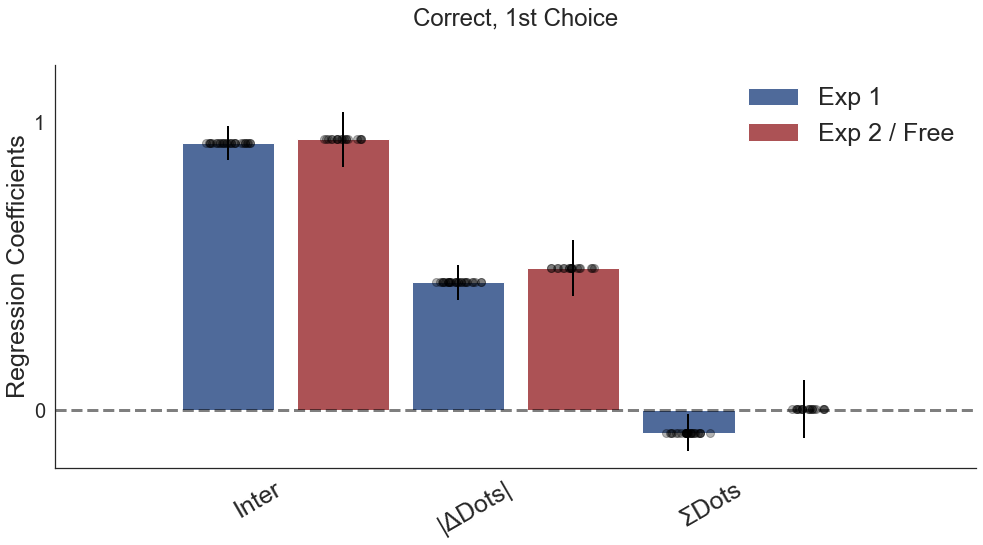

In [31]:
Coefpresplot_og_bar2(Corr1_hmodel_table, mix_Corr1_model,Corr2_hmodel_table, mix_Corr2_model, \
                     barcol1='#4F6A9A',barcol2='#AC5255', title='Correct, 1st Choice', size='big',ymultiple=1, \
                     ticklabsize=20, labels = ['Exp 1','Exp 2 / Free'])


In [32]:
%%R
Corr1_hmodel =  glmer(Correct2 ~    ZDifficult+ ZTotDot+ 
                               (ZDifficult+ ZTotDot | Participant), data=Data1, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

#Extract parameters
fix_Corr1_hmodel <- fixef(Corr1_hmodel)
fix_se_Corr1_hmodel <- sqrt(diag(vcov(Corr1_hmodel)))
names_Corr1_hmodel <- names(fix_Corr1_hmodel)

# Extract mixed effect paramters
mix_Corr1_model <- coef(Corr1_hmodel)

summary(Corr1_hmodel)

R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Correct2 ~ ZDifficult + ZTotDot + (ZDifficult + ZTotDot | Participant)
   Data: Data1
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  5482.1   5541.8  -2732.1   5464.1     5591 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6914  0.2805  0.4267  0.5579  1.0535 

Random effects:
 Groups      Name        Variance Std.Dev. Corr       
 Participant (Intercept) 0.058497 0.24186             
             ZDifficult  0.010624 0.10307   1.00      
             ZTotDot     0.001503 0.03877  -0.84 -0.84
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.44153    0.05815  24.789  < 2e-16 ***
ZDifficult   0.56520    0.04089  13.821  < 2e-16 ***
ZTotDot     -0.10428    0.03937  -2.649  0.00808 *

In [33]:
%R -o fix_Corr1_hmodel -o fix_se_Corr1_hmodel -o names_Corr1_hmodel -o mix_Corr1_model

#Generate table with parameters to plot
Corr1_hmodel_table = regtable(fix_Corr1_hmodel, fix_se_Corr1_hmodel, names_Corr1_hmodel)
Corr1_hmodel_table.columns = ['Inter', '|ΔDots|', "ΣDots"]
#Corr1_hmodel_table.columns = ['(Intercept)', 'ZDifficult', "ZTotDot"]

# Extract table containing mixed effects for the model
mix_Corr1_model = mix_Corr1_model[0]


In [34]:
Corr1_hmodel_table

Inter   |ΔDots|     ΣDots
coefficient  1.441533  0.565200 -0.104281
se           0.058151  0.040893  0.039368
CImin        1.327557  0.485048 -0.181444
CImax        1.555510  0.645351 -0.027119

In [35]:
%%R
Corr2_hmodel =  glmer(Correct2 ~    ZDifficult+ ZTotDot+ 
                               (ZDifficult+ ZTotDot | Participant), data=Data2Free, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

#Extract parameters
fix_Corr2_hmodel <- fixef(Corr2_hmodel)
fix_se_Corr2_hmodel <- sqrt(diag(vcov(Corr2_hmodel)))
names_Corr2_hmodel <- names(fix_Corr2_hmodel)

# Extract mixed effect paramters
mix_Corr2_model <- coef(Corr2_hmodel)

summary(Corr2_hmodel)

R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Correct2 ~ ZDifficult + ZTotDot + (ZDifficult + ZTotDot | Participant)
   Data: Data2Free
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  2253.2   2304.6  -1117.6   2235.2     2235 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5074  0.2476  0.4238  0.5681  1.1804 

Random effects:
 Groups      Name        Variance Std.Dev. Corr       
 Participant (Intercept) 0.06317  0.2513              
             ZDifficult  0.02168  0.1472    0.85      
             ZTotDot     0.02019  0.1421   -0.42  0.12
Number of obs: 2244, groups:  Participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.38346    0.08302  16.664   <2e-16 ***
ZDifficult   0.69426    0.06840  10.150   <2e-16 ***
ZTotDot     -0.06606    0.07069  -0.935     0.

In [36]:
%R -o fix_Corr2_hmodel -o fix_se_Corr2_hmodel -o names_Corr2_hmodel -o mix_Corr2_model

#Generate table with parameters to plot
Corr2_hmodel_table = regtable(fix_Corr2_hmodel, fix_se_Corr2_hmodel, names_Corr2_hmodel)
Corr2_hmodel_table.columns = ['Inter', '|ΔDots|', "ΣDots"]
#Corr2_hmodel_table.columns = ['(Intercept)', 'ZDifficult', "ZTotDot"]

# Extract table containing mixed effects for the model
mix_Corr2_model = mix_Corr2_model[0]

In [37]:
Corr2_hmodel_table

Inter   |ΔDots|     ΣDots
coefficient  1.383455  0.694261 -0.066062
se           0.083022  0.068402  0.070690
CImin        1.220732  0.560192 -0.204615
CImax        1.546179  0.828329  0.072490

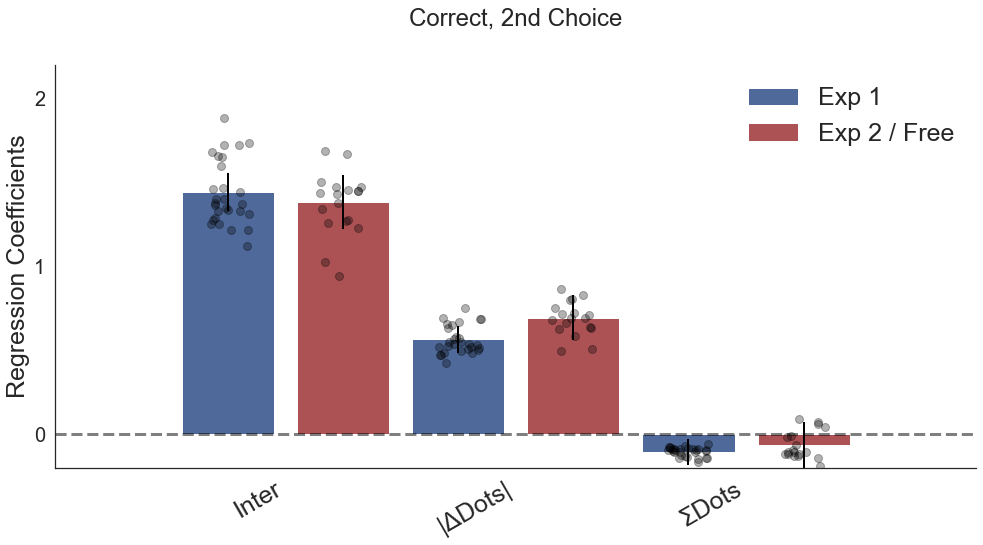

In [38]:
Coefpresplot_og_bar2(Corr1_hmodel_table, mix_Corr1_model,Corr2_hmodel_table, mix_Corr2_model, barcol1='#4F6A9A',barcol2='#AC5255', title='Correct, 2nd Choice', size='big',ymultiple=1, ticklabsize=20, labels = ['Exp 1','Exp 2 / Free'])


<a id=Figure4sup6></a>

### Figure 4-figure supplement 6 

In [41]:
Data1["ZRT1"] = z_score1(Data1,'Participant',"RT1")
Data1["ZRT2"] = z_score1(Data1,'Participant',"RT2")

Data2Free["ZRT1"] = z_score1(Data2Free,'Participant',"RT1")
Data2Free["ZRT2"] = z_score1(Data2Free,'Participant',"RT2")

In [42]:
regFormula1 = "ZConf1 ~   ZDifficult + ZRT1 +  ZTotDot + ( ZDifficult+ ZRT1 + ZTotDot|Participant) "
regFormula2 = "ZConf2 ~   ZDifficult + ZRT2 +  ZTotDot + ( ZDifficult+ ZRT2 + ZTotDot|Participant) "

model1 = Lmer(regFormula1, data=Data1)
model2 = Lmer(regFormula2, data=Data1)

In [43]:
model1.fit()
model2.fit()

boundary (singular) fit: see ?isSingular 

Formula: ZConf1~ZDifficult+ZRT1+ZTotDot+(ZDifficult+ZRT1+ZTotDot|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 5600	 Groups: {'Participant': 28.0}

Log-likelihood: -7524.928 	 AIC: 15049.857

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.000  0.000
Participant   ZDifficult  0.010  0.101
Participant         ZRT1  0.020  0.143
Participant      ZTotDot  0.000  0.013
Residual                  0.844  0.919

                     IV1         IV2       Corr
Participant  (Intercept)  ZDifficult           
Participant  (Intercept)        ZRT1           
Participant  (Intercept)     ZTotDot           
Participant   ZDifficult        ZRT1 -0.0050296
Participant   ZDifficult     ZTotDot  -0.817661
Participant         ZRT1     ZTotDot   0.579804

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: ZConf2~ZDifficult+ZRT2+ZTotDot+(ZDifficult+ZRT2+ZTotDot|Participant)

Famil

Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.000  -0.025    0.025  0.013  5514.081   0.000  1.000     
ZDifficult      0.152   0.118    0.187  0.018    26.952   8.676  0.000  ***
ZRT2           -0.157  -0.209   -0.105  0.027    26.934  -5.892  0.000  ***
ZTotDot        -0.023  -0.051    0.005  0.014    26.865  -1.609  0.119

In [44]:
table_data1 = model1.coefs.T
table_data2 = model2.coefs.T

par_table_data1 = model1.fixef
par_table_data2 = model2.fixef

table_data2 = table_data2.rename({'Choice2': 'Choice1', 
                                  'ZRT2': 'ZRT1'}, axis=1)

In [45]:
table_data1

(Intercept)  ZDifficult         ZRT1     ZTotDot
Estimate  3.35932e-11   0.0746051    -0.342063   0.0190459
2.5_ci     -0.0240686    0.030007    -0.400175 -0.00556171
97.5_ci     0.0240686    0.119203     -0.28395   0.0436534
SE          0.0122801   0.0227546    0.0296499   0.0125551
DF            5542.95     26.7632      26.8729     324.263
T-stat    2.73558e-09     3.27869     -11.5367     1.51698
P-val               1  0.00289204  6.46667e-12    0.130246
Sig                            **          ***

In [46]:
table_data2

(Intercept)   ZDifficult         ZRT1    ZTotDot
Estimate  2.14053e-11     0.152318     -0.15696  -0.022827
2.5_ci     -0.0252161     0.117908    -0.209171 -0.0506303
97.5_ci     0.0252161     0.186729     -0.10475  0.0049762
SE          0.0128656    0.0175565    0.0266387  0.0141856
DF            5514.08       26.952      26.9338    26.8651
T-stat    1.66376e-09       8.6759      -5.8922   -1.60917
P-val               1  2.76571e-09  2.83869e-06   0.119269
Sig                            ***          ***

TotDots / Cho1: 0.019045859498866474; Cho2: -0.022827034953999185Ttest_relResult(statistic=14.836373550289274, pvalue=1.677818903834009e-14)


([<matplotlib.axis.XTick at 0x7fb0c5b27490>,
 [Text(1.25, 0, '(Inter)'),
  Text(2.25, 0, '|ΔDots|'),
  Text(3.25, 0, 'RT'),
  Text(4.25, 0, 'ΣDots')])

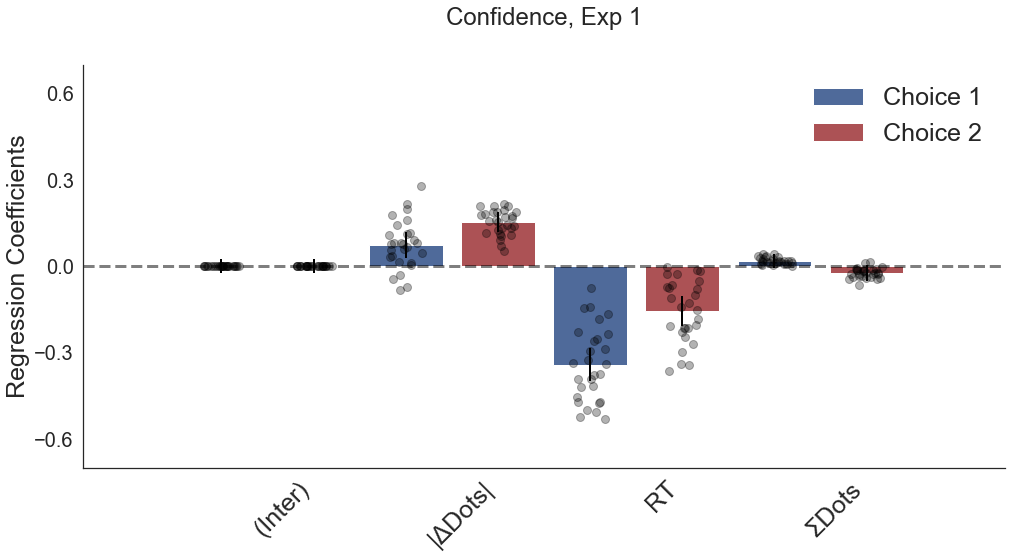

In [47]:
Coefpresplot_bar2(table_data1, par_table_data1,table_data2, par_table_data2, barcol1='#4F6A9A',barcol2='#AC5255', 
                  title='Confidence, Exp 1', size='big',ymultiple=0.3, ticklabsize=20,labels= ['Choice 1','Choice 2'])
#plt.xlim(-1, 3)

print('TotDots / Cho1: '+ str(np.mean(par_table_data1.ZTotDot.values)) + '; Cho2: ' + str( np.mean(par_table_data2.ZTotDot.values)) +  
      str(stats.ttest_rel(par_table_data1.ZTotDot.values,par_table_data2.ZTotDot.values)))
plt.xticks([1.25,2.25,3.25,4.25],['(Inter)','|ΔDots|','RT','ΣDots'], rotation=45)

In [48]:
regFormula1 = "ZConf1 ~   ZDifficult + ZRT1 +  ZTotDot + ( ZDifficult + ZRT1 + ZTotDot|Participant) "
regFormula2 = "ZConf2 ~   ZDifficult + ZRT2 + ZTotDot + ( ZDifficult + ZRT2 + ZTotDot|Participant) "

model1 = Lmer(regFormula1, data=Data2Free)
model2 = Lmer(regFormula2, data=Data2Free)

In [49]:
model1.fit()
model2.fit()

boundary (singular) fit: see ?isSingular 

Formula: ZConf1~ZDifficult+ZRT1+ZTotDot+(ZDifficult+ZRT1+ZTotDot|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 2244	 Groups: {'Participant': 18.0}

Log-likelihood: -3088.895 	 AIC: 6177.790

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.000  0.018
Participant   ZDifficult  0.013  0.112
Participant         ZRT1  0.009  0.093
Participant      ZTotDot  0.002  0.045
Residual                  0.898  0.948

                     IV1         IV2   Corr
Participant  (Intercept)  ZDifficult -1.000
Participant  (Intercept)        ZRT1  0.445
Participant  (Intercept)     ZTotDot -0.904
Participant   ZDifficult        ZRT1 -0.445
Participant   ZDifficult     ZTotDot  0.904
Participant         ZRT1     ZTotDot -0.019

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: ZConf2~ZDifficult+ZRT2+ZTotDot+(ZDifficult+ZRT2+ZTotDot|Participant)

Family: gaussian	 Inference: param

Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)     0.014  -0.025    0.053  0.020  2189.785   0.692  0.489    
ZDifficult      0.166   0.084    0.247  0.042    16.734   3.969  0.001  **
ZRT2           -0.068  -0.130   -0.006  0.031    16.913  -2.165  0.045   *
ZTotDot         0.006  -0.039    0.052  0.023    16.948   0.272  0.789

In [50]:
table_data1 = model1.coefs.T
table_data2 = model2.coefs.T

par_table_data1 = model1.fixef
par_table_data2 = model2.fixef


table_data2 = table_data2.rename({'Choice2': 'Choice1', 
                                  'ZRT2': 'ZRT1'}, axis=1)

In [51]:
table_data1

(Intercept)  ZDifficult        ZRT1    ZTotDot
Estimate  0.00160052    0.131901  -0.0563046  0.0595656
2.5_ci    -0.0385316   0.0664891   -0.114417   0.015063
97.5_ci    0.0417326    0.197313  0.00180825   0.104068
SE         0.0204759   0.0333742   0.0296499  0.0227058
DF           160.511     16.7625     17.3506    33.1617
T-stat     0.0781658      3.9522    -1.89898    2.62336
P-val       0.937794  0.00105336   0.0743255  0.0130565
Sig                           **           .          *

In [52]:
table_data2

(Intercept)  ZDifficult        ZRT1    ZTotDot
Estimate   0.0137342    0.165595  -0.0680145  0.0063512
2.5_ci    -0.0251693   0.0838296   -0.129587 -0.0393353
97.5_ci    0.0526377    0.247361 -0.00644188  0.0520377
SE         0.0198491    0.041718   0.0314152  0.0233099
DF           2189.79     16.7343     16.9127    16.9483
T-stat       0.69193      3.9694    -2.16502   0.272468
P-val       0.489055  0.00101801   0.0449806   0.788554
Sig                           **           *

TotDots / Cho1: 0.0595656431066502; Cho2: 0.006351200432871496Ttest_relResult(statistic=5.297747962590099, pvalue=5.905821750425266e-05)


([<matplotlib.axis.XTick at 0x7fb0c5a853a0>,
 [Text(1.25, 0, '(Inter)'),
  Text(2.25, 0, '|ΔDots|'),
  Text(3.25, 0, 'RT'),
  Text(4.25, 0, 'ΣDots')])

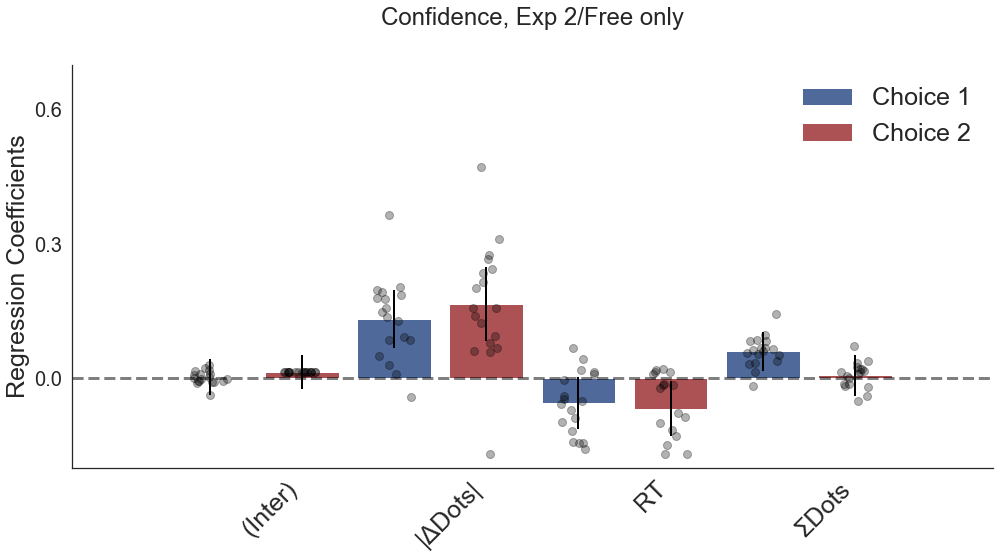

In [53]:

Coefpresplot_bar2(table_data1, par_table_data1,table_data2, par_table_data2, barcol1='#4F6A9A',barcol2='#AC5255', 
                  title='Confidence, Exp 2/Free only', size='big',ymultiple=0.3, ticklabsize=20,labels= ['Choice 1','Choice 2'])
#plt.xlim(-1, 3)

print('TotDots / Cho1: '+ str(np.mean(par_table_data1.ZTotDot.values)) + '; Cho2: ' + str( np.mean(par_table_data2.ZTotDot.values)) +  
      str(stats.ttest_rel(par_table_data1.ZTotDot.values,par_table_data2.ZTotDot.values)))
plt.xticks([1.25,2.25,3.25,4.25],['(Inter)','|ΔDots|','RT','ΣDots'], rotation=45)

<a id=Figure4sup7></a>

### Figure 4-figure supplement 7

In [56]:
Data1["ZConfChange"] = z_score1(Data1,'Participant',"ConfChange")
Data2Free["ZConfChange"] = z_score1(Data2Free,'Participant',"ConfChange")

In [57]:
regFormula1 = "ZConfChange ~   ZDifficult +  ZTotDot + ( ZDifficult + ZTotDot|Participant) "
#regFormula2 = "ZConf2 ~ - 1 +  Choice1 + Zdifficult + ZRT2 + ZTotDot + (Choice1 + Zdifficult + ZRT2 + ZTotDot|participant)"

model1 = Lmer(regFormula1, data=Data1)
model2 = Lmer(regFormula1, data=Data2Free)


In [58]:
model1.fit()
model2.fit()

boundary (singular) fit: see ?isSingular 

Formula: ZConfChange~ZDifficult+ZTotDot+(ZDifficult+ZTotDot|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 5600	 Groups: {'Participant': 28.0}

Log-likelihood: -7937.478 	 AIC: 15874.957

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.000  0.000
Participant   ZDifficult  0.004  0.064
Participant      ZTotDot  0.000  0.003
Residual                  0.991  0.995

                     IV1         IV2      Corr
Participant  (Intercept)  ZDifficult          
Participant  (Intercept)     ZTotDot          
Participant   ZDifficult     ZTotDot -0.999603

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: ZConfChange~ZDifficult+ZTotDot+(ZDifficult+ZTotDot|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 2244	 Groups: {'Participant': 18.0}

Log-likelihood: -3186.791 	 AIC: 6373.583

Random effects:

                    Name    Var    Std
P

Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.000  -0.041    0.041  0.021  2207.047  -0.000  1.000    
ZDifficult      0.035  -0.012    0.081  0.024    15.693   1.444  0.168    
ZTotDot        -0.056  -0.106   -0.007  0.025    17.106  -2.218  0.040   *

In [59]:
table_data1 = model1.coefs.T
table_data2 = model2.coefs.T

par_table_data1 = model1.fixef
par_table_data2 = model2.fixef


In [60]:
table_data1

(Intercept)  ZDifficult     ZTotDot
Estimate  3.68106e-12   0.0640229  -0.0382789
2.5_ci     -0.0260724    0.028685  -0.0644161
97.5_ci     0.0260724   0.0993609  -0.0121417
SE          0.0133025   0.0180299   0.0133356
DF            5569.95     27.0068     1840.77
T-stat     2.7672e-10     3.55093    -2.87044
P-val               1  0.00143227  0.00414583
Sig                            **          **

In [61]:
table_data2

(Intercept) ZDifficult     ZTotDot
Estimate -5.81229e-06  0.0345328  -0.0561369
2.5_ci     -0.0412141   -0.01235   -0.105734
97.5_ci     0.0412025  0.0814156 -0.00653935
SE           0.021025  0.0239202   0.0253053
DF            2207.05     15.693     17.1063
T-stat   -0.000276446    1.44367    -2.21838
P-val        0.999779     0.1685   0.0403433
Sig                                        *

([<matplotlib.axis.XTick at 0x7fb0c5af0b80>,
 [Text(1.25, 0, '(Inter)'), Text(2.25, 0, '|ΔDots|'), Text(3.25, 0, 'ΣDots')])

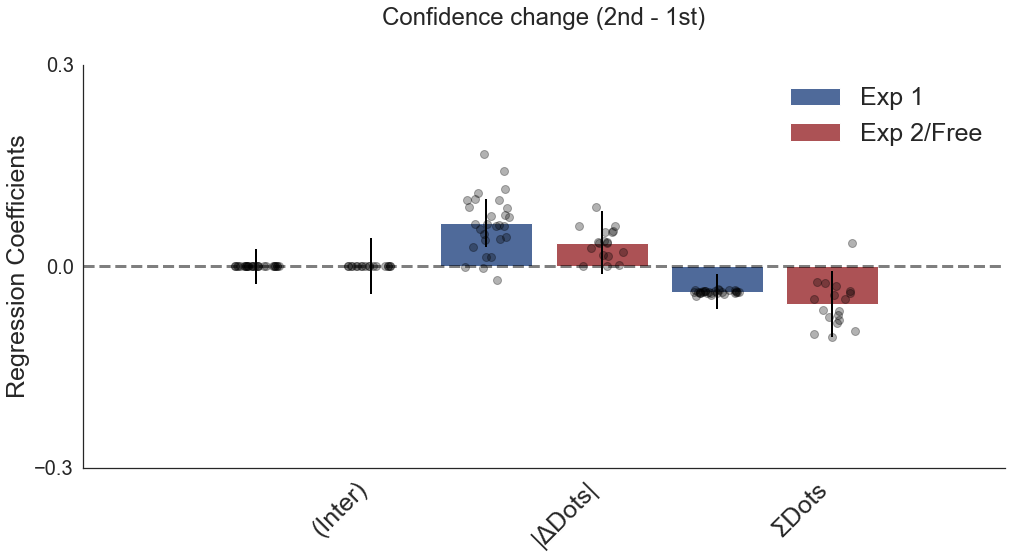

In [62]:

Coefpresplot_bar2(table_data1, par_table_data1,table_data2, par_table_data2, barcol1='#4F6A9A',barcol2='#AC5255', 
                  title='Confidence change (2nd - 1st)', size='big',ymultiple=0.3, ticklabsize=20,labels= ['Exp 1','Exp 2/Free'])
plt.ylim(-0.3, 0.3)


plt.xticks([1.25,2.25,3.25],['(Inter)','|ΔDots|','ΣDots'], rotation=45)

<a id=Figure4sup9></a>

### Figure 4-figure supplement 9

In [67]:
Data2Free_raw=pd.read_csv('../data/rawdata_exp2_free.csv')

In [68]:
Data2Free_raw['DeltaSampling']=Data2Free_raw['Left_IA_Second_Dwell_Time']-Data2Free_raw['Right_IA_Second_Dwell_Time']

In [69]:
Data2Free_raw['NonAbsDiff']=Data2Free_raw['DOTS_LEFT']-Data2Free_raw['DOTS_RIGHT']

In [70]:
Data2Free_raw['First']=[1 if Data2Free_raw['Which_First'].iloc[row]=='Left' else 0 for row in range(len(Data2Free_raw))]

In [71]:
Data2Free_raw['ZDeltaSampling']=z_score1(Data2Free_raw,'Participant',"DeltaSampling")

### Free sampling

In [72]:
# load data in R
# import new dataframe into R
r_df = pandas2ri.py2rpy(Data2Free_raw)
%R -i r_df

In [74]:
%%R
# fit hierarchical regression model predicting sampling bias as a function of choice, dot difference and confidence rating
sampling_model2 = lmer(ZDeltaSampling ~ NonAbsDiff + First+ (1 + NonAbsDiff + First | Participant), control = lmerControl(optimizer ='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model2))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ZDeltaSampling ~ NonAbsDiff + First + (1 + NonAbsDiff + First |  
    Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 11432.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.7204 -0.5637  0.0024  0.5831  4.3547 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr       
 Participant (Intercept) 0.0058428 0.07644             
             NonAbsDiff  0.0007799 0.02793   0.61      
             First       0.0233336 0.15275  -1.00 -0.63
 Residual                0.9000536 0.94871             
Number of obs: 4160, groups:  Participant, 23

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) -0.005344   0.026338 30.087721  -0.203    0.841    
NonAbsDiff   0.059763   0.006643 19.562357   8.997 2.19e-08 ***
First        0.005272   0.043509 22.063854   0.121 

In [84]:
%%R
coefs <- data.frame(coef(summary(sampling_model2)))
# coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))
coefs

      Estimate  Std..Error       df    t.value     Pr...t..
1 -0.005344019 0.026338130 30.08772 -0.2029005 8.405787e-01
2  0.059763273 0.006642899 19.56236  8.9965651 2.192769e-08
3  0.005271573 0.043508974 22.06385  0.1211606 9.046605e-01


In [86]:
# grab subject-level coefficients
%R coefs <- coef(sampling_model2)$Participant
%R -o coefs

In [89]:
# index coefficient dataframe
coefs['subject']=Data2Free_raw['Participant'].unique()

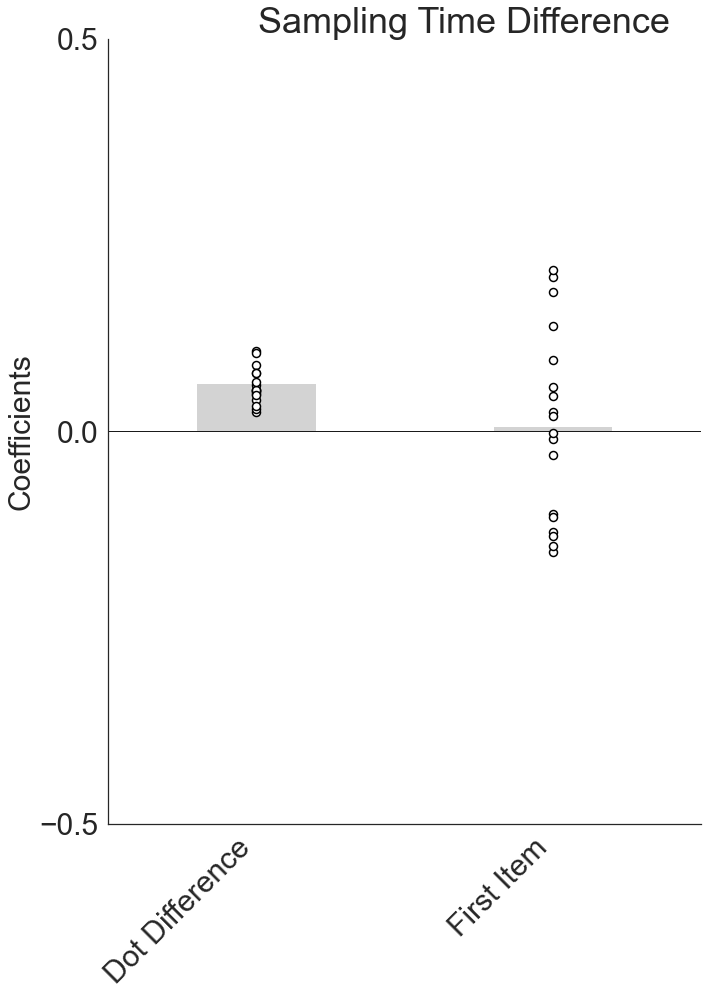

In [90]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(coefs['NonAbsDiff']), mean(coefs['First'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects2: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['NonAbsDiff'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['First'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_xlim([-0.5,1.5])
ax.set_ylim([-0.5,0.5])

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Sampling Time Difference", fontsize=36)
ttl = ax.title
ttl.set_position([0.6, 1.01])
ax.set_xticks((np.arange(2)))
yticks = np.arange(-0.5, 0.6, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(("Dot Difference", "First Item"), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')


            
plt.tight_layout()


<a id='Figure4sup10'></a>

### Figure 4-figure supplement 10

In [100]:
Splits_variables = ['ZConf1']
# Data 1
Data1['TrialNN'] = range(len(Data1))
Data1['Conf1_Split'] = splitByVar(Data1, Splits_variables,'Participant','TrialNN')

# Data 2
Data2Free['TrialNN'] = range(len(Data2Free))
Data2Free['Conf1_Split'] = splitByVar(Data2Free, Splits_variables,'Participant','TrialNN')
Data2Fixed['TrialNN'] = range(len(Data2Fixed))
Data2Fixed['Conf1_Split'] = splitByVar(Data2Fixed, Splits_variables,'Participant','TrialNN')

Splits_variables = ['ZConf2']
# Data 1
Data1['TrialNN'] = range(len(Data1))
Data1['Conf2_Split'] = splitByVar(Data1, Splits_variables,'Participant','TrialNN')

# Data 2
Data2Free['TrialNN'] = range(len(Data2Free))
Data2Free['Conf2_Split'] = splitByVar(Data2Free, Splits_variables,'Participant','TrialNN')
Data2Fixed['TrialNN'] = range(len(Data2Fixed))
Data2Fixed['Conf2_Split'] = splitByVar(Data2Fixed, Splits_variables,'Participant','TrialNN')



In [103]:
Data1['Choice1']=[1 if x =='left' else 0 for x in Data1['Response1']]
Data2Free['Choice1']=[1 if x =='left' else 0 for x in Data2Free['Response1']]
Data2Fixed['Choice1']=[1 if x =='left' else 0 for x in Data2Fixed['Response1']]

Data1['Choice2']=[1 if x =='left' else 0 for x in Data1['Response2']]
Data2Free['Choice2']=[1 if x =='left' else 0 for x in Data2Free['Response2']]
Data2Fixed['Choice2']=[1 if x =='left' else 0 for x in Data2Fixed['Response2']]


<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:

<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:

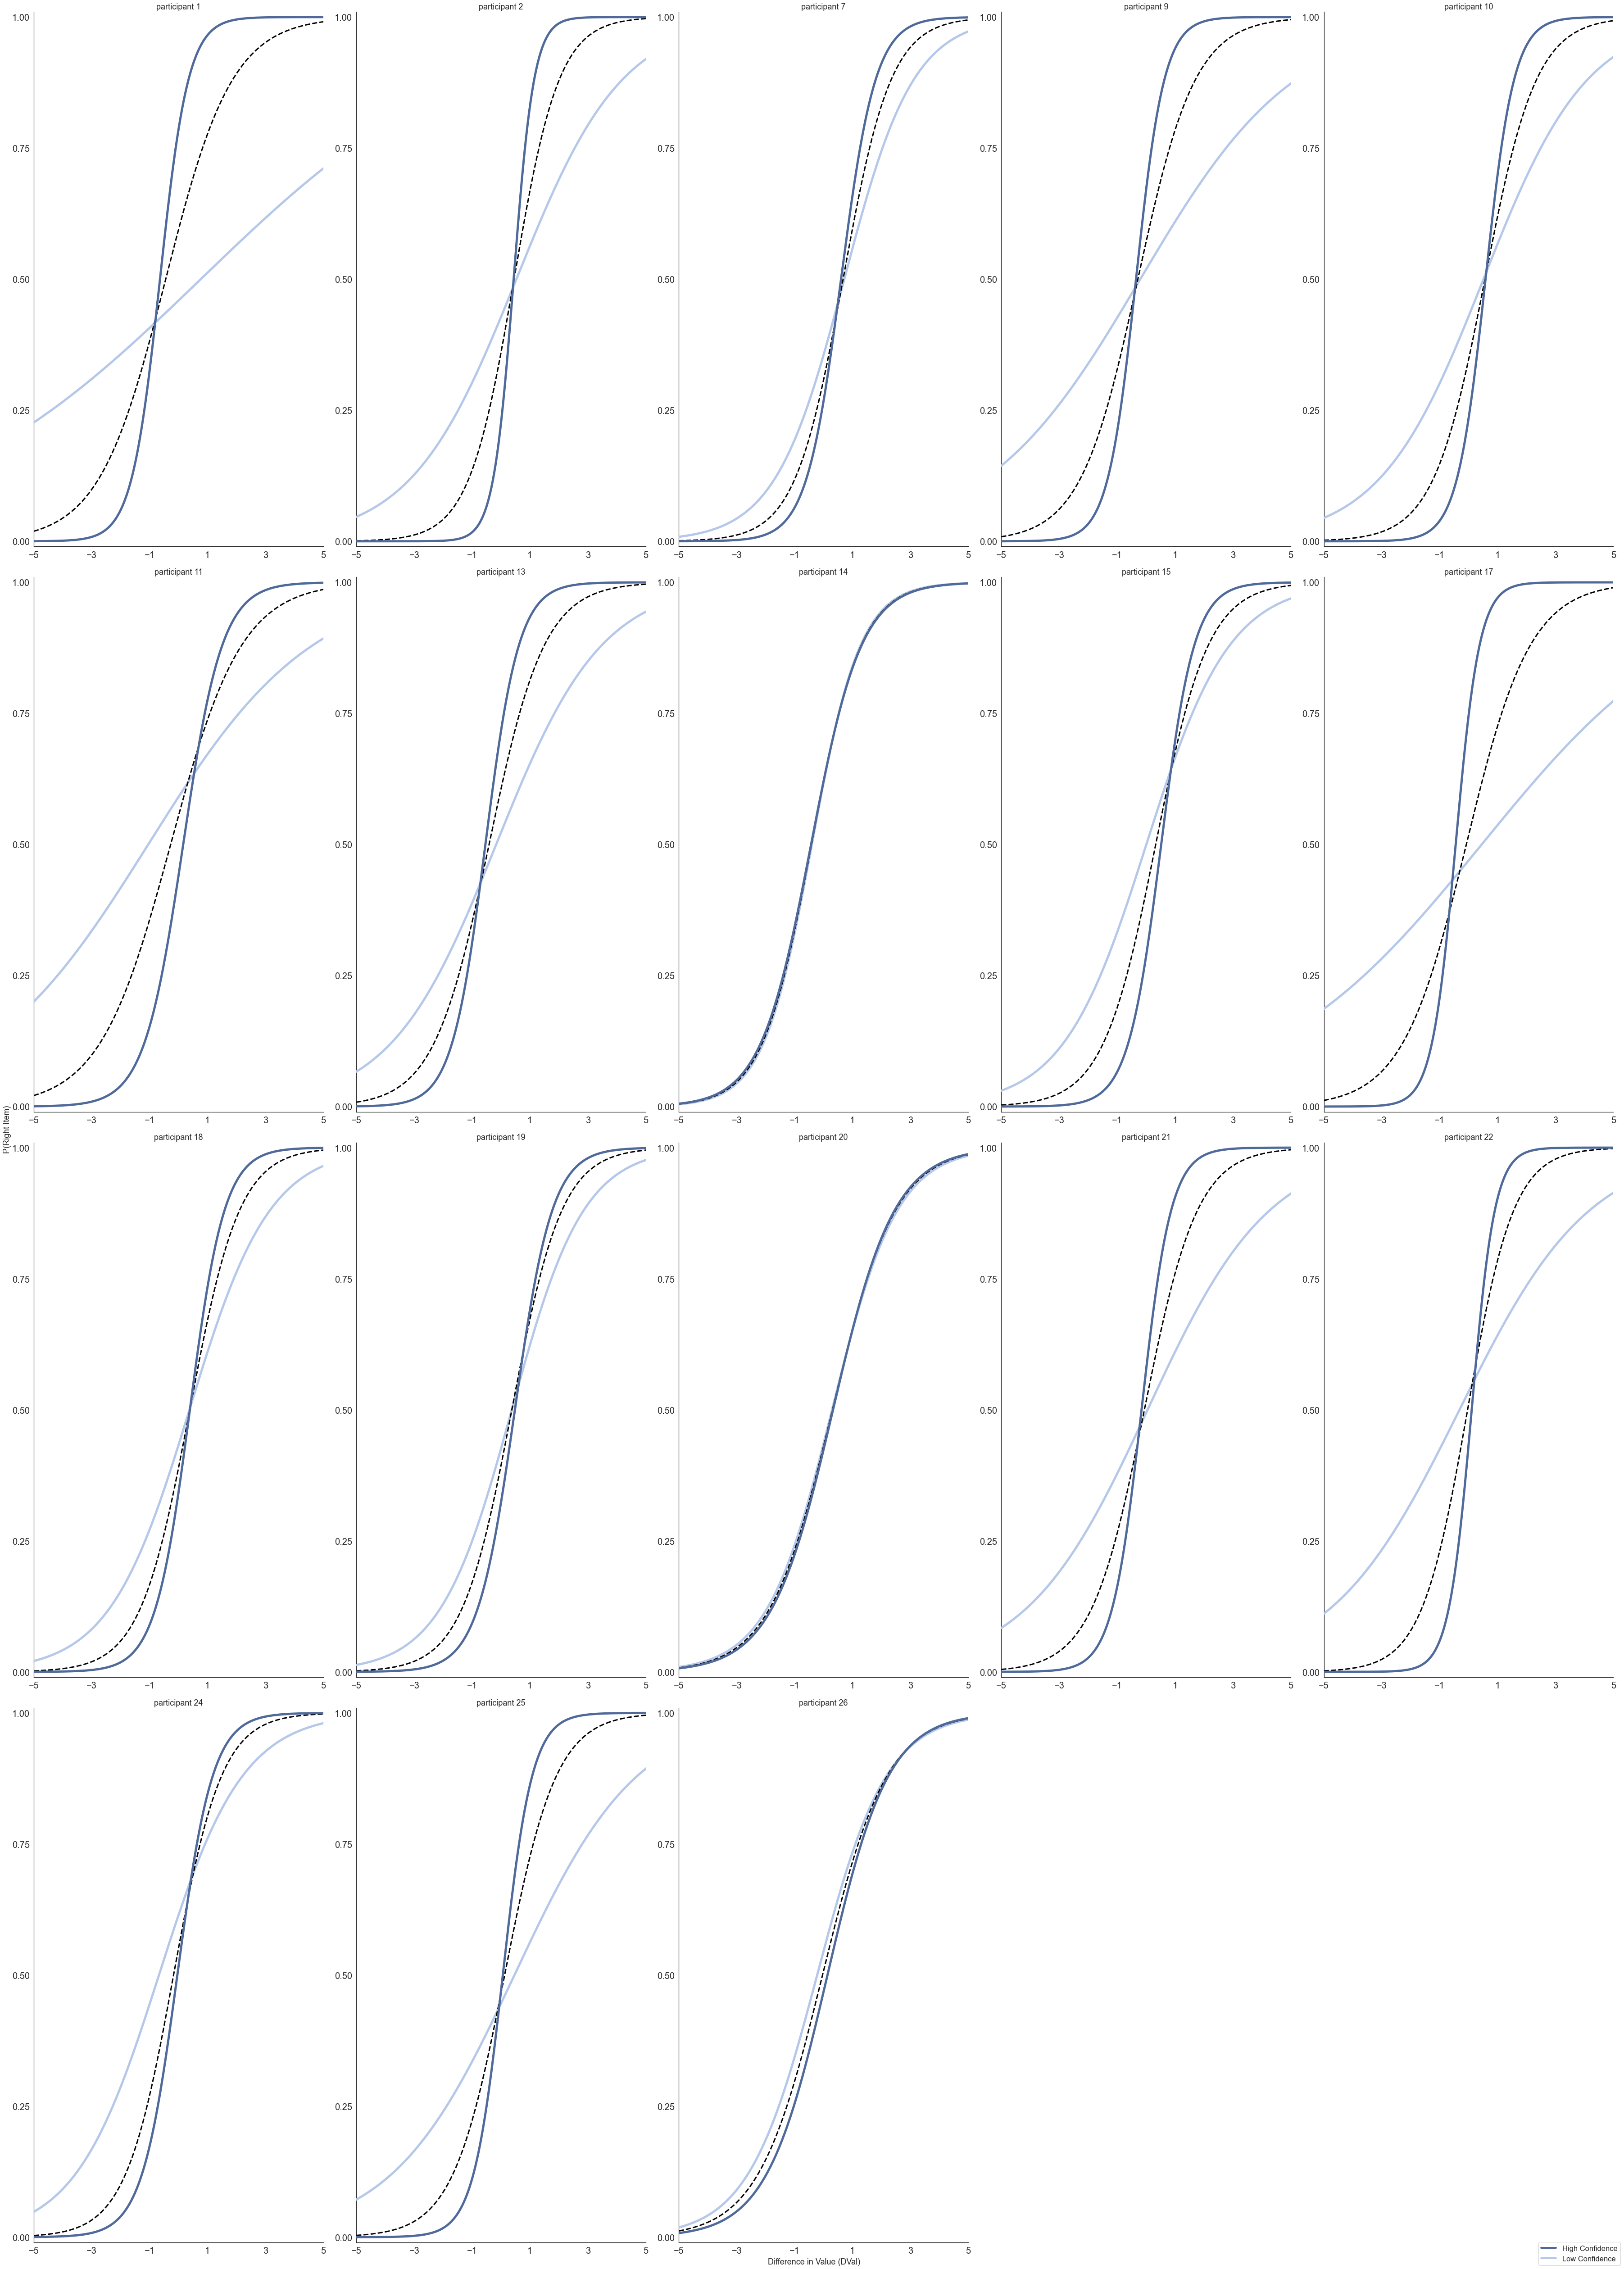

In [106]:
coef_fixed1 = logisticplot_all_sbj_slope('Conf1_Split', 'High Confidence', 'Low Confidence', data=Data2Fixed, xaxis='ZNonAbsDiff', yaxis='Choice1', ylab='P(Right Item)', xlab='Difference in Value (DVal)',
                 modhighcol='#4F6A9A', modlowcol='#B5C8E9', title='empty', parvar='Participant')
plt.tight_layout()

<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:

<ipython-input-91-183a388b0f87>:82: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in[xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensi

<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:

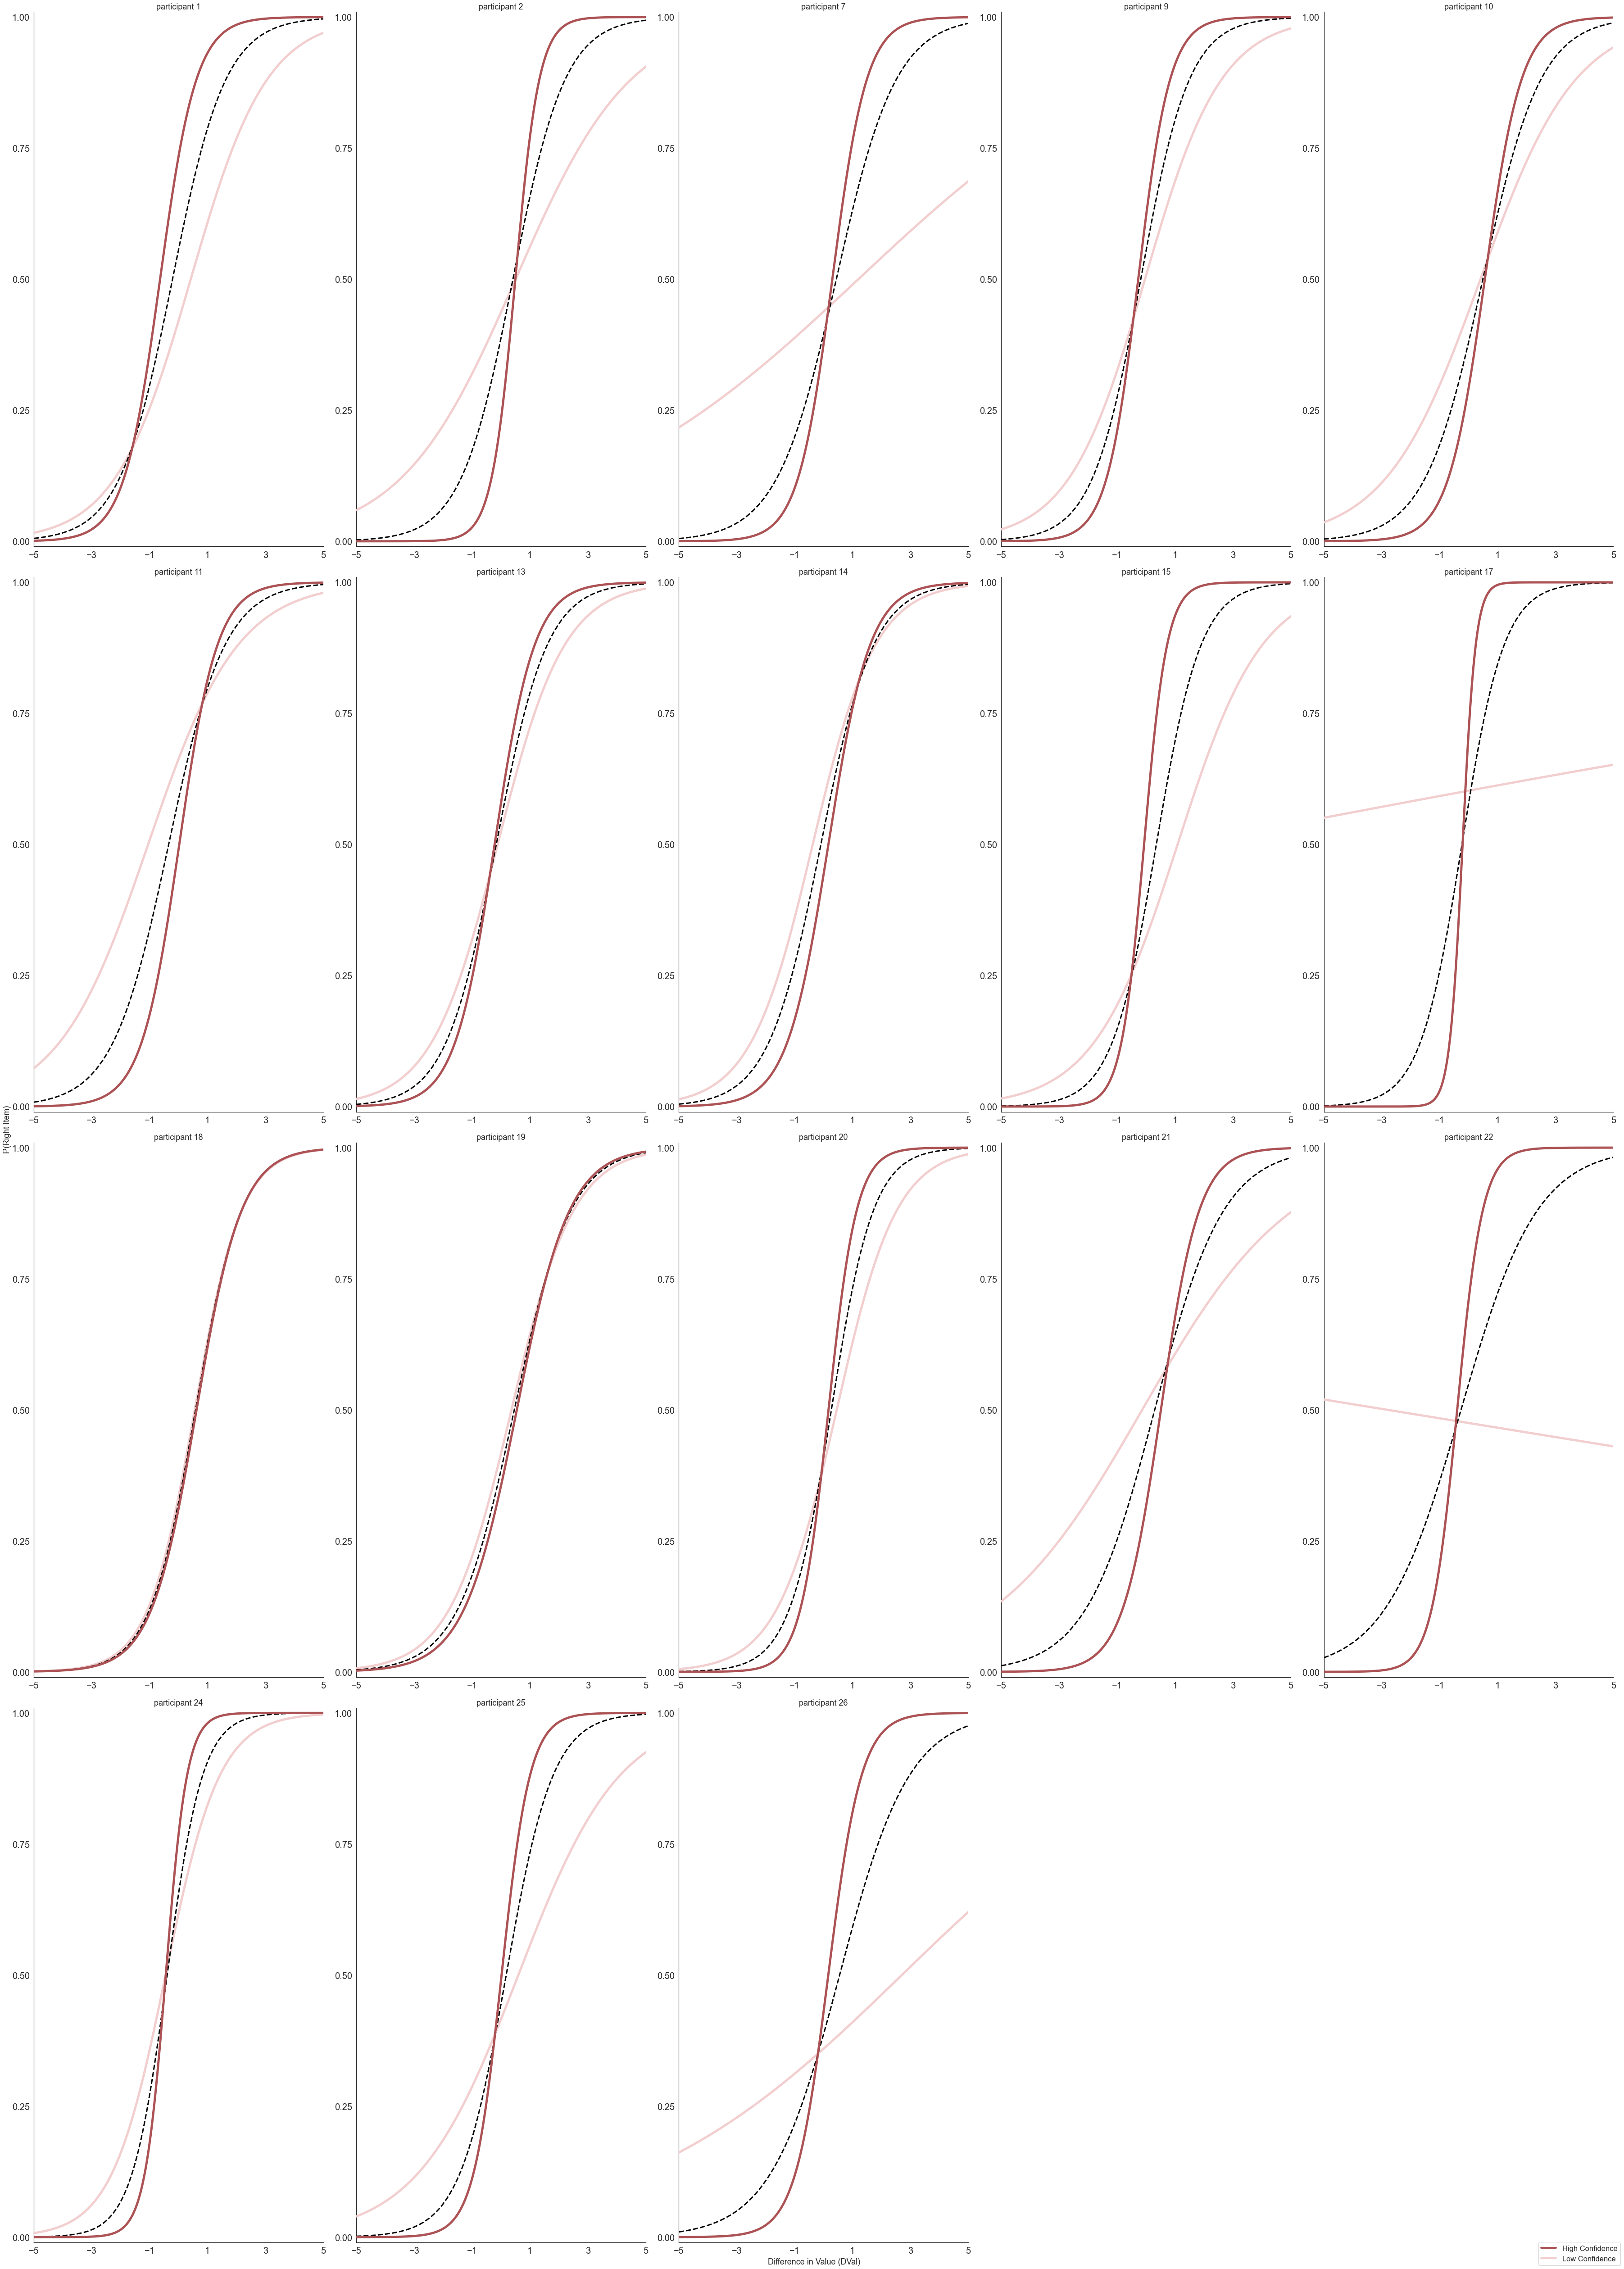

In [107]:
coef_free1 = logisticplot_all_sbj_slope('Conf1_Split', 'High Confidence', 'Low Confidence', data=Data2Free, xaxis='ZNonAbsDiff', yaxis='Choice1', ylab='P(Right Item)', xlab='Difference in Value (DVal)',
                 modhighcol='#AC5255', modlowcol='#F2CECF', title='empty', parvar='Participant')
plt.tight_layout()

In [108]:
coef_free1

Participant  Low Coef  Low Intercept  High Coef  High Intercept  All Coef  \
0           1.0  0.758487      -0.320116   1.592230        1.015831  1.085222   
1           2.0  0.502030      -0.253016   2.410548       -1.189671  1.109187   
2           7.0  0.206749      -0.248859   1.676472       -0.506736  0.966480   
3           9.0  0.756473       0.028262   1.816326        0.491436  1.189425   
4          10.0  0.607888      -0.249831   1.576568       -0.886251  0.997439   
5          11.0  0.643121       0.676470   1.512207       -0.037149  1.025475   
6          13.0  0.862589       0.101767   1.441844        0.321708  1.133763   
7          14.0  0.922653       0.346141   1.384574       -0.230949  1.094178   
8          15.0  0.682282      -0.743085   2.510682        0.172800  1.290777   
9          17.0  0.042377       0.416224   4.392628        0.912825  1.368941   
10         18.0  1.229233      -0.687430   1.278432       -0.795340  1.259033   
11         19.0  0.929081      -0.335115   1.093369       -0.596073  1.020477   
12         20.0  0.961636      -0.438331   2.048029       -0.351683  1.371078   
13         21.0  0.382201       0.050534   1.504639       -0.772182  0.836162   
14         22.0 -0.035909      -0.101542   2.256004        0.887802  0.756615   
15         24.0  1.066317       0.477844   2.717148        1.197694  1.630704   
16         25.0  0.569677      -0.340158   2.034441       -0.036624  1.234427   
17         26.0  0.213832      -0.578230   1.737228       -0.283300  0.828758   

    All Intercept  
0        0.225627  
1       -0.455184  
2       -0.426658  
3        0.217969  
4       -0.491472  
5        0.351236  
6        0.188108  
7        0.101868  
8       -0.458012  
9        0.314398  
10      -0.739578  
11      -0.467433  
12      -0.369815  
13      -0.250058  
14       0.197065  
15       0.641803  
16      -0.220060  
17      -0.459588

In [109]:
coef_fixed1

Participant  Low Coef  Low Intercept  High Coef  High Intercept  All Coef  \
0           1.0  0.212833      -0.163419   2.028762        1.300766  0.863929   
1           2.0  0.545759      -0.289423   2.819248       -1.228438  1.277757   
2           7.0  0.832384      -0.595284   1.669665       -1.007695  1.201711   
3           9.0  0.371138       0.074041   2.038790        0.707690  1.004739   
4          10.0  0.555942      -0.285921   2.021535       -1.183738  1.120948   
5          11.0  0.350509       0.367148   1.475345       -0.237352  0.811817   
6          13.0  0.546232       0.092066   1.721041        0.930310  1.042882   
7          14.0  1.184121       0.477669   1.140939        0.492373  1.163862   
8          15.0  0.691634      -0.006513   1.740674       -0.910837  1.095850   
9          17.0  0.270257      -0.122603   2.413878        1.075014  0.901024   
10         18.0  0.717635      -0.270069   1.665987       -0.652057  1.159984   
11         19.0  0.803161      -0.297740   1.542965       -0.737575  1.152515   
12         20.0  0.883982      -0.259105   0.937768       -0.306753  0.914864   
13         21.0  0.473308      -0.025165   1.949825        0.304290  1.088231   
14         22.0  0.444102       0.139290   2.498784       -0.270092  1.251603   
15         24.0  0.689156       0.466104   1.628005        0.067132  1.199217   
16         25.0  0.468974      -0.217021   1.958866       -0.118557  1.112739   
17         26.0  0.831742       0.184458   0.944927       -0.127896  0.892466   

    All Intercept  
0        0.383326  
1       -0.573272  
2       -0.810415  
3        0.285044  
4       -0.633819  
5        0.221758  
6        0.432209  
7        0.482276  
8       -0.365081  
9        0.070367  
10      -0.450058  
11      -0.429632  
12      -0.280038  
13       0.062923  
14       0.042538  
15       0.206627  
16      -0.138081  
17       0.032061

<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:

<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:

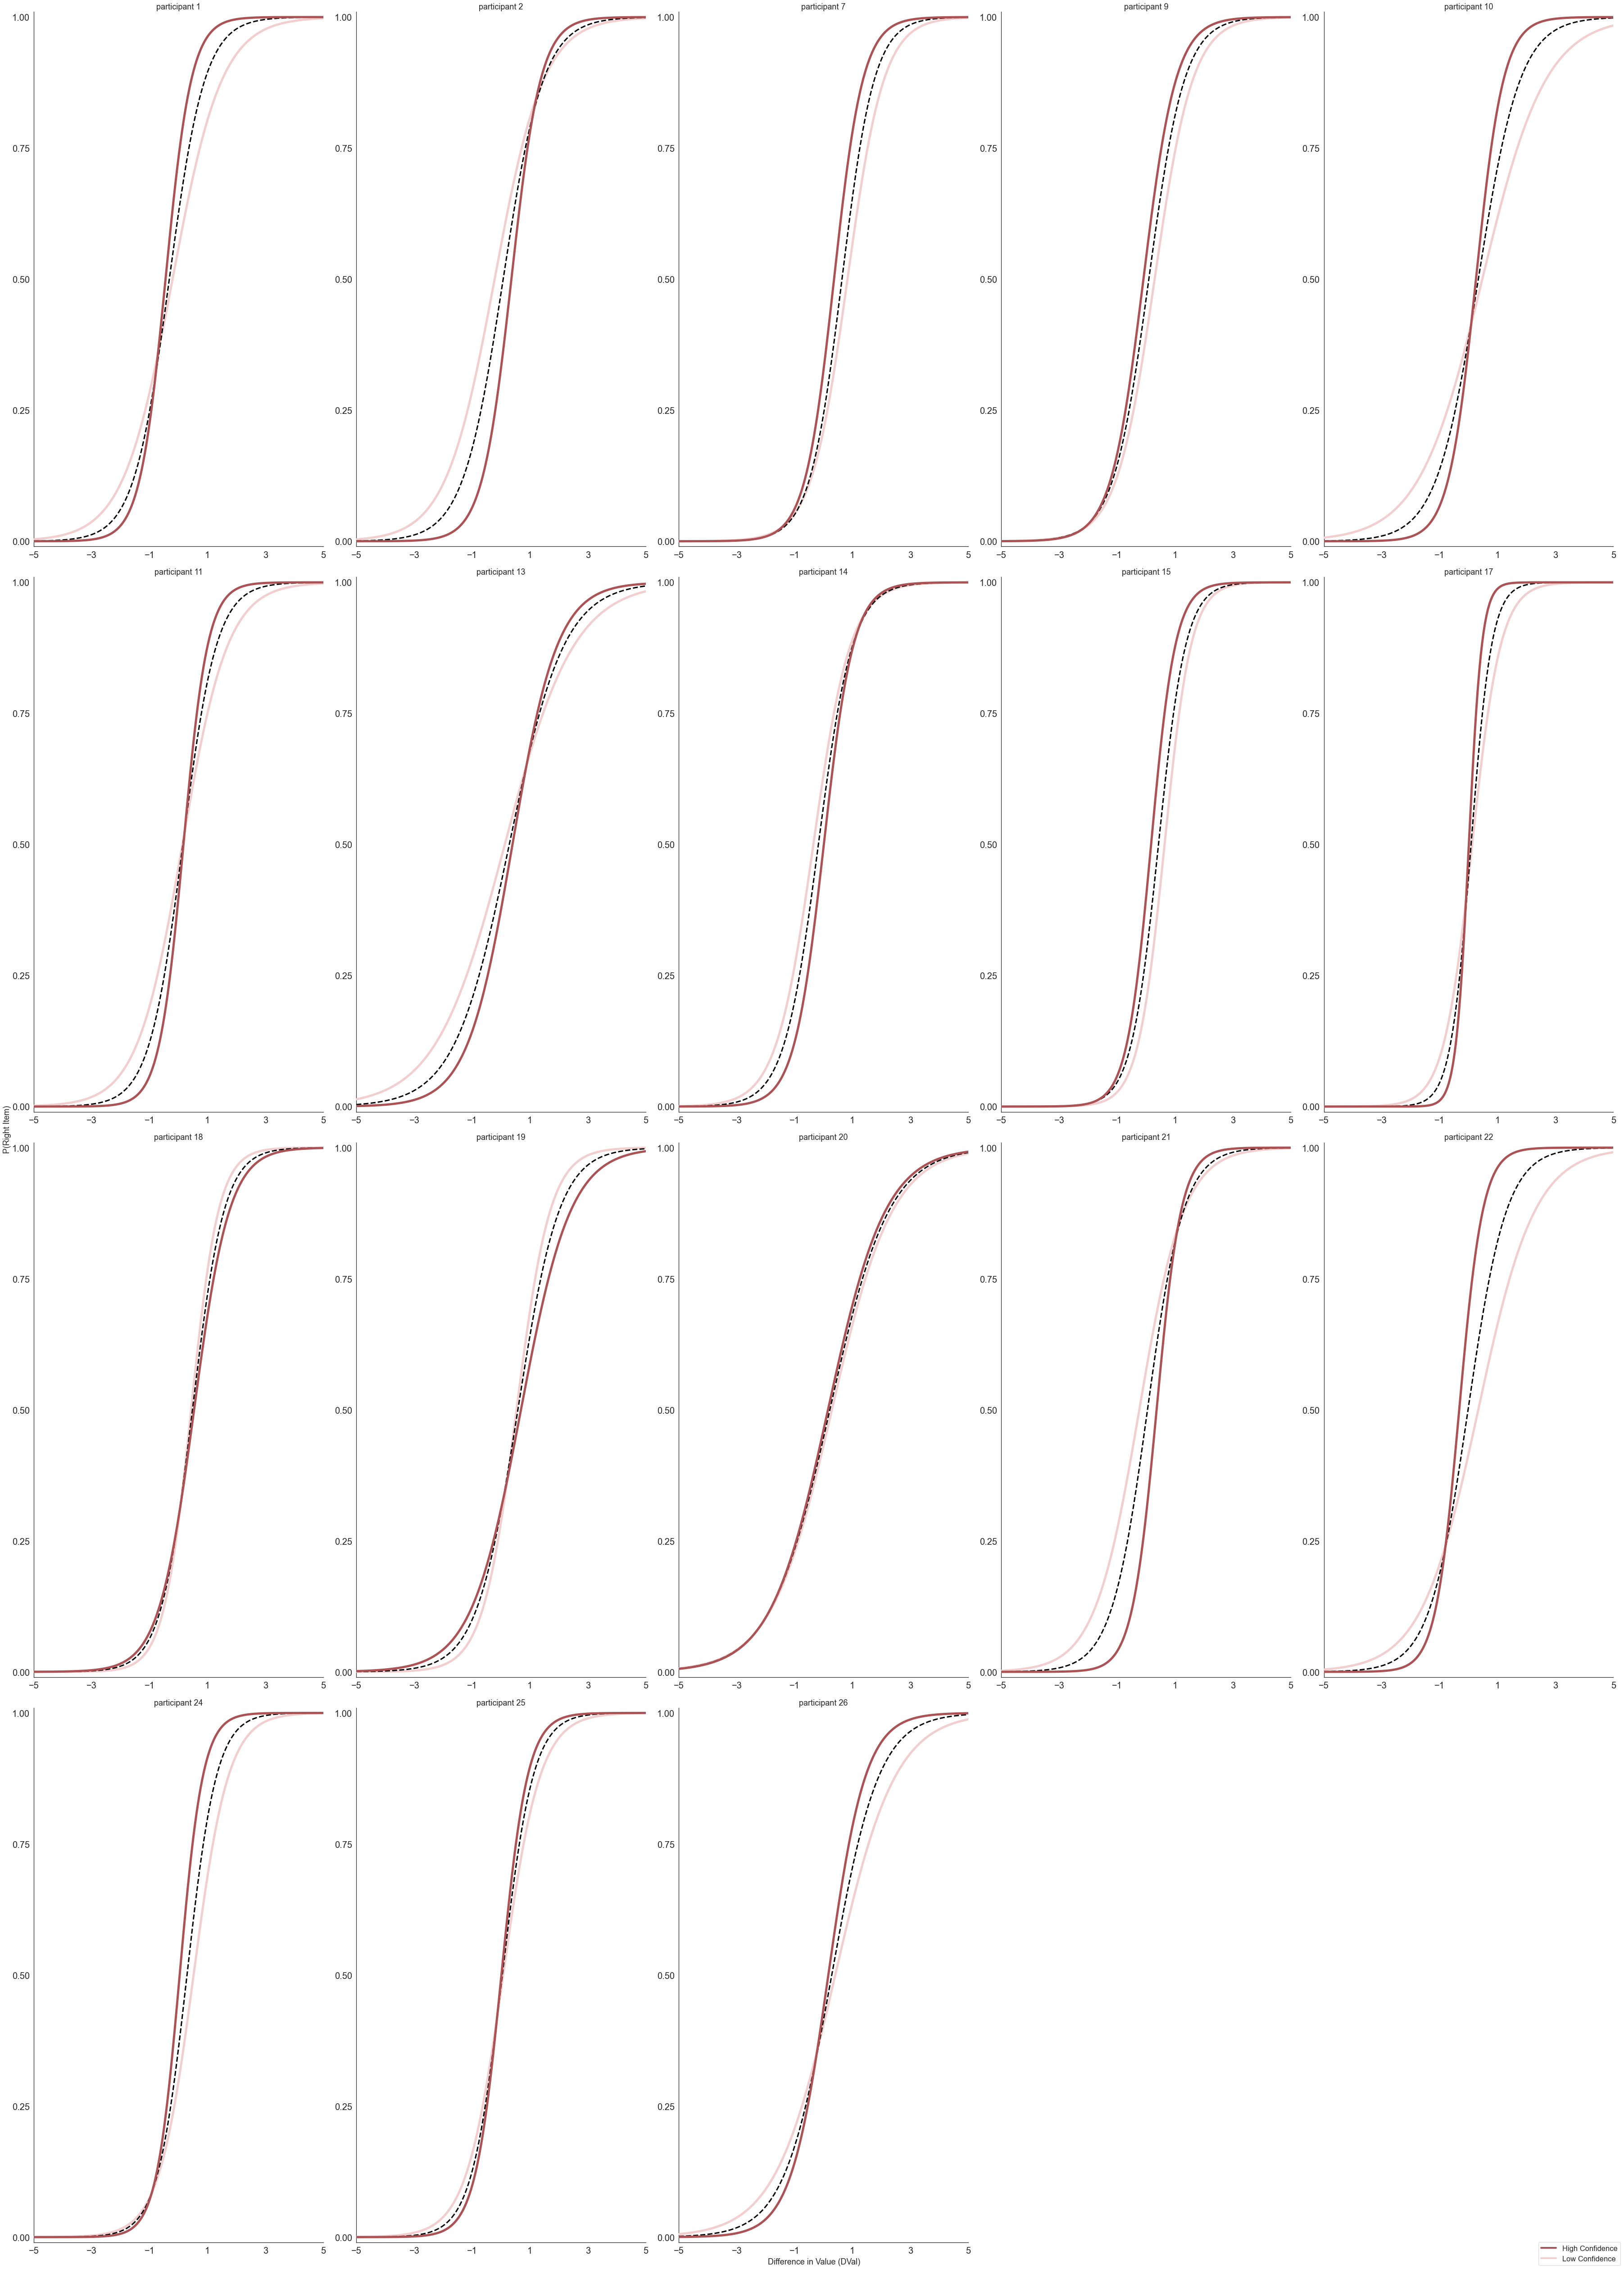

In [104]:
coef_free2 = logisticplot_all_sbj_slope('Conf1_Split', 'High Confidence', 'Low Confidence', data=Data2Free, xaxis='ZNonAbsDiff', yaxis='Choice2', ylab='P(Right Item)', xlab='Difference in Value (DVal)',
                 modhighcol='#AC5255', modlowcol='#F2CECF', title='empty', parvar='Participant')


<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:

<ipython-input-91-183a388b0f87>:70: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:82: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in[xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
<ipython-input-91-183a388b0f87>:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  clf.fit(data_in.loc[data

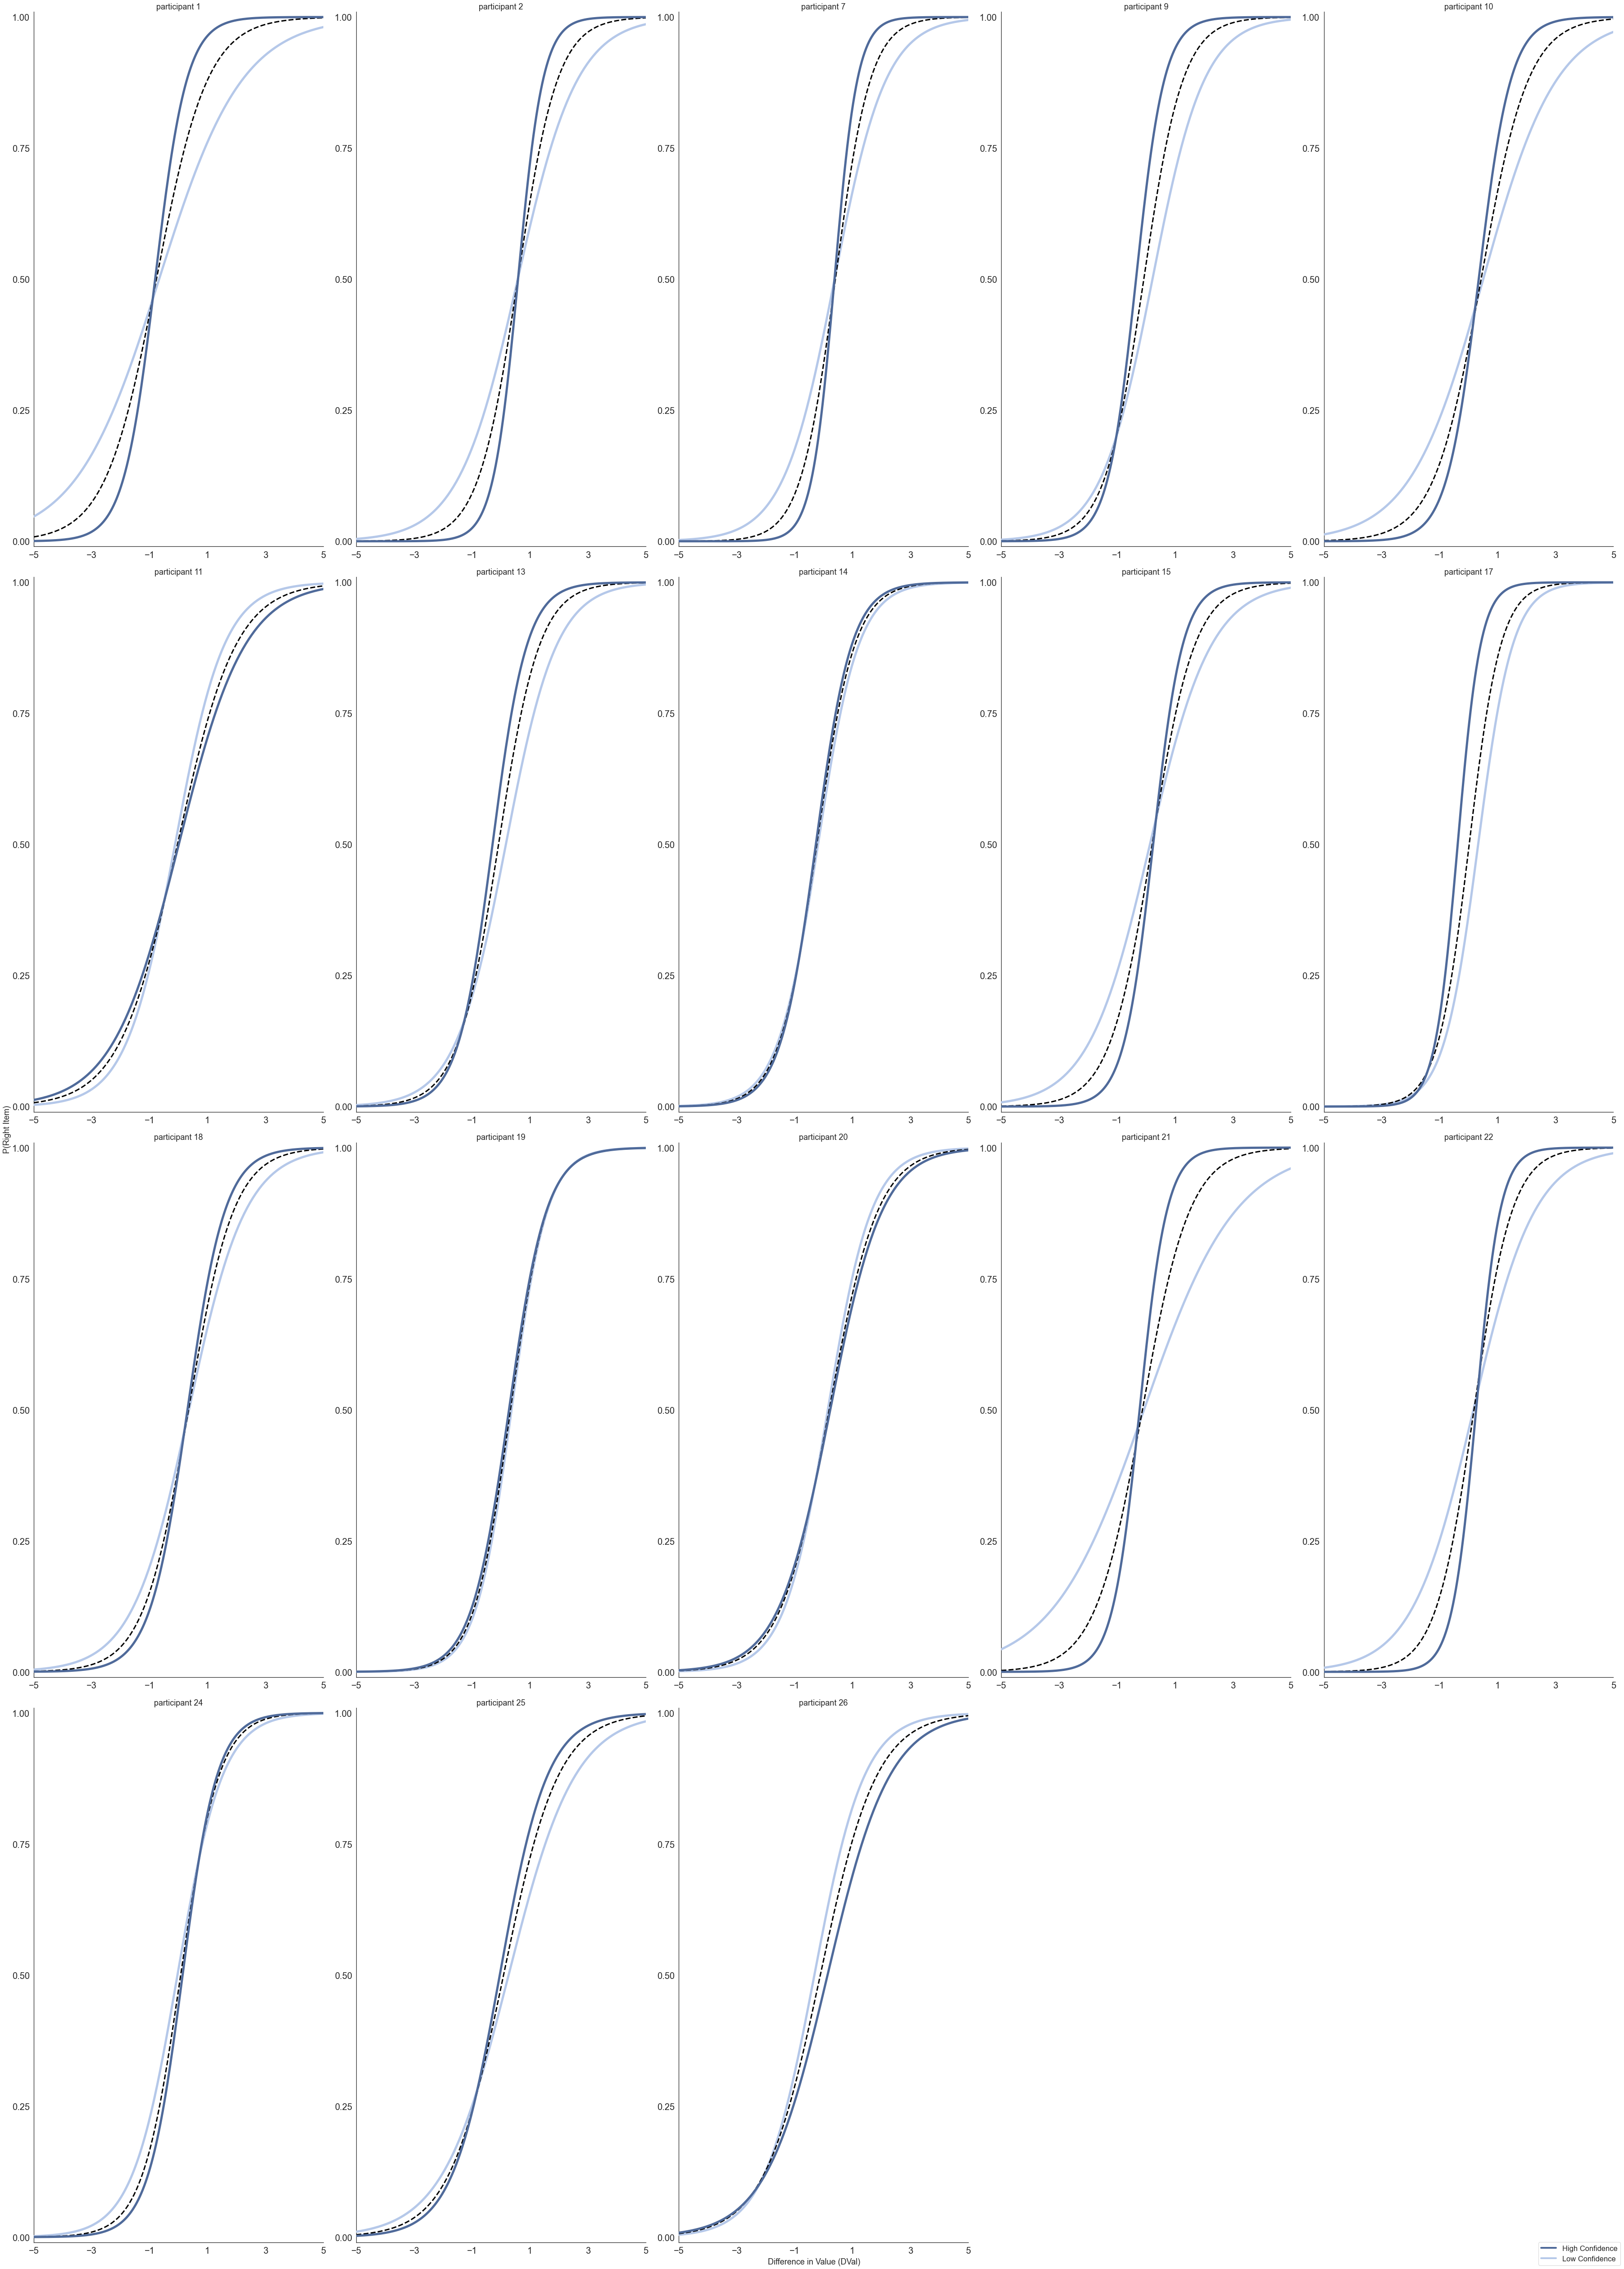

In [105]:
coef_fixed2 = logisticplot_all_sbj_slope('Conf1_Split', 'High Confidence', 'Low Confidence', data=Data2Fixed, xaxis='ZNonAbsDiff', yaxis='Choice2', ylab='P(Right Item)', xlab='Difference in Value (DVal)',
                 modhighcol='#4F6A9A', modlowcol='#B5C8E9', title='empty', parvar='Participant')
plt.tight_layout()

In [110]:
coef_free2

Participant  Low Coef  Low Intercept  High Coef  High Intercept  All Coef  \
0           1.0  1.166105       0.242942   2.240015        1.008091  1.622795   
1           2.0  1.177871       0.262896   1.974085       -0.704574  1.434380   
2           7.0  1.584400      -1.309051   1.994606       -0.720869  1.786365   
3           9.0  1.512199      -0.446590   1.775036        0.162489  1.616430   
4          10.0  0.908709      -0.430449   2.094015       -0.534533  1.376985   
5          11.0  1.271089      -0.169887   2.378026       -0.402748  1.713495   
6          13.0  0.831910      -0.106947   1.283996       -0.506247  1.052428   
7          14.0  1.550501       0.546528   1.947641       -0.017166  1.682867   
8          15.0  2.174352      -1.387808   2.373509       -0.411252  2.116211   
9          17.0  2.019953      -0.249658   4.422600       -0.040431  2.804655   
10         18.0  2.097581      -0.911956   1.629103       -0.874746  1.817158   
11         19.0  1.706704      -0.911850   1.156846       -0.796212  1.394275   
12         20.0  0.949497      -0.272860   1.002047       -0.153639  0.974294   
13         21.0  1.289640       0.302094   2.345089       -0.852744  1.596486   
14         22.0  1.015220      -0.338827   2.439086        0.790783  1.495153   
15         24.0  1.650203      -0.857737   2.473343       -0.095749  1.951082   
16         25.0  1.554620      -0.112767   2.193591       -0.026262  1.862257   
17         26.0  0.955731      -0.385540   1.543987       -0.253567  1.218276   

    All Intercept  
0        0.517484  
1       -0.104627  
2       -1.137126  
3       -0.153691  
4       -0.462953  
5       -0.253771  
6       -0.298620  
7        0.300833  
8       -0.907876  
9       -0.240342  
10      -0.872629  
11      -0.810669  
12      -0.211589  
13      -0.078297  
14       0.027418  
15      -0.570163  
16      -0.078666  
17      -0.343447

In [111]:
coef_fixed2

Participant  Low Coef  Low Intercept  High Coef  High Intercept  All Coef  \
0           1.0  0.694188       0.466108   1.820010        1.471626  1.128646   
1           2.0  0.967756      -0.559206   2.304805       -1.350851  1.454171   
2           7.0  1.122010      -0.427860   2.521625       -0.952517  1.646860   
3           9.0  1.111834      -0.245700   2.038790        0.707690  1.468782   
4          10.0  0.785808      -0.397081   1.796645       -0.629496  1.221135   
5          11.0  1.174288       0.142363   0.870757       -0.005968  0.989067   
6          13.0  1.135517      -0.188772   1.675258        0.494983  1.405211   
7          14.0  1.419301       0.273086   1.609660        0.428759  1.518448   
8          15.0  0.938433      -0.124540   1.957258       -0.478827  1.352903   
9          17.0  1.671326      -0.553264   2.525460        0.950984  1.824842   
10         18.0  1.016080      -0.366921   1.534875       -0.473975  1.277702   
11         19.0  1.610399      -0.583962   1.533369       -0.420850  1.577369   
12         20.0  1.314994      -0.194916   1.107551       -0.256067  1.182743   
13         21.0  0.628792       0.044578   2.110267        0.468526  1.216064   
14         22.0  0.936484      -0.156279   2.393644       -0.624193  1.506411   
15         24.0  1.279714       0.048635   1.676497       -0.234780  1.506925   
16         25.0  0.867719      -0.225977   1.212151        0.053739  1.054559   
17         26.0  1.151213       0.365110   0.927995       -0.127918  1.023159   

    All Intercept  
0        0.862177  
1       -0.842534  
2       -0.672627  
3        0.115415  
4       -0.527149  
5        0.038201  
6        0.122914  
7        0.356280  
8       -0.282893  
9       -0.038556  
10      -0.441292  
11      -0.511843  
12      -0.228989  
13       0.153556  
14      -0.282547  
15      -0.110697  
16      -0.091400  
17       0.114566

ChoiceSlopes: MeanL = 1.6397551195122768; MeanD = 1.3530554168158728; [Like - Dislike] =  0.286699702696404; t =  3.2 ; p-value =0.005202300782992781


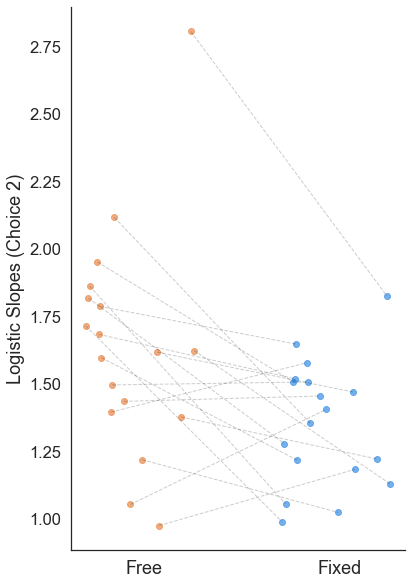

In [114]:
ttestsPlot( coef_free2['All Coef'], coef_fixed2['All Coef'],'#EA8B4C','#3C91E6',"Free",  "Fixed",title = 'Logistic Slopes (Choice 2)')


/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value enc

[[0.20505161]]
[[0.19460993]]


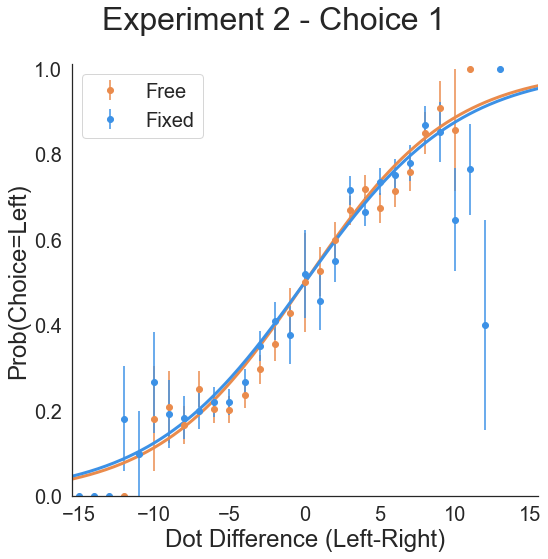

In [119]:
fig=figure(figsize=(8,8))
fig.suptitle('Experiment 2 - Choice 1', fontsize = 32)
logistic_regression2(Data2Free,Data2Fixed, 'Free', 'Fixed', 'Choice1')

/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/paulak/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value enc

[[0.30588764]]
[[0.25688982]]


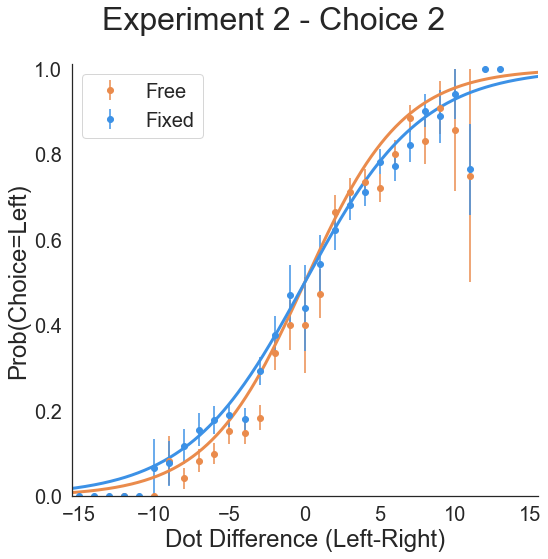

In [121]:
fig=figure(figsize=(8,8))
fig.suptitle('Experiment 2 - Choice 2', fontsize = 32)
logistic_regression2(Data2Free,Data2Fixed, 'Free', 'Fixed', 'Choice2')

<a id='Figure4sup11'></a>

### Figure 4-figure supplement 11

In [122]:
free_var1 = []
fixed_var1 = []
for i in Data2Free.Participant.unique():
    free_type = Data2Free.groupby(['Participant','Type'])['Trial'].count()
    free_var1.append(free_type[i,'Incorrect to correct'])
for i in Data2Fixed.Participant.unique():
    fix_type = Data2Fixed.groupby(['Participant','Type'])['Trial'].count()
    fixed_var1.append(fix_type[i,'Incorrect to correct'])

ChoiceSlopes: MeanL = 17.27777777777778; MeanD = 15.0; [Like - Dislike] =  2.2777777777777786; t =  1.42 ; p-value =0.1737547217542234


Text(0.5, 1.0, 'Incorrect to correct trials')

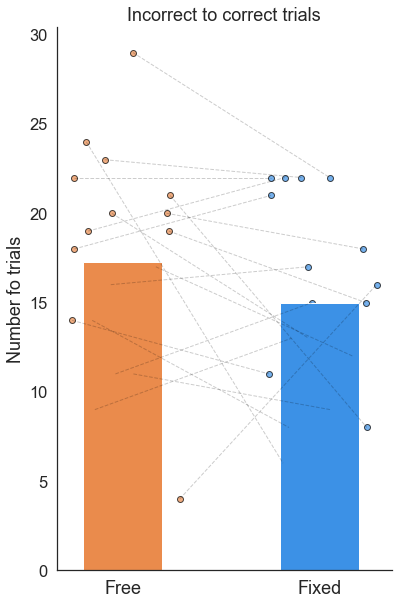

In [125]:
ttestsPlotBars(free_var1, fixed_var1,'#EA8B4C','#3C91E6', "Free", "Fixed",title = 'Number fo trials')
#plt.ylim(0.5, 1)
plt.title('Incorrect to correct trials')

In [126]:
free_var3 = []
fixed_var3 = []
for i in Data2Free.Participant.unique():
    free_type = Data2Free.groupby(['Participant','Type'])['Trial'].count()
    free_var3.append((free_type[i,'Correct to incorrect'] + free_type[i,'Incorrect to correct'])/126)
for i in Data2Fixed.Participant.unique():
    fix_type = Data2Fixed.groupby(['Participant','Type'])['Trial'].count()
    fixed_var3.append((fix_type[i,'Correct to incorrect'] + fix_type[i,'Incorrect to correct']) / 126)

ChoiceSlopes: MeanL = 0.20943562610229277; MeanD = 0.19400352733686066; [Like - Dislike] =  0.015432098765432112; t =  0.75 ; p-value =0.46586281673854246


Text(0.5, 1.0, 'Change of mind proportion')

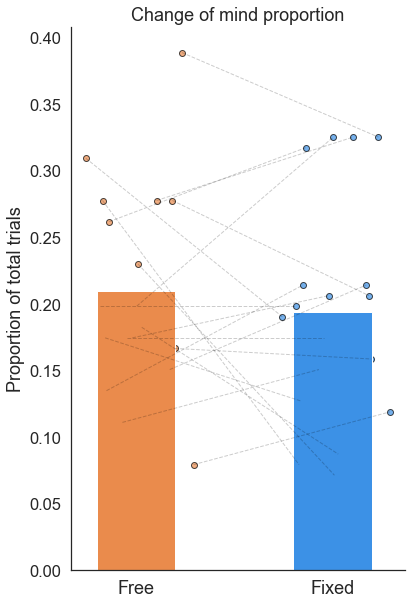

In [127]:
ttestsPlotBars(free_var3, fixed_var3,'#EA8B4C','#3C91E6', "Free", "Fixed",title = 'Proportion of total trials')
#plt.ylim(0.5, 1)
plt.title('Change of mind proportion')

<a id='Figure4sup12'></a>

### Figure 4-figure supplement 12

ChoiceSlopes: MeanL = 0.6915993445032335; MeanD = 0.7243461245456637; [Like - Dislike] =  -0.03274678004243026; t =  -1.38 ; p-value =0.18508434021404488


Text(0.5, 1.0, 'Confidence Choice 1')

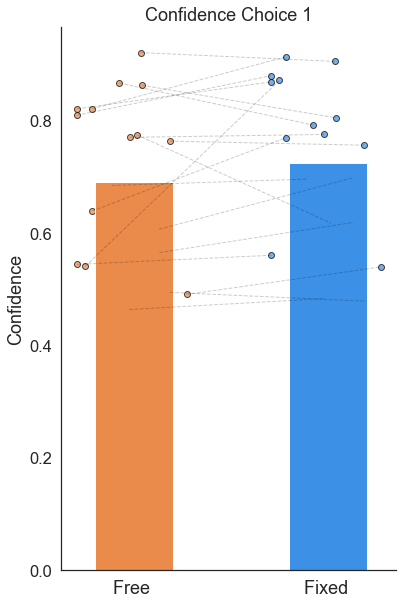

In [128]:
ttestsPlotBars(Data2Free.groupby(['Participant']).mean()['Conf1'].values
         , Data2Fixed.groupby(['Participant']).mean()['Conf1'].values
,'#EA8B4C','#3C91E6',"Free ",  "Fixed ",title = 'Confidence')
#plt.ylim(0.5, 1)
plt.title('Confidence Choice 1')

ChoiceSlopes: MeanL = 0.7560730430629041; MeanD = 0.7440694748715591; [Like - Dislike] =  0.012003568191345071; t =  0.5 ; p-value =0.6211318055803314


Text(0.5, 1.0, 'Confidence Choice 2')

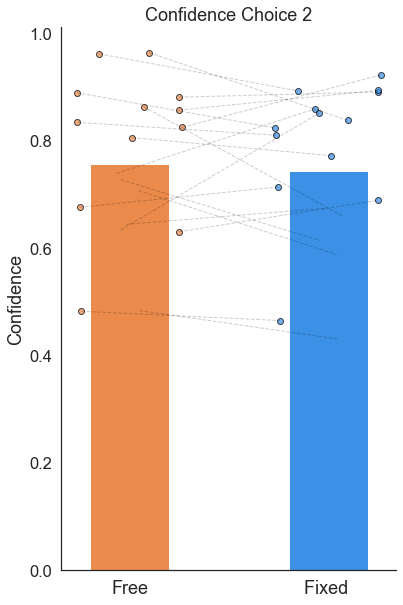

In [129]:
ttestsPlotBars(Data2Free.groupby(['Participant']).mean()['Conf2'].values
         , Data2Fixed.groupby(['Participant']).mean()['Conf2'].values
,'#EA8B4C','#3C91E6',"Free",  "Fixed ",title = 'Confidence')
#plt.ylim(0.5, 1)
plt.title('Confidence Choice 2')

<a id=Saccades></a>

### Saccades

In [160]:
# make new dataframe for t-test
DF3=pd.DataFrame(data=[])
DF3['subject']=subjects2
DF3['FreeSaccades']= [float(mean(Data2Free[Data2Free['participant']==x]['Internal_Saccades'])) for x in DF3['subject']]
DF3['FixedSaccades']=[float(mean(Data2Fixed[Data2Fixed['participant']==x]['Internal_Saccades'])) for x in DF3['subject']]


In [161]:
# test if there were more 
sp.stats.ttest_rel(DF3['FreeSaccades'],DF3['FixedSaccades'])

Ttest_relResult(statistic=-4.221057153034456, pvalue=0.0005749020430666255)

<a id=ModelComp></a>

### Appendix

#### Sampling Time Models Study 1

In [109]:
## z-score RT for inclusion in the model
Data1.head()
Data1['ZRT'] = (Data1['RT1']-Data1.groupby(level='Participant')['RT1'].mean())/Data1.groupby(level = 'Participant')['RT1'].std()
# Are the mean Z-scores all close to 0?
Data1.groupby(level=0)['ZRT'].mean()


Participant
1    -7.049916e-17
2    -6.272760e-17
3    -3.108624e-17
4     5.965367e-16
5     2.148282e-16
6     4.579670e-18
7    -1.221245e-17
8    -7.327472e-17
9    -1.908196e-16
10    3.420875e-16
11   -2.386980e-17
12   -1.949829e-16
13    6.139533e-16
14   -1.176004e-15
16   -1.052491e-15
17    1.532108e-16
18   -3.330669e-18
19   -3.708145e-16
20   -2.364775e-16
21    3.910761e-16
22   -2.001871e-17
23   -2.015055e-16
24    1.854072e-16
25   -1.273426e-15
26   -2.499390e-16
27    5.628831e-16
29   -1.459943e-16
30    4.990452e-16
Name: ZRT, dtype: float64

In [110]:
# load data in R
r_df = pandas2ri.py2ri(Data1)
%R -i r_df

In [99]:
%%R
# sampling model 1
sampling_model1 = lmer(ZDeltaSampling ~ Choice + (1 + Choice | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model1))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + (1 + Choice | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14909

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3594 -0.6442  0.0009  0.6597  4.5117 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 Participant (Intercept) 0.02551  0.1597        
             Choice      0.06971  0.2640   -0.99
 Residual                0.83013  0.9111        
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.41865    0.03514  -11.91
Choice       0.77617    0.05557   13.97

Correlation of Fixed Effects:
       (Intr)
Choice -0.925


In [100]:
%%R
# sampling model 2
sampling_model2 = lmer(ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model2))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14626.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1694 -0.6376  0.0054  0.6420  4.5051 

Random effects:
 Groups      Name        Variance Std.Dev. Corr
 Participant (Intercept) 0.000000 0.00000      
             NonAbsDiff  0.000616 0.02482   NaN
 Residual                0.788630 0.88805      
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.004333   0.011897   0.364
NonAbsDiff  0.076841   0.005168  14.868

Correlation of Fixed Effects:
           (Intr)
NonAbsDiff 0.003 


In [101]:
%%R
# sampling model 3
sampling_model3 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model3))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff |  
    Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14283.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3394 -0.6346 -0.0022  0.6399  4.5462 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr     
 Participant (Intercept) 0.0000000 0.00000           
             Choice      0.0085505 0.09247   NaN     
             NonAbsDiff  0.0004932 0.02221   NaN 0.49
 Residual                0.7391087 0.85971           
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
             Estimate Std. Error t value
(Intercept) -0.252285   0.017981  -14.03
Choice       0.480588   0.031209   15.40
NonAbsDiff   0.057574   0.004805   11.98

Correlation of Fixed Effects:
           (Intr) Choice
Choice     -0.635       
NonAbsDiff  0.169  0.058


In [102]:
%%R
# sampling model 4
sampling_model4 = lmer(ZDeltaSampling ~ Choice + ZConf1 + Choice*ZConf1 + (1 + Choice + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model4))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + ZConf1 + Choice * ZConf1 + (1 + Choice +  
    ZConf1 + Choice * ZConf1 | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14674.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3376 -0.6333 -0.0050  0.6435  4.5586 

Random effects:
 Groups      Name          Variance Std.Dev. Corr             
 Participant (Intercept)   0.03162  0.1778                    
             Choice        0.07391  0.2719   -0.91            
             ZConf1        0.01952  0.1397    0.21 -0.45      
             Choice:ZConf1 0.03707  0.1925   -0.31  0.58 -0.91
 Residual                  0.78618  0.8867                    
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.41323    0.03798 -10.880
Choice         0.78680    0.05674  13.867
ZConf1        -0.15365    0.0319

In [103]:
%%R
# sampling model 5
sampling_model5 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model5))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14159.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3463 -0.6178 -0.0116  0.6362  4.6527 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 Participant (Intercept)   0.0189544 0.13767                         
             Choice        0.0603223 0.24561  -0.96                  
             NonAbsDiff    0.0002879 0.01697  -0.22  0.18            
             ZConf1        0.0129680 0.11388   0.25 -0.40 -0.49      
             Choice:ZConf1 0.0207155 0.14393  -0.43  0.61  0.50 -0.89
 Residual                  0.7153908 0.84581                         
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
               Estim

In [112]:
%%R
# sampling model 6
sampling_model6 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT + (1 + Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model6))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice *  
    ZConf1 + Choice * ZRT + (1 + Choice + NonAbsDiff + ZConf1 +  
    ZRT + Choice * ZConf1 + Choice * ZRT | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14154.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3742 -0.6208 -0.0099  0.6336  4.6913 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                         
 participant (Intercept)   0.0189322 0.13759                               
             Choice        0.0591562 0.24322  -1.00                        
             NonAbsDiff    0.0003257 0.01805  -0.13  0.13                  
             ZConf1        0.0089892 0.09481   0.24 -0.24 -0.65            
             ZRT           0.0071913 0.08480  -0.54  0.54 -0.08 -0.60      
             Choice:ZConf1 0.0152094 0.12333  -0.40  0.40  0.65 -0.8

In [113]:
%%R
# compute BIC scores for each model
print(BIC(sampling_model1))
print(BIC(sampling_model2))
print(BIC(sampling_model3))
print(BIC(sampling_model4))
print(BIC(sampling_model5))
print(BIC(sampling_model6))

[1] 14960.78
[1] 14678.02
[1] 14369.94
[1] 14804.19
[1] 14340.81
[1] 14465.16


In [116]:
%R BIC1 <- BIC(sampling_model1)
%R BIC2 <- BIC(sampling_model2)
%R BIC3 <- BIC(sampling_model3)
%R BIC4 <- BIC(sampling_model4)
%R BIC5 <- BIC(sampling_model5)
%R BIC6 <- BIC(sampling_model6)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4
%R -o BIC5
%R -o BIC6

In [117]:
# create new dataframe with BIC scores
BICsampling1 = []
DFBICS1=pd.DataFrame(data=BICsampling1)
DFBICS1['model']=[0,1,2,3,4,5]
DFBICS1['study1']=[BIC1, BIC2, BIC3, BIC4, BIC5, BIC6]


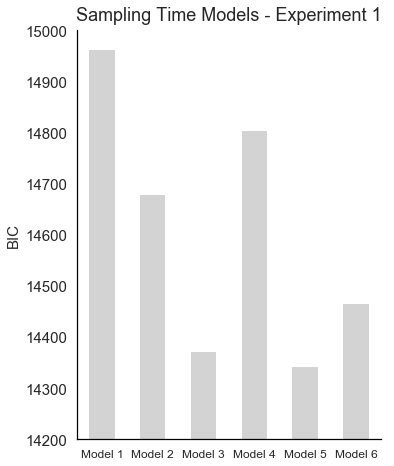

In [119]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS1['model'], DFBICS1['study1'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([14200,15000])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Sampling Time Models - Experiment 1", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"), fontsize=12)
#ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()


#### Sampling Time Models Study 2

In [117]:
# re-index for z-scoring
Data2Free.reset_index(inplace=True)
Data2Free.index = range(1, len(Data2Free) + 1)
Data2Free['Participant']=Data2Free['Participant']
Data2Free = Data2Free.set_index(['Participant', 'index'])

<ipython-input-117-c97fe73236c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2Free['Participant']=Data2Free['Participant']


In [130]:
## z-score RT for inclusion in the model
Data2Free.head()
Data2Free['ZRT'] = (Data2Free['RT1']-Data2Free.groupby(level='Participant')['RT1'].mean())/Data2Free.groupby(level = 'Participant')['RT1'].std()
# Are the mean Z-scores all close to 0?
Data2Free.groupby(level=0)['ZRT'].mean()


Participant
1     8.018277e-17
2    -1.993115e-15
7    -1.876806e-16
9     6.522560e-16
10    2.555275e-17
11   -3.876969e-17
13    3.172066e-16
14    6.062170e-16
15   -2.215159e-15
17   -3.744800e-18
18    6.784696e-16
19    5.965246e-16
20    4.783211e-16
21    5.727341e-17
22   -1.858632e-16
24    3.876969e-16
25   -8.282616e-17
26   -4.692014e-16
Name: ZRT, dtype: float64

In [133]:
# load data in R
r_df = pandas2ri.py2ri(Data2Free)
%R -i r_df

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "new_bias_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


In [134]:
%%R
# sampling model 1
sampling_model1 = lmer(ZDeltaSampling ~ Choice + (1 + Choice | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model1))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + (1 + Choice | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6154.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3548 -0.5923 -0.0042  0.6089  3.9369 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 participant (Intercept) 0.04504  0.2122        
             Choice      0.16269  0.4033   -1.00
 Residual                0.89256  0.9448        
Number of obs: 2244, groups:  participant, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.24483    0.05714  -4.285
Choice       0.49713    0.10313   4.821

Correlation of Fixed Effects:
       (Intr)
Choice -0.935


In [135]:
%%R
# sampling model 2
sampling_model2 = lmer(ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model2))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6125.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3313 -0.5944  0.0140  0.6188  3.9799 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr
 participant (Intercept) 0.0000000 0.00000      
             NonAbsDiff  0.0008251 0.02873   NaN
 Residual                0.8835597 0.93998      
Number of obs: 2244, groups:  participant, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.003545   0.019874   0.178
NonAbsDiff  0.064476   0.008082   7.978

Correlation of Fixed Effects:
           (Intr)
NonAbsDiff 0.004 


In [136]:
%%R
# sampling model 3
sampling_model3 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model3))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff |  
    participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6040.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4713 -0.5911  0.0068  0.6132  4.1006 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr       
 participant (Intercept) 3.878e-02 0.196933            
             Choice      1.467e-01 0.382995 -1.00      
             NonAbsDiff  2.073e-05 0.004554 -1.00  1.00
 Residual                8.452e-01 0.919334            
Number of obs: 2244, groups:  participant, 18

Fixed effects:
             Estimate Std. Error t value
(Intercept) -0.137017   0.054471  -2.515
Choice       0.279257   0.100175   2.788
NonAbsDiff   0.049887   0.004576  10.902

Correlation of Fixed Effects:
           (Intr) Choice
Choice     -0.933       
NonAbsDiff -0.029  0.024


In [137]:
%%R
# sampling model 4
sampling_model4 = lmer(ZDeltaSampling ~ Choice + ZConf1 + Choice*ZConf1 + (1 + Choice + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model4))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + ZConf1 + Choice * ZConf1 + (1 + Choice +  
    ZConf1 + Choice * ZConf1 | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6146.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.1586 -0.5844 -0.0151  0.6288  4.1489 

Random effects:
 Groups      Name          Variance Std.Dev. Corr             
 participant (Intercept)   0.000000 0.00000                   
             Choice        0.032558 0.18044    NaN            
             ZConf1        0.006573 0.08107    NaN -0.64      
             Choice:ZConf1 0.007796 0.08829    NaN  0.98 -0.78
 Residual                  0.888567 0.94264                   
Number of obs: 2244, groups:  participant, 18

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.23440    0.02749  -8.526
Choice         0.49010    0.05846   8.384
ZConf1        -0.13950    0.03411

In [138]:
%%R
# sampling model 5
sampling_model5 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model5))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6012.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4947 -0.5902 -0.0023  0.6129  4.2636 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 participant (Intercept)   4.415e-02 0.210112                        
             Choice        1.629e-01 0.403625 -1.00                  
             NonAbsDiff    2.982e-05 0.005461 -0.18  0.13            
             ZConf1        1.073e-02 0.103594  0.54 -0.59  0.73      
             Choice:ZConf1 1.360e-02 0.116604 -0.92  0.94 -0.22 -0.83
 Residual                  8.276e-01 0.909709                        
Number of obs: 2244, groups:  participant, 18

Fixed effects:
               Estima

In [139]:
%%R
# sampling model 6
sampling_model6 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT + (1 + Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model6))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice *  
    ZConf1 + Choice * ZRT + (1 + Choice + NonAbsDiff + ZConf1 +  
    ZRT + Choice * ZConf1 + Choice * ZRT | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6012.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7107 -0.5741 -0.0042  0.6096  4.2932 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                         
 participant (Intercept)   4.431e-02 0.210508                              
             Choice        1.661e-01 0.407587 -1.00                        
             NonAbsDiff    3.601e-05 0.006001  0.07 -0.07                  
             ZConf1        1.123e-02 0.105955  0.50 -0.50  0.54            
             ZRT           1.243e-02 0.111483 -0.50  0.50  0.22  0.11      
             Choice:ZConf1 1.461e-02 0.120862 -0.83  0.83 -0.12 -0.83

In [140]:
%%R
# compute BIC scores for each model
print(BIC(sampling_model1))
print(BIC(sampling_model2))
print(BIC(sampling_model3))
print(BIC(sampling_model4))
print(BIC(sampling_model5))
print(BIC(sampling_model6))

[1] 6200.406
[1] 6171.456
[1] 6117.795
[1] 6262.32
[1] 6174.874
[1] 6289.999


In [141]:
%R BIC1 <- BIC(sampling_model1)
%R BIC2 <- BIC(sampling_model2)
%R BIC3 <- BIC(sampling_model3)
%R BIC4 <- BIC(sampling_model4)
%R BIC5 <- BIC(sampling_model5)
%R BIC6 <- BIC(sampling_model6)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4
%R -o BIC5
%R -o BIC6

In [144]:
# create new dataframe with BIC scores
BICsampling2 = []
DFBICS2=pd.DataFrame(data=BICsampling2)
DFBICS2['model']=[0,1,2,3,4,5]
DFBICS2['study2']=[BIC1, BIC2, BIC3, BIC4, BIC5, BIC6]


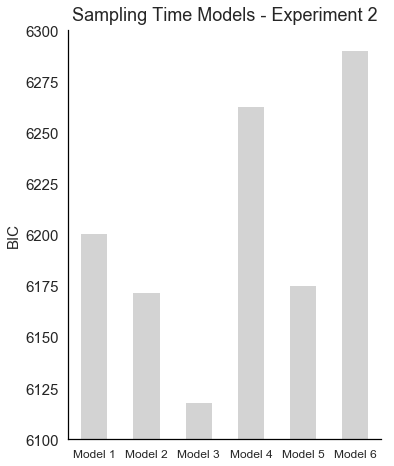

In [155]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS2['model'], DFBICS2['study2'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([6100,6300])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Sampling Time Models - Experiment 2", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"), fontsize=12)
# ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('modelcomp_samp_s2.pdf')


#### Change of Mind Models Study 1

In [218]:
# load data in R
r_df = pandas2ri.py2ri(Data1)
%R -i r_df

In [161]:
%%R
# change of mind model 1
changemodel1 = glmer(Change ~ DDsqrt + (1 + DDsqrt | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel1))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + (1 + DDsqrt | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  5976.5   6009.7  -2983.3   5966.5     5595 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9564 -0.5768 -0.5027 -0.3441  3.2838 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 participant (Intercept) 0.242033 0.49197       
             DDsqrt      0.002133 0.04618  -1.00
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.50533    0.17688  -2.857  0.00428 ** 
DDsqrt      -0.32350    0.06642  -4.871 1.11e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
DDsqrt -0.893


In [167]:
%%R
# change of mind model 2
changemodel2 = glmer(Change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel2))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4873.7   4933.4  -2427.9   4855.7     5591 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1321 -0.5232 -0.3096 -0.1033 10.0435 

Random effects:
 Groups      Name        Variance Std.Dev. Corr       
 participant (Intercept) 0.249952 0.49995             
             DDsqrt      0.002377 0.04875  -0.61      
             ZBias       0.303103 0.55055  -0.13  0.86
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.94549    0.19657  -4.810 1.51e-06 ***
DDsqrt      -0.29318    0.07601  -3.857 0.000115 ***
ZBias       -1.27897    0.11440 -11.180  < 2e-16 ***
---
Signif. codes:  0 

In [168]:
%%R
# change of mind model 3
changemodel3 = glmer(Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel3))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 |  
    participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4668.0   4760.8  -2320.0   4640.0     5586 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9698 -0.4983 -0.2696 -0.0795 10.4281 

Random effects:
 Groups      Name        Variance Std.Dev. Corr             
 participant (Intercept) 0.311488 0.5581                    
             DDsqrt      0.001005 0.0317   -1.00            
             ZBias       0.284694 0.5336    0.02 -0.02      
             ZConf1      0.046305 0.2152    0.45 -0.45 -0.16
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.17566    0.20793  -5.654 1.57e-08 ***
DDsqrt      -0.2396

In [169]:
%%R
# change of mind model 4
changemodel4 = glmer(Change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias + ZConf1 + ZRT | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel4))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias +  
    ZConf1 + ZRT | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4660.4   4793.0  -2310.2   4620.4     5580 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9837 -0.4946 -0.2651 -0.0817 10.9146 

Random effects:
 Groups      Name        Variance Std.Dev. Corr                   
 participant (Intercept) 0.368173 0.60677                         
             DDsqrt      0.006862 0.08284  -0.74                  
             ZBias       0.291239 0.53967  -0.14  0.47            
             ZConf1      0.029849 0.17277   0.48 -0.85 -0.22      
             ZRT         0.013188 0.11484  -0.67  0.72 -0.09 -0.53
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Esti

In [170]:
%%R
# compute BIC scores for each model
print(BIC(changemodel1))
print(BIC(changemodel2))
print(BIC(changemodel3))
print(BIC(changemodel4))

[1] 6009.675
[1] 4933.396
[1] 4760.788
[1] 4792.994


In [171]:
%R BIC1 <- BIC(changemodel1)
%R BIC2 <- BIC(changemodel2)
%R BIC3 <- BIC(changemodel3)
%R BIC4 <- BIC(changemodel4)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4

In [172]:
# create new dataframe with BIC scores
BICsampling1 = []
DFBICS1=pd.DataFrame(data=BICsampling1)
DFBICS1['model']=[0,1,2,3]
DFBICS1['study1']=[BIC1, BIC2, BIC3, BIC4]


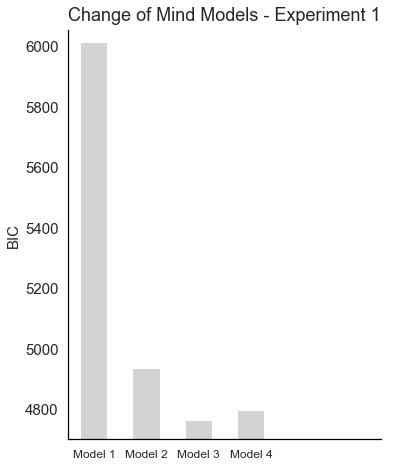

In [175]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS1['model'], DFBICS1['study1'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([4700,6050])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Change of Mind Models - Experiment 1", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4"), fontsize=12)
# ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('modelcomp_change_S1.pdf')


#### Change of Mind Models Study 2

In [217]:
## z-score RT for inclusion in the model
Data2.head()
Data2['ZRT'] = (Data2['RT1']-Data2.groupby(level='Participant')['RT1'].mean())/Data2.groupby(level = 'Participant')['RT1'].std()
# Are the mean Z-scores all close to 0?
Data2.groupby(level=0)['ZRT'].mean()


Participant
1    -3.398131e-16
2    -6.539700e-16
7    -3.745275e-16
9     7.066658e-16
10    2.528841e-16
11    6.595253e-16
13    8.635068e-17
14    4.565902e-16
15   -1.739349e-15
17    4.739375e-16
18   -8.748937e-16
19    1.097006e-16
20    1.374239e-16
21   -8.405974e-16
22    1.323787e-15
24   -3.678715e-16
25    2.436323e-16
26   -1.903239e-16
Name: ZRT, dtype: float64

In [219]:
# load data in R
r_df = pandas2ri.py2ri(Data2)
%R -i r_df

In [161]:
%%R
# change of mind model 1
changemodel1 = glmer(change ~ DDsqrt + (1 + DDsqrt | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel1))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + (1 + DDsqrt | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4476.4   4508.5  -2233.2   4466.4     4495 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3086 -0.5159 -0.4512 -0.3676  2.8283 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 participant (Intercept) 0.52503  0.7246        
             DDsqrt      0.02863  0.1692   -1.00
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.70763    0.22959  -3.082  0.00206 ** 
DDsqrt      -0.33781    0.08278  -4.081 4.49e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
DDsqrt -0.925


In [162]:
%%R
# change of mind model 2
changemodel2 = glmer(change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel2))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4416.8   4474.5  -2199.4   4398.8     4491 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6651 -0.5275 -0.4373 -0.3023  5.2922 

Random effects:
 Groups      Name        Variance Std.Dev. Corr       
 participant (Intercept) 0.56971  0.7548              
             DDsqrt      0.04231  0.2057   -0.92      
             ZBias       0.06496  0.2549   -0.10  0.48
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.72919    0.23625  -3.086  0.00203 ** 
DDsqrt      -0.35235    0.08812  -3.998 6.38e-05 ***
ZBias       -0.27837    0.07150  -3.893 9.88e-05 ***
---
Signif. codes:  0 

In [197]:
%%R
# change of mind model 3
changemodel3 = glmer(change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel3))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 |  
    participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4208.1   4297.8  -2090.0   4180.1     4486 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4077 -0.5036 -0.3824 -0.2430  4.5449 

Random effects:
 Groups      Name        Variance Std.Dev. Corr             
 participant (Intercept) 0.79116  0.8895                    
             DDsqrt      0.05050  0.2247   -0.98            
             ZBias       0.06101  0.2470    0.16  0.02      
             ZConf1      0.04565  0.2136    0.27 -0.32 -0.26
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.06296    0.26628  -3.992 6.56e-05 ***
DDsqrt      -0.2400

In [221]:
%%R
# change of mind model 4
changemodel4 = glmer(change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias + ZConf1 + ZRT | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel4))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias +  
    ZConf1 + ZRT | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4214.1   4342.3  -2087.1   4174.1     4480 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0470 -0.5036 -0.3812 -0.2395  4.6073 

Random effects:
 Groups      Name        Variance Std.Dev. Corr                   
 participant (Intercept) 0.794288 0.89123                         
             DDsqrt      0.050936 0.22569  -0.98                  
             ZBias       0.060650 0.24627   0.15  0.06            
             ZConf1      0.050633 0.22502   0.25 -0.28 -0.23      
             ZRT         0.007894 0.08885  -0.02  0.12  0.40  0.73
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Esti

In [163]:
%%R
# change of mind model 5
changemodel5 <- glmer(change ~ DDsqrt + ZBias + ZConf1 + FixedSampling + FixedSampling*ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling*ZBias | participant), data=r_df, control = glmerControl(optimizer='nlminbw'), family="binomial")
print(summary(changemodel5))


R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + ZConf1 + FixedSampling + FixedSampling *  
    ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling *  
    ZBias | participant)
   Data: r_df
Control: glmerControl(optimizer = "nlminbw")

     AIC      BIC   logLik deviance df.resid 
  4078.6   4251.7  -2012.3   4024.6     4473 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5878 -0.5018 -0.3540 -0.1897  5.3821 

Random effects:
 Groups      Name                Variance Std.Dev. Corr                   
 participant (Intercept)         0.84474  0.9191                          
             ZBias               0.40437  0.6359    0.43                  
             DDsqrt              0.04305  0.2075   -0.99 -0.27            
             ZConf1              0.04747  0.2179    0.23  0.68 -0.12      
             FixedSampling       0.24173  0.4917   

In [226]:
%%R
# compute BIC scores for each model
print(BIC(changemodel1))
print(BIC(changemodel2))
print(BIC(changemodel3))
print(BIC(changemodel4))
print(BIC(changemodel5))

[1] 4508.505
[1] 4504.921
[1] 4297.82
[1] 4342.344
[1] 4253.645


In [165]:
%R print(BIC(changemodel5))

[1] 4251.718


array([4251.71842321])

In [227]:
%R BIC1 <- BIC(changemodel1)
%R BIC2 <- BIC(changemodel2)
%R BIC3 <- BIC(changemodel3)
%R BIC4 <- BIC(changemodel4)
%R BIC5 <- BIC(changemodel5)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4
%R -o BIC5

In [228]:
# create new dataframe with BIC scores
BICsampling2 = []
DFBICS2=pd.DataFrame(data=BICsampling2)
DFBICS2['model']=[0,1,2,3,4]
DFBICS2['study2']=[BIC1, BIC2, BIC3, BIC4, BIC5]


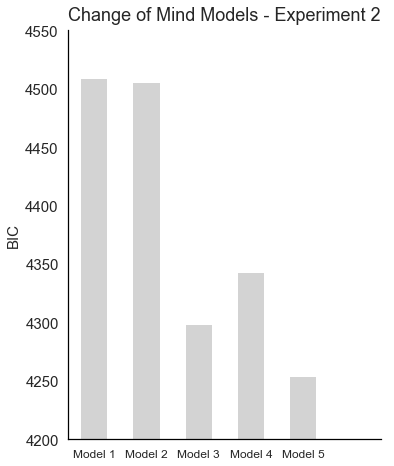

In [230]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS2['model'], DFBICS2['study2'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([4200,4550])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Change of Mind Models - Experiment 2", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"), fontsize=12)
# ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('modelcomp_change_S2.pdf')


<a id=Functions></a>

### Functions used

In [12]:
# plotting psychometric curves
def logistic_regression(subjects, data):
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    #run the classifier
    clf = sklearn.linear_model.LogisticRegression(C=1e5)
    logit1 = []
    logit2 = []
    plot = fig.add_subplot(1,1,1)

    # plot data points choice 1
    mean_prob_choice = []
    errors = []
    rankdiffs = range(-15,16)
    for y in rankdiffs:
        mean_prob_choice.append(mean(data[data['NonAbsDiff']==y]['Left1']))
        errors.append(stats.sem(data[data['NonAbsDiff']==y]['Left1']))
    plt.errorbar(rankdiffs, mean_prob_choice, yerr=errors, fmt='o', label='Choice 1', color='#3C91E6')

    # plot data points choice 2
    mean_prob_choice = []
    errors = []
    for y in rankdiffs:
        mean_prob_choice.append(mean(data[data['NonAbsDiff']==y]['Left2']))
        errors.append(stats.sem(data[data['NonAbsDiff']==y]['Left2']))
    plt.errorbar(rankdiffs, mean_prob_choice, yerr=errors, fmt='o', label='Choice 2', color='#EA8B4C')
    
    X_test = np.linspace(-16,16,300)
    # get fit choice 1
    clf.fit(data['NonAbsDiff'][:, np.newaxis], data['Left1'])
    logit1 = model(X_test*clf.coef_).ravel()

    # get fit choice 2
    clf.fit(data['NonAbsDiff'][:, np.newaxis], data['Left2'])
    logit2 = model(X_test*clf.coef_).ravel()
    
    #plt fits
    plot.plot(X_test, logit1, linewidth=3, color='#3C91E6')
    plot.plot(X_test, logit2, linewidth=3, color='#EA8B4C')

    plot.set_ylabel('Prob(Choice=Left)', size=24)
    plot.set_xlabel('Dot Difference (Left-Right)', size=24)
    plot.tick_params(axis='both', which='major', labelsize=20)

    plot.set_ylim(0, 1.01)
    plot.set_xlim(-15.5, 15.5)
    plot.grid(True)
    grid(False)
    plt.legend(prop={'size':20})    
    sns.despine(right=True, top=True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, left=0.15)

In [13]:
# z-score variable by participant
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [14]:
def Coefpresplot_bar2(regtable1, mixtable1,regtable2, mixtable2, intercept=True, barcol1='#000000',barcol2='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0, hatch2 ='',labels = ['',''] ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    bar_sep= 0.25
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=24)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not   
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients
    XLim = (0, len(regtable1.columns)+1  )
    YLim = (round_to_5(np.min([np.min(mixtable1),np.min(mixtable2)]))-0.2, round_to_5(np.max([np.max(mixtable1),np.max(mixtable2)]))+0.2)
   # else:
   #     XLim = (0, len(regtable1.columns) +1)
   #     YLim = (round_to_5(np.min([np.min(mixtable1),np.min(mixtable2)]))-0.2, round_to_5(np.max([np.max(mixtable1),np.max(mixtable2)]))+0.2)
   # if ylimits != ():
    #    YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients

    
    Coefficients = regtable1.columns
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    # Color for conditions 1 and 2
    colourlist1 = [barcol1] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    colourlist2 = [barcol2] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        # Plot condition 1
        position += 1
        ax.bar(position-bar_sep, regtable1.loc['Estimate', Coefficient], width=0.4,color=colourlist1[position-1],)
        ax.errorbar(position-bar_sep, regtable1.loc['Estimate', Coefficient],
                    yerr=regtable1.loc['SE', Coefficient]*1.96, lw=2, color='#000000')

        # Plot condition 2
        ax.bar(position+bar_sep, regtable2.loc['Estimate', Coefficient], width=0.4,color=colourlist2[position-1],)
        ax.errorbar(position+bar_sep, regtable2.loc['Estimate', Coefficient],
                    yerr=regtable2.loc['SE', Coefficient]*1.96, lw=2, color='#000000')


   



   # Plot dots for the individual coefficients
    # Assumuing that mixtable1 and mixtable2 have exactly the same number of elements 
    
    coef_num1 = range(0,len(mixtable1)) 
    for i in coef_num1:
        # Plot dots condition 1
        part_coefs = mixtable1.iloc[i]
        position_parts= range(len(part_coefs))
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(np.sum([list(position_parts) ,1 -  bar_sep+jittr], axis = 0), part_coefs.values, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        
    coef_num2 = range(0,len(mixtable2)) 
        
    for i in coef_num2:       
        
        # Plot dots condition 1
        part_coefs = mixtable2.iloc[i]
        position_parts= range(len(part_coefs))
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(np.sum([list(position_parts) , 1 +bar_sep-jittr], axis = 0), part_coefs.values, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")
        

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, len(regtable1.columns)+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))

    # Setting the x-axis major tick's label

    ax.set_xticklabels(regtable1.columns, rotation=0)        
   
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=25)

    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    

    patch1 = mpatches.Patch(facecolor=colourlist1[position-1],hatch=r'', label=labels[0])
    patch2 = mpatches.Patch(facecolor=colourlist2[position-1],hatch=r'', label=labels[1])

    leg = plt.legend(handles=[patch1,patch2],fontsize=25)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    
    sns.despine()

In [15]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

In [30]:
def Coefpresplot_og_bar2(regtable1, mixtable1,regtable2, mixtable2, intercept=False, barcol1='#000000',barcol2='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0, hatch2 ='',labels = ['',''] ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    bar_sep= 0.25
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=24)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not   
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients
    if intercept == True:
                
        XLim = (0, len(regtable1.columns) + 2)
        YLim = (round_to_5(np.min([np.min(mixtable1),np.min(mixtable2)]))-0.2, round_to_5(np.max([np.max(mixtable1),np.max(mixtable2)]))+0.2)
    else:
        XLim = (0, len(regtable1.columns) +1)
        YLim = (round_to_5(np.min([np.min(mixtable1),np.min(mixtable2)]))-0.2, round_to_5(np.max([np.max(mixtable1),np.max(mixtable2)]))+0.2)
    if ylimits != ():
        YLim = ylimits
#     YLim=(-5,5)    
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients

    if intercept == True:
        Coefficients = regtable1.columns
    else:
        if len(regtable1.columns)<len(mixtable1):
            Coefficients = regtable1.columns
        else:
            Coefficients = regtable1.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    # Color for conditions 1 and 2
    colourlist1 = [barcol1] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    colourlist2 = [barcol2] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        # Plot condition 1
        ax.bar(position-bar_sep, regtable1.loc['coefficient', Coefficient], width=0.4,color=colourlist1[position-1],)
        ax.errorbar(position-bar_sep, regtable1.loc['coefficient', Coefficient],
                    yerr=regtable1.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        # Plot condition 2
        ax.bar(position+bar_sep, regtable2.loc['coefficient', Coefficient], width=0.4,color=colourlist2[position-1],)
        ax.errorbar(position+bar_sep, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        
   # Plot dots for the individual coefficients
    # Assumuing that mixtable1 and mixtable2 have exactly the same number of elements 
    
    if intercept == True:
        coef_num = range(0,len(mixtable1)) 
    else:
        coef_num = range(1,len(mixtable1))

    coef_num1 = range(0,len(mixtable1)) 
    for i in coef_num1:
        # Plot dots condition 1
        part_coefs = mixtable1.iloc[i]
        position_parts= range(len(part_coefs))
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(np.sum([list(position_parts) ,1 -  bar_sep+jittr], axis = 0), part_coefs.values, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        
    coef_num2 = range(0,len(mixtable2)) 
        
    for i in coef_num2:       
        
        # Plot dots condition 1
        part_coefs = mixtable2.iloc[i]
        position_parts= range(len(part_coefs))
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(np.sum([list(position_parts) , 1 +bar_sep-jittr], axis = 0), part_coefs.values, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")
                

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable1.columns, rotation=0)        
    else:
        if len(regtable1.columns)<len(mixtable1):
            ax.set_xticklabels(regtable1.columns, rotation=0)
        else:    
            ax.set_xticklabels(regtable1.columns[1:], rotation=0)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=25)

    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    

    patch1 = mpatches.Patch(facecolor=colourlist1[position-1],hatch=r'', label=labels[0])
    patch2 = mpatches.Patch(facecolor=colourlist2[position-1],hatch=r'', label=labels[1])

    leg = plt.legend(handles=[patch1,patch2],fontsize=25)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    
    sns.despine()

In [91]:
def parsplit(DF, input, quantiles):
    qvalues = pd.qcut(DF[input], quantiles, labels = range(1, quantiles+1))
    return qvalues 

def logisticplot_all_sbj_slope(moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
#inputs example   
#logisticplot_all('DDTSplit', 'High DDT', 'Low DDT', data=data_expL, xaxis='zDVal', yaxis='Choice', ylab='P(Right Item)', xlab='Difference in Value (DVal)',
#                 modhighcol='#4F6A9A', modlowcol='#B5C8E9', title='empty', parvar='Part')


    # Counter to know where to plot the particpant
    order = 1
    # Initialize the array to store coefs
    coefs_all = []

   # a list of all the participants in the dataset
    participants = data.loc[:, parvar].unique()

    # defining the figure size
    sns.set_style('white')
    fig = figure(figsize=(50,70))
    
    for x in participants:
        # defining the sub figures
        sub={}
        sub['%s' % x] = plt.subplot(int(len(participants)/5+1), 5, order)


        # Extract dataframe for that particualt participant
        data_in = data.loc[data[parvar] == x]

        sns.set(font_scale=1.5, style='white')

        # defining the sigmoid function
        def model(x):
            y = 1 / (1 + np.exp(-x))
            return y

        #sub = plt.subplot()
        sub['%s' % x].set_title('participant %s' % x)


        #run the classifier
        clf = sklearn.linear_model.LogisticRegression(C=1e5)

        # Paula used these dictionaries to store the values of the predictive lines for all the participants.
        logit_low = {}
        logit_high = {}
        logit_all = {}


        # I think this defines the problem space
        X_test = np.linspace(-5,10,300)

        # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
        # first I specify the value difference right - left, then I specify the choices, left or right
        clf.fit(data_in.loc[data_in[(data[moderator]==0)].index, xaxis][:, np.newaxis],
                data_in.loc[data_in[(data[moderator]==0)].index, yaxis])
        logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()

        #print ('Part: ',x , ' Low measure:logit coef =',clf.coef_, '; Intercept: ', clf.intercept_)

        low_coef = clf.coef_
        low_intercept = clf.intercept_
        
        # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
        # first I specify the value difference right - left, then I specify the choices, left or right
        clf.fit(data_in.loc[data_in[(data_in[moderator]==1)].index, xaxis][:, np.newaxis],
                data_in.loc[data_in[(data_in[moderator]==1)].index, yaxis])
        logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()

        #print ('Part: ',x ,' High measure:logit coef =',clf.coef_, '; Intercept: ', clf.intercept_)

        high_coef = clf.coef_
        high_intercept = clf.intercept_


        # fitting the predictive logistic model for all the trials, for a participant specified by x
        # first I specify the value difference right - left, then I specify the choices, left or right
        clf.fit(data_in[xaxis][:, np.newaxis],
                data_in[yaxis])
        logit_all = model(X_test * clf.coef_ + clf.intercept_).ravel()

        #print ('Part: ',x ,' High measure:logit coef =',clf.coef_, '; Intercept: ', clf.intercept_)

        all_coef = clf.coef_
        all_intercept = clf.intercept_

        #Plotting the predictive lines
        line_high = sub['%s' % x].plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
        line_low = sub['%s' % x].plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5)
        line_all = sub['%s' % x].plot(X_test, logit_all, color="#000000", linewidth=3, label=modlow, zorder=5,linestyle='--')

        coefs_part= np.column_stack((x,low_coef,low_intercept,high_coef,high_intercept,all_coef,all_intercept))
        coefs_all.append(coefs_part[0])

        # Set Labels
       # sub['%s' % x].set_ylabel(ylab, fontsize=30)
       # sub['%s' % x].set_xlabel(xlab, fontsize=30)

        # Set Ticks
        sub['%s' % x].set_xticks((-5,-3,-1,1,3,5))
        sub['%s' % x].set_yticks((0,0.25,0.5,0.75,1))
        sub['%s' % x].tick_params(axis='both', which='major', labelsize=20)

        # Set Limits
        sub['%s' % x].set_ylim(-0.01, 1.01)
        sub['%s' % x].set_xlim(-5, 5)


        sns.despine()

        order += 1
        
    custom_lines = [Line2D([0], [0], color=modhighcol, lw=4),
                Line2D([0], [0], color=modlowcol, lw=4)]
    fig.legend(custom_lines, [modhigh, modlow],loc = 4)       

    fig.text(0.5, 0.0, xlab, ha='center')
    fig.text(0.0, 0.5, ylab, va='center', rotation='vertical')
    
    coefs_all = pd.DataFrame(coefs_all,columns=['Participant','Low Coef','Low Intercept','High Coef','High Intercept','All Coef','All Intercept'])
    return coefs_all
        

In [92]:
def splitByVar(new_data, Splits_variables,participant_var,trial_var):

    median_matrix=[]
    median_matrix_aux=[]
    median_matrix_aux_cond=[]
    Split_cols = []
    
    for h in range(len(Splits_variables)):
        median_matrix=[]
        for i in np.unique(new_data[participant_var]):
                median_matrix_aux=[]
    
                #for j in np.unique(new_data["BlockCond"]):
                #median_matrix_aux_cond=[]
    
                #Extract data by participant and BlockCond (1: Like, 2: Dislike)
                Splitdata = new_data.loc[new_data[participant_var] == i]
               # Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
                
                # Select the column to split
                Splitdata = Splitdata.loc[:,[trial_var,Splits_variables[h]]]
                SplitSort = Splitdata.values
                # Sort for confidence column
                SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
                #print(SplitSort)
                lenPart = len(Splitdata)
                #print(lenPart)
                # Generate column with median order
                median_low = [0] * int (lenPart/2)
                #print (median_low)
                median_high = [1] * int (lenPart/2)
                
                # corroborate the same size for both splits, if not add one extra
                if (len(median_high) + len(median_low))< lenPart:
                    median_high.append(1)
                
                #print (median_high)
                median_split_order = median_low + median_high
                
                #Attach split median order column (1 and 0)
                median_aux= np.column_stack((SplitSort,median_split_order))
                #Sort back to trial number
                SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
                #print(len(SplitSorted))
                
                for kk in range(len(SplitSorted)): 
                    if len(median_matrix_aux) == 0 :
                        median_matrix_aux = SplitSorted[0]
                    else:
                        median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
            
                #print(len(median_matrix_aux))
                # sort after adding both conditions    
                median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
                
                #Extract only the column with the median split information
                median_matrix_aux = median_matrix_aux[:,2]
                
                #append to median matrix for the participants
                for k in range(len(median_matrix_aux)):    
                    median_matrix.append(median_matrix_aux [k])
        
        #median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
        #print(len (median_matrix))
        #add new column (new split variable columns) to the split matrix
        if  h == 0:
            Split_cols = median_matrix
        else:
            Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)
    return Split_cols

In [113]:
def ttestsPlot(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Like", lab2 = "Dislike",title = ''):

    # t-TEST
    diff = mean(data1) - mean(data2)
    [s, p] = stats.ttest_rel(data1,data2)
    print ("ChoiceSlopes: MeanL = "+ str(mean(data1))+ "; MeanD = "+ str(mean(data2))+"; [Like - Dislike] =  " + str(diff) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(p) )
    
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(data1))    
    plt.scatter([1]*len(data1)+jittr, data1, c= c1, alpha=0.7,label=lab1)
    plt.scatter([2]*len(data2)+jittr, data2, c= c2, alpha=0.7,label=lab2)
    
    ## add lines between slope points in like and dislike for each participant
    
    for i in range(len(data1)):
        plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)
        #if data1[i]<data2[i]:
        #    print ("Participants with slope in Like < Dislike: " + str(i))
            
    
    #legend(loc = 'best')
    plt.xticks([1, 2,], [lab1, lab2],fontsize=18)
    plt.ylabel(title, fontsize=18)
    sns.despine()

In [116]:
# plotting psychometric curves
def logistic_regression2(data1,data2, lab1, lab2, varname):
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    #run the classifier
    clf = sklearn.linear_model.LogisticRegression(C=1e5)
    logit1 = []
    logit2 = []
    plot = fig.add_subplot(1,1,1)

    # plot data points choice 1
    mean_prob_choice = []
    errors = []
    rankdiffs = range(-15,16)
    for y in rankdiffs:
        mean_prob_choice.append(mean(data1[data1['NonAbsDiff']==y][varname]))
        errors.append(stats.sem(data1[data1['NonAbsDiff']==y][varname]))
    plt.errorbar(rankdiffs, mean_prob_choice, yerr=errors, fmt='o', label=lab1, color='#EA8B4C')

    # plot data points choice 2
    mean_prob_choice = []
    errors = []
    for y in rankdiffs:
        mean_prob_choice.append(mean(data2[data2['NonAbsDiff']==y][varname]))
        errors.append(stats.sem(data2[data2['NonAbsDiff']==y][varname]))
    plt.errorbar(rankdiffs, mean_prob_choice, yerr=errors, fmt='o', label=lab2, color='#3C91E6')
    
    X_test = np.linspace(-16,16,300)
    # get fit choice 1
    clf.fit(data1['NonAbsDiff'][:, np.newaxis], data1[varname])
    logit1 = model(X_test*clf.coef_).ravel()

    print(clf.coef_)
    # get fit choice 2
    clf.fit(data2['NonAbsDiff'][:, np.newaxis], data2[varname])
    logit2 = model(X_test*clf.coef_).ravel()
    
    print(clf.coef_)
    #plt fits
    plot.plot(X_test, logit1, linewidth=3, color='#EA8B4C')
    plot.plot(X_test, logit2, linewidth=3, color='#3C91E6')

    plot.set_ylabel('Prob(Choice=Left)', size=24)
    plot.set_xlabel('Dot Difference (Left-Right)', size=24)
    plot.tick_params(axis='both', which='major', labelsize=20)

    plot.set_ylim(0, 1.01)
    plot.set_xlim(-15.5, 15.5)
    plot.grid(True)
    grid(False)
    plt.legend(prop={'size':20})    
    sns.despine(right=True, top=True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, left=0.15)

In [124]:
def ttestsPlotBars(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Like", lab2 = "Dislike",title = ''):

    # t-TEST
    diff = mean(data1) - mean(data2)
    [s, p] = stats.ttest_rel(data1,data2)
    print ("ChoiceSlopes: MeanL = "+ str(mean(data1))+ "; MeanD = "+ str(mean(data2))+"; [Like - Dislike] =  " + str(diff) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(p) )
    
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    
    plt.bar(1 , np.mean(data1), width=0.4,color=c1,)
    plt.bar(2 , np.mean(data2), width=0.4,color=c2,)
    
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(data1))    
    plt.scatter([1]*len(data1)+jittr, data1, c= c1, alpha=0.7,label=lab1,edgecolors = '#000000')
    plt.scatter([2]*len(data2)+jittr, data2, c= c2, alpha=0.7,label=lab2,edgecolors = '#000000')
    
    ## add lines between slope points in like and dislike for each participant
    
    for i in range(len(data1)):
        plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)
        #if data1[i]<data2[i]:
        #    print ("Participants with slope in Like < Dislike: " + str(i))
            
    
    #legend(loc = 'best')
    plt.xticks([1, 2,], [lab1, lab2],fontsize=18)
    plt.ylabel(title, fontsize=18)
    sns.despine()